# 🎯 Project Brief
Playhouse Communication is one of Nigeria's leading digital marketing agencies. They combine design and media planning with cutting-edge tech solutions to reimagine what marketing is all about. Their client roster is a mix of global juggernauts and nimble SMEs, each redefining their sectors.

### The Project
The goal of the project is to decode a treasure trove of social media data for one of our high-profile clients and transform it into game-changing insights.

### Key Deliverables:
* Create a comprehensive and reproducible report detailing their findings.
* Propose actionable recommendations based on the insights.
* Create a simple and engaging visualisation of your results & analysis.

### Load Workspace

In [1]:
import re
import datetime as dt
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.diagnostic import acorr_ljungbox

from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from sklearn.metrics import r2_score

### Load the Data

In [2]:
linkedin = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.csv', low_memory=False)
twitter = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv', low_memory=False)
facebook = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Facebook.csv', low_memory=False)
instagram = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Instagram.csv', low_memory=False)

In [3]:
print(linkedin.info())
print(twitter.info())
print(facebook.info())
print(instagram.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Columns: 147 entries, Date to Tags
dtypes: float64(127), int64(1), object(19)
memory usage: 8.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8529 entries, 0 to 8528
Columns: 147 entries, Date to Tags
dtypes: float64(119), int64(1), object(27)
memory usage: 9.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9803 entries, 0 to 9802
Columns: 147 entries, Date to Tags
dtypes: float64(78), object(69)
memory usage: 11.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 147 entries, Date to Tags
dtypes: float64(125), int64(1), object(21)
memory usage: 11.2+ MB
None


All datasets have 147 features. We'll merge them:

In [4]:
# Create a list of DataFrames
dfs = [linkedin, twitter, facebook, instagram]

# Check if columns in all DataFrames are the same
columns_are_same = all(df.columns.equals(dfs[0].columns) for df in dfs)

if columns_are_same:
    print("All DataFrames have the same columns.")
else:
    print("Not all DataFrames have the same columns.")

All DataFrames have the same columns.


In [5]:
df = pd.concat(dfs, axis=0, ignore_index=True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36092 entries, 0 to 36091
Columns: 147 entries, Date to Tags
dtypes: float64(70), object(77)
memory usage: 40.5+ MB
None


Date              Post ID   Network Post Type Content Type  \
0  7/13/2023 12:03 pm  7085212016608456704  LinkedIn      Post        Photo   
1   7/12/2023 8:00 pm  7084969706025009152  LinkedIn      Post         Text   
2   7/12/2023 7:00 pm  7084954641788018688  LinkedIn      Post        Photo   
3   7/11/2023 2:49 pm  7084529022105231360  LinkedIn      Post        Photo   
4   7/11/2023 9:17 am  7084445462967070721  LinkedIn      Post        Photo   

        Profile        Sent by  \
0  Stanbic IBTC  Blessing Ubah   
1  Stanbic IBTC  Blessing Ubah   
2  Stanbic IBTC  Blessing Ubah   
3  Stanbic IBTC  Blessing Ubah   
4  Stanbic IBTC  Blessing Ubah   

                                                Link  \
0  https://linkedin.com/feed/update/urn:li:share:...   
1  https://linkedin.com/feed/update/urn:li:share:...   
2  https://linkedin.com/feed/update/urn:li:ugcPos...   
3  https://linkedin.com/feed/update/urn:li:share:...   
4  https://linkedin.com/feed/update/urn:li:share:...   

                                                Post Linked Content  ...  \
0  Your money should not be a gamble. Before you ...            NaN  ...   
1  What skill (s) do you have, that no one ever t...            NaN  ...   
2  Sade was able to acquire a home loan and make ...            NaN  ...   
3  Safeguard every aspect of your operations with...            NaN  ...   
4  Together, we can make a difference and build a...            NaN  ...   

  Video Removed from Playlists Annotation Impressions  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   

  Annotation Clickable Impressions Annotation Closable Impressions  \
0                              NaN                             NaN   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             NaN   
4                              NaN                             NaN   

   Annotation Closes Card Impressions Card Teaser Impressions  \
0                NaN              NaN                     NaN   
1                NaN              NaN                     NaN   
2                NaN              NaN                     NaN   
3                NaN              NaN                     NaN   
4                NaN              NaN                     NaN   

   Card Teaser Clicks Poll Votes                 Tags  
0                 NaN        NaN            CIB Posts  
1                 NaN        NaN                  NaN  
2                 NaN        NaN  Weekly Wealth Posts  
3                 NaN        NaN  Weekly Wealth Posts  
4                 NaN        NaN                  NaN  

[5 rows x 147 columns]

### Preview the Dataset

In [6]:
df.sample(5)

Date                           Post ID   Network  \
3949    9/22/2020 12:00 pm               6714126140799242240  LinkedIn   
8980     9/16/2022 6:00 pm               1570819853342150658   Twitter   
19829  11/12/2020 12:00 pm  253788558082460_3216989098429043  Facebook   
888    11/17/2022 12:14 pm               6998966474274942976  LinkedIn   
4184    7/23/2020 12:00 pm               6692020440354844672  LinkedIn   

      Post Type Content Type        Profile        Sent by  \
3949       Post        Photo   Stanbic IBTC   Sophia Amuka   
8980      Tweet        Photo  '@StanbicIBTC   Sophia Amuka   
19829      Post        Photo   Stanbic IBTC                  
888        Post        Photo   Stanbic IBTC  Blessing Ubah   
4184       Post        Photo   Stanbic IBTC   Sophia Amuka   

                                                    Link  \
3949   https://linkedin.com/feed/update/urn:li:activi...   
8980   https://twitter.com/StanbicIBTC/status/1570819...   
19829  https://www.facebook.com/StanbicIBTC/photos/a....   
888    https://linkedin.com/feed/update/urn:li:activi...   
4184   https://linkedin.com/feed/update/urn:li:activi...   

                                                    Post  \
3949   Here's what you should know about the recent u...   
8980   Public service announcement!\nWe are about to ...   
19829  Let’s take a little breather shall we?\nDid yo...   
888    A hope for a brighter future.​\nA smile on the...   
4184   Amazing discounts await you as you pay for goo...   

                                          Linked Content  ...  \
3949                                                 NaN  ...   
8980   https://twitter.com/StanbicIBTC/status/1570819...  ...   
19829  https://www.facebook.com/StanbicIBTC/photos/a....  ...   
888                                                  NaN  ...   
4184                                                 NaN  ...   

      Video Removed from Playlists Annotation Impressions  \
3949                           NaN                    NaN   
8980                           NaN                    NaN   
19829                          NaN                    NaN   
888                            NaN                    NaN   
4184                           NaN                    NaN   

      Annotation Clickable Impressions Annotation Closable Impressions  \
3949                               NaN                             NaN   
8980                               NaN                             NaN   
19829                              NaN                             NaN   
888                                NaN                             NaN   
4184                               NaN                             NaN   

       Annotation Closes Card Impressions Card Teaser Impressions  \
3949                 NaN              NaN                     NaN   
8980                 NaN              NaN                     NaN   
19829                NaN              NaN                     NaN   
888                  NaN              NaN                     NaN   
4184                 NaN              NaN                     NaN   

       Card Teaser Clicks Poll Votes            Tags  
3949                  NaN        NaN             NaN  
8980                  NaN        NaN             NaN  
19829                 NaN        NaN             NaN  
888                   NaN        NaN  Together4ALimb  
4184                  NaN        NaN             NaN  

[5 rows x 147 columns]

Check feature datatypes:

In [7]:
df.dtypes

Date                        object
Post ID                     object
Network                     object
Post Type                   object
Content Type                object
                            ...   
Card Impressions           float64
Card Teaser Impressions    float64
Card Teaser Clicks         float64
Poll Votes                 float64
Tags                        object
Length: 147, dtype: object

Feature Summary:

In [8]:
for i in list(df.columns):
    print(df[i].value_counts(dropna=False))
    print('*'*30)

11/29/2022 3:31 pm     8
10/13/2015 10:46 pm    8
8/10/2022 1:20 pm      8
6/22/2017 5:00 pm      7
8/10/2020 10:00 am     7
                      ..
6/6/2017 9:50 pm       1
6/7/2017 6:25 am       1
6/7/2017 11:54 am      1
6/7/2017 1:30 pm       1
12/22/2014 5:59 pm     1
Name: Date, Length: 27656, dtype: int64
******************************
7085212016608456704                 1
253788558082460_1215915555203084    1
253788558082460_1221934991267807    1
253788558082460_1221924384602201    1
253788558082460_1221923407935632    1
                                   ..
1232560397582032897                 1
1232650121441153024                 1
1232650210121306112                 1
1232714577432936453                 1
17841808438024797                   1
Name: Post ID, Length: 36092, dtype: int64
******************************
Instagram    10000
Facebook      9803
Twitter       8529
LinkedIn      7760
Name: Network, dtype: int64
******************************
Post     27563
Tweet     85

### Data Cleaning
The following work is to be done on both:
1. Remove empty rows
2. Handle duplicates
3. Clean date feature
4. Create column for Hashtags
5. Create features for word and character counts
6. Datatypes to be changed
7. Empty features to be dropped
8. Clean `Reach` Feature
9. Impute missing values for numeric and categorical features
10. Set Date as Index

**Remove Empty Rows**

There are no rows with empty records across all features.

In [9]:
df[df.isna().all(axis=1)]

Empty DataFrame
Columns: [Date, Post ID, Network, Post Type, Content Type, Profile, Sent by, Link, Post, Linked Content, Impressions, Organic Impressions, Viral Impressions, Non-viral Impressions, Paid Impressions, Fan Impressions, Fan Organic Impressions, Fan Paid Impressions, Non-fan Impressions, Non-fan Organic Impressions, Non-fan Paid Impressions, Reach, Organic Reach, Viral Reach, Non-viral Reach, Paid Reach, Fan Reach, Fan Paid Reach, Potential Reach, Engagement Rate (per Impression), Engagement Rate (per Reach), Engagements, Reactions, Likes, Dislikes, Love Reactions, Haha Reactions, Wow Reactions, Sad Reactions, Angry Reactions, Comments, Shares, Saves, Click-Through Rate, Post Link Clicks, Other Post Clicks, Post Clicks (All), Post Media Clicks, Post Hashtag Clicks, Post Detail Expand Clicks, Profile Clicks, Post Photo View Clicks, Post Video Play Clicks, Other Engagements, Answers, App Engagements, App Install Attempts, App Opens, Follows from Post, Unfollows from Post, Negative Feedback, bit.ly Link Clicks, Engaged Users, Engaged Fans, Users Talking About This, Unique Reactions, Unique Comments, Unique Shares, Unique Answers, Unique Post Clicks, Unique Post Link Clicks, Unique Post Photo View Clicks, Unique Post Video Play Clicks, Unique Other Post Clicks, Unique Negative Feedback, Subscribers Gained from Video, Annotation Clicks, Card Clicks, Video Views, Media Views, Organic Video Views, Paid Video Views, Partial Video Views, Organic Partial Video Views, Paid Partial Video Views, Full Video Views, Full Video View Rate, Follow Video Views, For You Video Views, Hashtag Video Views, Business Account Video Views, Sound Video Views, Unspecified Video Views, Organic Full Video Views, Paid Full Video Views, Autoplay Video Views, Click to Play Video Views, Sound on Video Views, Sound off Video Views, 10-Second Video Views, ...]
Index: []

[0 rows x 147 columns]

**Handle Duplicates**

There are no duplicate records.

In [10]:
df.loc[df.duplicated(keep='first')]

Empty DataFrame
Columns: [Date, Post ID, Network, Post Type, Content Type, Profile, Sent by, Link, Post, Linked Content, Impressions, Organic Impressions, Viral Impressions, Non-viral Impressions, Paid Impressions, Fan Impressions, Fan Organic Impressions, Fan Paid Impressions, Non-fan Impressions, Non-fan Organic Impressions, Non-fan Paid Impressions, Reach, Organic Reach, Viral Reach, Non-viral Reach, Paid Reach, Fan Reach, Fan Paid Reach, Potential Reach, Engagement Rate (per Impression), Engagement Rate (per Reach), Engagements, Reactions, Likes, Dislikes, Love Reactions, Haha Reactions, Wow Reactions, Sad Reactions, Angry Reactions, Comments, Shares, Saves, Click-Through Rate, Post Link Clicks, Other Post Clicks, Post Clicks (All), Post Media Clicks, Post Hashtag Clicks, Post Detail Expand Clicks, Profile Clicks, Post Photo View Clicks, Post Video Play Clicks, Other Engagements, Answers, App Engagements, App Install Attempts, App Opens, Follows from Post, Unfollows from Post, Negative Feedback, bit.ly Link Clicks, Engaged Users, Engaged Fans, Users Talking About This, Unique Reactions, Unique Comments, Unique Shares, Unique Answers, Unique Post Clicks, Unique Post Link Clicks, Unique Post Photo View Clicks, Unique Post Video Play Clicks, Unique Other Post Clicks, Unique Negative Feedback, Subscribers Gained from Video, Annotation Clicks, Card Clicks, Video Views, Media Views, Organic Video Views, Paid Video Views, Partial Video Views, Organic Partial Video Views, Paid Partial Video Views, Full Video Views, Full Video View Rate, Follow Video Views, For You Video Views, Hashtag Video Views, Business Account Video Views, Sound Video Views, Unspecified Video Views, Organic Full Video Views, Paid Full Video Views, Autoplay Video Views, Click to Play Video Views, Sound on Video Views, Sound off Video Views, 10-Second Video Views, ...]
Index: []

[0 rows x 147 columns]

**Clean Date Feature**

In [11]:
# Define a function to parse time strings
def parse_time(time_str):
    try:
        # Try parsing as 12-hour format
        return pd.to_datetime(time_str, format='%I:%M %p').strftime('%H:%M:%S')
    except ValueError:
        try:
            # Try parsing as 24-hour format
            return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
        except ValueError:
            return np.nan

In [12]:
df.Date.head()

0    7/13/2023 12:03 pm
1     7/12/2023 8:00 pm
2     7/12/2023 7:00 pm
3     7/11/2023 2:49 pm
4     7/11/2023 9:17 am
Name: Date, dtype: object

In [13]:
date_pattern = r'(\d{4}-\d{2}-\d{2}|\d{1,2}/\d{1,2}/\d{4})'
time_pattern = r'(\d{2}:\d{2}:\d{2}|\d{1,2}:\d{2} [APap][Mm])'

df = df.assign(
    Time=lambda x: np.vectorize(parse_time)(x.Date.astype(str).str.extract(time_pattern)),
    Date=lambda x: x.Date.astype(str).str.extract(date_pattern),
).assign(
    Date=lambda x: pd.to_datetime(x.Date.astype(str) + ' ' + x.Time)
).drop(columns='Time')

df.head()

Date              Post ID   Network Post Type Content Type  \
0 2023-07-13 12:03:00  7085212016608456704  LinkedIn      Post        Photo   
1 2023-07-12 20:00:00  7084969706025009152  LinkedIn      Post         Text   
2 2023-07-12 19:00:00  7084954641788018688  LinkedIn      Post        Photo   
3 2023-07-11 14:49:00  7084529022105231360  LinkedIn      Post        Photo   
4 2023-07-11 09:17:00  7084445462967070721  LinkedIn      Post        Photo   

        Profile        Sent by  \
0  Stanbic IBTC  Blessing Ubah   
1  Stanbic IBTC  Blessing Ubah   
2  Stanbic IBTC  Blessing Ubah   
3  Stanbic IBTC  Blessing Ubah   
4  Stanbic IBTC  Blessing Ubah   

                                                Link  \
0  https://linkedin.com/feed/update/urn:li:share:...   
1  https://linkedin.com/feed/update/urn:li:share:...   
2  https://linkedin.com/feed/update/urn:li:ugcPos...   
3  https://linkedin.com/feed/update/urn:li:share:...   
4  https://linkedin.com/feed/update/urn:li:share:...   

                                                Post Linked Content  ...  \
0  Your money should not be a gamble. Before you ...            NaN  ...   
1  What skill (s) do you have, that no one ever t...            NaN  ...   
2  Sade was able to acquire a home loan and make ...            NaN  ...   
3  Safeguard every aspect of your operations with...            NaN  ...   
4  Together, we can make a difference and build a...            NaN  ...   

  Video Removed from Playlists Annotation Impressions  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   

  Annotation Clickable Impressions Annotation Closable Impressions  \
0                              NaN                             NaN   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             NaN   
4                              NaN                             NaN   

   Annotation Closes Card Impressions Card Teaser Impressions  \
0                NaN              NaN                     NaN   
1                NaN              NaN                     NaN   
2                NaN              NaN                     NaN   
3                NaN              NaN                     NaN   
4                NaN              NaN                     NaN   

   Card Teaser Clicks Poll Votes                 Tags  
0                 NaN        NaN            CIB Posts  
1                 NaN        NaN                  NaN  
2                 NaN        NaN  Weekly Wealth Posts  
3                 NaN        NaN  Weekly Wealth Posts  
4                 NaN        NaN                  NaN  

[5 rows x 147 columns]

**Drop Empty Features**

In [14]:
empty_features = list()

for i in df.columns:
    if df[i].value_counts().empty:
        empty_features.append(i)

empty_features

['Dislikes',
 'Subscribers Gained from Video',
 'Annotation Clicks',
 'Card Clicks',
 'Full Video View Rate',
 'Follow Video Views',
 'For You Video Views',
 'Hashtag Video Views',
 'Business Account Video Views',
 'Sound Video Views',
 'Unspecified Video Views',
 'Video Ad Break Ad Impressions',
 'Video Ad Break Ad Earnings',
 'Video Ad Break Ad Cost per Impression (CPM)',
 'YouTube Premium Views',
 'Estimated Minutes Watched',
 'Estimated Premium Minutes Watched',
 'Story Taps Back',
 'Story Taps Forward',
 'Story Exits',
 'Story Replies',
 'Video Added to Playlists',
 'Subscribers Lost from Video',
 'Video Removed from Playlists',
 'Annotation Impressions',
 'Annotation Clickable Impressions',
 'Annotation Closable Impressions',
 'Annotation Closes',
 'Card Impressions',
 'Card Teaser Impressions',
 'Card Teaser Clicks']

In [15]:
df[empty_features].isnull().sum()

Dislikes                                       36092
Subscribers Gained from Video                  36092
Annotation Clicks                              36092
Card Clicks                                    36092
Full Video View Rate                           36092
Follow Video Views                             36092
For You Video Views                            36092
Hashtag Video Views                            36092
Business Account Video Views                   36092
Sound Video Views                              36092
Unspecified Video Views                        36092
Video Ad Break Ad Impressions                  36092
Video Ad Break Ad Earnings                     36092
Video Ad Break Ad Cost per Impression (CPM)    36092
YouTube Premium Views                          36092
Estimated Minutes Watched                      36092
Estimated Premium Minutes Watched              36092
Story Taps Back                                36092
Story Taps Forward                            

In [16]:
df = df.drop(columns=empty_features)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36092 entries, 0 to 36091
Columns: 116 entries, Date to Tags
dtypes: datetime64[ns](1), float64(39), object(76)
memory usage: 31.9+ MB


**Change Datatypes**

Convert column names to snail case format

In [17]:
df = df.rename(columns=lambda x: x.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace('.', '_'))
df.head()

date              post_id   network post_type content_type  \
0 2023-07-13 12:03:00  7085212016608456704  LinkedIn      Post        Photo   
1 2023-07-12 20:00:00  7084969706025009152  LinkedIn      Post         Text   
2 2023-07-12 19:00:00  7084954641788018688  LinkedIn      Post        Photo   
3 2023-07-11 14:49:00  7084529022105231360  LinkedIn      Post        Photo   
4 2023-07-11 09:17:00  7084445462967070721  LinkedIn      Post        Photo   

        profile        sent_by  \
0  Stanbic IBTC  Blessing Ubah   
1  Stanbic IBTC  Blessing Ubah   
2  Stanbic IBTC  Blessing Ubah   
3  Stanbic IBTC  Blessing Ubah   
4  Stanbic IBTC  Blessing Ubah   

                                                link  \
0  https://linkedin.com/feed/update/urn:li:share:...   
1  https://linkedin.com/feed/update/urn:li:share:...   
2  https://linkedin.com/feed/update/urn:li:ugcPos...   
3  https://linkedin.com/feed/update/urn:li:share:...   
4  https://linkedin.com/feed/update/urn:li:share:...   

                                                post linked_content  ...  \
0  Your money should not be a gamble. Before you ...            NaN  ...   
1  What skill (s) do you have, that no one ever t...            NaN  ...   
2  Sade was able to acquire a home loan and make ...            NaN  ...   
3  Safeguard every aspect of your operations with...            NaN  ...   
4  Together, we can make a difference and build a...            NaN  ...   

  paid_video_view_time_seconds unique_video_views unique_organic_video_views  \
0                          NaN                NaN                        NaN   
1                          NaN                NaN                        NaN   
2                          NaN                NaN                        NaN   
3                          NaN                NaN                        NaN   
4                          NaN                NaN                        NaN   

  unique_paid_video_views  unique_10_second_video_views  \
0                     NaN                           NaN   
1                     NaN                           NaN   
2                     NaN                           NaN   
3                     NaN                           NaN   
4                     NaN                           NaN   

  unique_full_video_views unique_organic_95%_video_views  \
0                     NaN                            NaN   
1                     NaN                            NaN   
2                     NaN                            NaN   
3                     NaN                            NaN   
4                     NaN                            NaN   

   unique_paid_95%_video_views poll_votes                 tags  
0                          NaN        NaN            CIB Posts  
1                          NaN        NaN                  NaN  
2                          NaN        NaN  Weekly Wealth Posts  
3                          NaN        NaN  Weekly Wealth Posts  
4                          NaN        NaN                  NaN  

[5 rows x 116 columns]

Convert `num_cols` to float:

In [18]:
num_cols = df.columns[10:-1]
df[num_cols].dtypes

impressions                        object
organic_impressions                object
viral_impressions                  object
non_viral_impressions              object
paid_impressions                  float64
                                   ...   
unique_10_second_video_views       object
unique_full_video_views            object
unique_organic_95%_video_views     object
unique_paid_95%_video_views       float64
poll_votes                        float64
Length: 105, dtype: object

In [19]:
obj_num_cols = [i for i in num_cols if df[i].dtype == 'object']
obj_num_cols

['impressions',
 'organic_impressions',
 'viral_impressions',
 'non_viral_impressions',
 'fan_impressions',
 'fan_organic_impressions',
 'non_fan_impressions',
 'non_fan_organic_impressions',
 'reach',
 'organic_reach',
 'viral_reach',
 'non_viral_reach',
 'fan_reach',
 'potential_reach',
 'engagement_rate_per_impression',
 'engagement_rate_per_reach',
 'engagements',
 'reactions',
 'likes',
 'comments',
 'shares',
 'click_through_rate',
 'post_link_clicks',
 'other_post_clicks',
 'post_clicks_all',
 'post_media_clicks',
 'post_detail_expand_clicks',
 'post_photo_view_clicks',
 'post_video_play_clicks',
 'other_engagements',
 'bit_ly_link_clicks',
 'engaged_users',
 'engaged_fans',
 'users_talking_about_this',
 'unique_reactions',
 'unique_post_clicks',
 'unique_post_photo_view_clicks',
 'unique_other_post_clicks',
 'video_views',
 'media_views',
 'organic_video_views',
 'partial_video_views',
 'organic_partial_video_views',
 'full_video_views',
 'organic_full_video_views',
 'autoplay_

In [20]:
def clean_num_cols(value):
    # Remove comma signs
    value = str(value).replace(',', '')
    
    # Check if the value contains a percentage sign
    if '%' in value:
        # Remove percentage sign and divide by 100
        return float(value.replace('%', '')) / 100.0
    else:
        # Otherwise, convert to float directly
        return float(value)

In [21]:
df[obj_num_cols] = df[obj_num_cols].applymap(lambda x: clean_num_cols(x))

**Create Hashtag Feature**

In [22]:
def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', str(tweet))
    return hashtags

df.post.apply(extract_hashtags)

df['hashtags'] = df.post.apply(extract_hashtags)
df.head()

date              post_id   network post_type content_type  \
0 2023-07-13 12:03:00  7085212016608456704  LinkedIn      Post        Photo   
1 2023-07-12 20:00:00  7084969706025009152  LinkedIn      Post         Text   
2 2023-07-12 19:00:00  7084954641788018688  LinkedIn      Post        Photo   
3 2023-07-11 14:49:00  7084529022105231360  LinkedIn      Post        Photo   
4 2023-07-11 09:17:00  7084445462967070721  LinkedIn      Post        Photo   

        profile        sent_by  \
0  Stanbic IBTC  Blessing Ubah   
1  Stanbic IBTC  Blessing Ubah   
2  Stanbic IBTC  Blessing Ubah   
3  Stanbic IBTC  Blessing Ubah   
4  Stanbic IBTC  Blessing Ubah   

                                                link  \
0  https://linkedin.com/feed/update/urn:li:share:...   
1  https://linkedin.com/feed/update/urn:li:share:...   
2  https://linkedin.com/feed/update/urn:li:ugcPos...   
3  https://linkedin.com/feed/update/urn:li:share:...   
4  https://linkedin.com/feed/update/urn:li:share:...   

                                                post linked_content  ...  \
0  Your money should not be a gamble. Before you ...            NaN  ...   
1  What skill (s) do you have, that no one ever t...            NaN  ...   
2  Sade was able to acquire a home loan and make ...            NaN  ...   
3  Safeguard every aspect of your operations with...            NaN  ...   
4  Together, we can make a difference and build a...            NaN  ...   

   unique_video_views  unique_organic_video_views  unique_paid_video_views  \
0                 NaN                         NaN                      NaN   
1                 NaN                         NaN                      NaN   
2                 NaN                         NaN                      NaN   
3                 NaN                         NaN                      NaN   
4                 NaN                         NaN                      NaN   

   unique_10_second_video_views  unique_full_video_views  \
0                           NaN                      NaN   
1                           NaN                      NaN   
2                           NaN                      NaN   
3                           NaN                      NaN   
4                           NaN                      NaN   

   unique_organic_95%_video_views  unique_paid_95%_video_views  poll_votes  \
0                             NaN                          NaN         NaN   
1                             NaN                          NaN         NaN   
2                             NaN                          NaN         NaN   
3                             NaN                          NaN         NaN   
4                             NaN                          NaN         NaN   

                  tags                                           hashtags  
0            CIB Posts                                [#ITCANBE, #Invest]  
1                  NaN                                         [#ITCANBE]  
2  Weekly Wealth Posts                       [#WealthWednesday, #ITCANBE]  
3  Weekly Wealth Posts                                         [#ITCANBE]  
4                  NaN  [#GlobalUnityForTomorrow, #WorldPopulationDay,...  

[5 rows x 117 columns]

**Create Word and Character Count Features**

In [23]:
df = df.assign(
    character_count=lambda x: np.where(x.post.isna(), 0, x.post.str.len()),
    word_count=lambda x: np.where(x.post.isna(), 0, x.post.str.split().str.len()),
)

**Clean `Reach` Feature**

Potential Reach is the corresponding twitter analytics tracker for reach. It is calculated by adding a user's followers to the followers of those who retweted the user's content. We'll convert those values to the `reach` feature.

In [24]:
df.query('~potential_reach.isna()').network.unique()

array(['Twitter'], dtype=object)

In [25]:
tw_rch_index = df.query('~potential_reach.isna()').index
df.loc[tw_rch_index, 'reach'] = df.query('~potential_reach.isna()').potential_reach
df.loc[tw_rch_index, 'network'] = df.query('~potential_reach.isna()').network

df.query('~reach.isna()').network.unique()

array(['Twitter', 'Facebook', 'Instagram'], dtype=object)

In [26]:
df = df.drop(columns='potential_reach')

**Impute Missing Values for Numeric Features**

There are certain metrics that are network-specific, i.e. tracked and collected by only certain networks. Our strategy to impute missing values for numeric features takes this into account as follows:
- Where the metric is collected by a social media network, we'll impute missing values using the mean of the values of that metric collected by the social media network.
- Where the metric is not collected by a social network, we'll impute missing values using 0, representing that this metric / feature is not collected by that soical media network.

Examples:

Features such as `viral_impressions`, `fan_impressions` & `fan_organic_impressions` are facebook specific metrics and are not collected by other networks. Missing values from Facebook will be imputed using the average of values from Facebook for the features. Missing values from other networks will be imputed with 0.

For features such as `impressions`, `reach` and `engagements`, missing values will be imputed with the average of the values collected from the social media network.

In [27]:
print(f'The network tracking viral_impressions is {df.query("~viral_impressions.isna()").network.unique()}')
print(f'The network tracking fan_impressions is {df.query("~fan_impressions.isna()").network.unique()}')
print(f'The network tracking fan_organic_impressions is {df.query("~fan_organic_impressions.isna()").network.unique()}')

The network tracking viral_impressions is ['Facebook']
The network tracking fan_impressions is ['Facebook']
The network tracking fan_organic_impressions is ['Facebook']


In [28]:
print(f'The networks tracking impressions are {df.query("~impressions.isna()").network.unique()}')
print(f'The networks tracking reach are {df.query("~reach.isna()").network.unique()}')
print(f'The networks tracking engagements are {df.query("~engagements.isna()").network.unique()}')

The networks tracking impressions are ['LinkedIn' 'Twitter' 'Facebook' 'Instagram']
The networks tracking reach are ['Twitter' 'Facebook' 'Instagram']
The networks tracking engagements are ['LinkedIn' 'Twitter' 'Facebook' 'Instagram']


We'll follow this theme in cleaning the metrics feature:
1. Missing values will be filled based on network feature.
2. For missing values within a network, we'll fill with the mean of that feature for that network.
3. Where a network does not collect the metrics for that feature, we'll fill missing values with 0.

Impressions, Reach & Engagement Metrics:

In [29]:
imp_metrics = [
    'impressions', 'organic_impressions', 'engagements', 'reach', 
    'engagement_rate_per_impression', 'engagement_rate_per_reach', 
    ]

df[imp_metrics].isnull().sum()

impressions                        4509
organic_impressions                4509
engagements                        3025
reach                             10234
engagement_rate_per_impression     5943
engagement_rate_per_reach         21098
dtype: int64

LinkedIn has no engagement rate per reach because it has no reach data:

In [30]:
# Total count of LinkedIn values
df.query('network=="LinkedIn"').shape[0]

7760

In [31]:
df.query('network=="LinkedIn"')[imp_metrics].isnull().sum()

impressions                       1428
organic_impressions               1428
engagements                       1428
reach                             7760
engagement_rate_per_impression    1428
engagement_rate_per_reach         7760
dtype: int64

We'll impute average for impressions and engagements for LinkedIn and calculate engagement_rate_per_impression. Then for reach metrics, we'll impute 0:

In [32]:
df.loc[df.network=="LinkedIn", imp_metrics[0]] = df.query('network=="LinkedIn"').impressions.fillna(df.query('network=="LinkedIn"').impressions.mean())
df.loc[df.network=="LinkedIn", imp_metrics[1]] = df.query('network=="LinkedIn"').organic_impressions.fillna(df.query('network=="LinkedIn"').organic_impressions.mean())
df.loc[df.network=="LinkedIn", imp_metrics[2]] = df.query('network=="LinkedIn"').engagements.fillna(df.query('network=="LinkedIn"').engagements.mean())

df.query('network=="LinkedIn"')[imp_metrics].isnull().sum()


impressions                          0
organic_impressions                  0
engagements                          0
reach                             7760
engagement_rate_per_impression    1428
engagement_rate_per_reach         7760
dtype: int64

In [33]:
df.loc[df.network=="LinkedIn", imp_metrics[-2]] = df.loc[df.network=="LinkedIn", imp_metrics[-2]].fillna(
    df.engagements / df.impressions
)
df.loc[df.network=="LinkedIn", ['reach', 'engagement_rate_per_reach']] = df.loc[df.network=="LinkedIn", ['reach', 'engagement_rate_per_reach']].fillna(0)
df.query('network=="LinkedIn"')[imp_metrics].isnull().sum()

impressions                       0
organic_impressions               0
engagements                       0
reach                             0
engagement_rate_per_impression    0
engagement_rate_per_reach         0
dtype: int64

Facebook has missing data across all metrics:

In [34]:
# Total count of Facebook values
df.query('network=="Facebook"').shape[0]

9803

In [35]:
df.query('network=="Facebook"')[imp_metrics].isnull().sum()

impressions                        910
organic_impressions                910
engagements                        910
reach                              910
engagement_rate_per_impression    2059
engagement_rate_per_reach         2062
dtype: int64

In [36]:
df.loc[df.network=="Facebook", imp_metrics[-2]] = df.loc[df.network=="Facebook", imp_metrics[-2]].fillna(
    df.engagements / df.impressions
)
df.loc[df.network=="Facebook", imp_metrics[-1]] = df.loc[df.network=="Facebook", imp_metrics[-1]].fillna(
    df.engagements / df.reach
)
df.loc[df.network=="Facebook", imp_metrics] = df.loc[df.network=="Facebook", imp_metrics].fillna(df.loc[df.network=="Facebook", imp_metrics].mean())

df.query('network=="Facebook"')[imp_metrics].isnull().sum()

impressions                       0
organic_impressions               0
engagements                       0
reach                             0
engagement_rate_per_impression    0
engagement_rate_per_reach         0
dtype: int64

These features are all Facebook-specific. 

In [37]:
imp_reach = [
    'viral_impressions', 'non_viral_impressions', 'fan_impressions', 
    'fan_organic_impressions', 'non_fan_impressions', 
    'non_fan_organic_impressions', 'viral_reach', 'non_viral_reach', 
    'fan_reach', 'paid_impressions', 'fan_paid_impressions', 
    'non_fan_paid_impressions', 'organic_reach', 'paid_reach', 
    'fan_paid_reach'
    ]

for i in imp_reach:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

viral_impressions networks: ['Facebook'] nulls: 27199
non_viral_impressions networks: ['Facebook'] nulls: 27199
fan_impressions networks: ['Facebook'] nulls: 27199
fan_organic_impressions networks: ['Facebook'] nulls: 27199
non_fan_impressions networks: ['Facebook'] nulls: 27199
non_fan_organic_impressions networks: ['Facebook'] nulls: 27199
viral_reach networks: ['Facebook'] nulls: 27199
non_viral_reach networks: ['Facebook'] nulls: 27199
fan_reach networks: ['Facebook'] nulls: 27199
paid_impressions networks: ['Facebook'] nulls: 27199
fan_paid_impressions networks: ['Facebook'] nulls: 27199
non_fan_paid_impressions networks: ['Facebook'] nulls: 27199
organic_reach networks: ['Facebook' 'Instagram'] nulls: 18683
paid_reach networks: ['Facebook'] nulls: 27199
fan_paid_reach networks: ['Facebook'] nulls: 27199


In [38]:
df.loc[df.network=="Facebook", imp_reach] = df.loc[df.network=="Facebook", imp_reach].fillna(df.loc[df.network=="Facebook", imp_reach].mean())
df.loc[df.network=="Instagram", imp_reach[-3]] = df.loc[df.network=="Instagram", imp_reach[-3]].fillna(df.loc[df.network=="Instagram", imp_reach[-3]].mean())

df[imp_reach] = df[imp_reach].fillna(0)
df[imp_reach].isnull().sum()

viral_impressions              0
non_viral_impressions          0
fan_impressions                0
fan_organic_impressions        0
non_fan_impressions            0
non_fan_organic_impressions    0
viral_reach                    0
non_viral_reach                0
fan_reach                      0
paid_impressions               0
fan_paid_impressions           0
non_fan_paid_impressions       0
organic_reach                  0
paid_reach                     0
fan_paid_reach                 0
dtype: int64

Instagram has more missing values in engagement per impression & per reach records than in the original values.

In [39]:
df.query('network=="Instagram"').shape[0]

10000

In [40]:
df.query('network=="Instagram"')[imp_metrics].isnull().sum()

impressions                       1484
organic_impressions               1484
engagements                          0
reach                             1484
engagement_rate_per_impression    1768
engagement_rate_per_reach         2747
dtype: int64

In [41]:
df.loc[df.network=="Instagram", imp_metrics[-2]] = df.loc[df.network=="Instagram", imp_metrics[-2]].fillna(
    df.engagements / df.impressions
)
df.loc[df.network=="Instagram", imp_metrics[-1]] = df.loc[df.network=="Instagram", imp_metrics[-1]].fillna(
    df.engagements / df.reach
)
df.query('network=="Instagram"')[imp_metrics].isnull().sum()

impressions                       1484
organic_impressions               1484
engagements                          0
reach                             1484
engagement_rate_per_impression    1484
engagement_rate_per_reach         1484
dtype: int64

In [42]:
df.loc[df.network=="Instagram", imp_metrics] = df.loc[df.network=="Instagram", imp_metrics].fillna(df.loc[df.network=="Instagram", imp_metrics].mean())

df.query('network=="Instagram"')[imp_metrics].isnull().sum()

impressions                       0
organic_impressions               0
engagements                       0
reach                             0
engagement_rate_per_impression    0
engagement_rate_per_reach         0
dtype: int64

Twitter has no engagement rate per reach because it had no reach data. We've called reach from potential_reach feature. We'll calculate engagement per reach for twitter records.

In [43]:
df.query('network=="Twitter"').shape[0]

8529

In [44]:
df.query('network=="Twitter"')[imp_metrics].isnull().sum()

impressions                        687
organic_impressions                687
engagements                        687
reach                               80
engagement_rate_per_impression     688
engagement_rate_per_reach         8529
dtype: int64

In [45]:

df.loc[df.network=="Twitter", imp_metrics[-2]] = df.loc[df.network=="Twitter", imp_metrics[-2]].fillna(
    df.engagements / df.impressions
)
df.loc[df.network=="Twitter", imp_metrics[-1]] = df.loc[df.network=="Twitter", imp_metrics[-1]].fillna(
    df.engagements / df.reach
)
df.loc[df.network=="Twitter", imp_metrics] = df.loc[df.network=="Twitter", imp_metrics].fillna(df.loc[df.network=="Twitter", imp_metrics].mean())

df.query('network=="Twitter"')[imp_metrics].isnull().sum()

impressions                       0
organic_impressions               0
engagements                       0
reach                             0
engagement_rate_per_impression    0
engagement_rate_per_reach         0
dtype: int64

Reaction Metrics

All reactions metrics are only drawn from Facebook, except for `reactions` and `likes`, which are collected by all networks.

In [46]:
react_metrics = [
    'reactions', 'likes', 'love_reactions', 'haha_reactions', 
    'wow_reactions', 'sad_reactions', 'angry_reactions', 
    'unique_reactions'
    ]

for i in react_metrics:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

reactions networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 3025
likes networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 3025
love_reactions networks: ['Facebook'] nulls: 27199
haha_reactions networks: ['Facebook'] nulls: 27199
wow_reactions networks: ['Facebook'] nulls: 27199
sad_reactions networks: ['Facebook'] nulls: 27199
angry_reactions networks: ['Facebook'] nulls: 27199
unique_reactions networks: ['Facebook'] nulls: 27199


For the metrics culled from all networks, missing values are only 3025. This makes imputation easier. We can impute mean values and not unduly skew the features toward any one value.

For the remainder metrics, we can impute with 0, since those metrics are not tracked by the other networks. 

In [47]:
df.loc[df.network=="Twitter", react_metrics[:2]] = df.loc[df.network=="Twitter", react_metrics[:2]].fillna(df.loc[df.network=="Twitter", react_metrics[:2]].mean())
df.loc[df.network=="Facebook", react_metrics[:2]]  = df.loc[df.network=="Facebook", react_metrics[:2]].fillna(df.loc[df.network=="Facebook", react_metrics[:2]].mean())
df.loc[df.network=="Instagram", react_metrics[:2]] = df.loc[df.network=="Instagram", react_metrics[:2]].fillna(df.loc[df.network=="Instagram", react_metrics[:2]].mean())
df.loc[df.network=="LinkedIn", react_metrics[:2]] = df.loc[df.network=="LinkedIn", react_metrics[:2]].fillna(df.loc[df.network=="LinkedIn", react_metrics[:2]].mean())

for i in react_metrics[:2]:
    print(f'{i}:', df[i].isnull().sum())

reactions: 0
likes: 0


In [48]:
df.loc[df.network=="Facebook", react_metrics[2:]].fillna(df.loc[df.network=="Facebook", react_metrics[2:]].mean())
df[react_metrics[2:]] = df[react_metrics[2:]].fillna(0)

for i in react_metrics:
    print(f'{i}:', df[i].isnull().sum())

reactions: 0
likes: 0
love_reactions: 0
haha_reactions: 0
wow_reactions: 0
sad_reactions: 0
angry_reactions: 0
unique_reactions: 0


Activity Metrics:

Comments is the only activity metric tracked by all networks. Shares is tracked by all except LinkedIn. The other activity metrics are peculiar to specific networks only. 

In [49]:
act_metrics = [
    'comments', 'shares', 'saves', 'other_engagements',  
    'app_opens', 'follows_from_post', 'unfollows_from_post', 
    'answers', 'negative_feedback', 'unique_comments','unique_shares', 
    'unique_answers', 'unique_negative_feedback'
    ]

for i in act_metrics:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

comments networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 3025
shares networks: ['LinkedIn' 'Twitter' 'Facebook'] nulls: 13025
saves networks: ['Instagram'] nulls: 27576
other_engagements networks: ['Twitter'] nulls: 28250
app_opens networks: ['Twitter'] nulls: 28250
follows_from_post networks: ['Twitter'] nulls: 28250
unfollows_from_post networks: ['Twitter'] nulls: 28250
answers networks: ['Facebook'] nulls: 27199
negative_feedback networks: ['Facebook'] nulls: 27199
unique_comments networks: ['Facebook'] nulls: 27199
unique_shares networks: ['Facebook'] nulls: 27199
unique_answers networks: ['Facebook'] nulls: 27199
unique_negative_feedback networks: ['Facebook'] nulls: 27199


In [50]:
df.loc[df.network=="Twitter", act_metrics[:2]] = df.loc[df.network=="Twitter", act_metrics[:2]].fillna(df.loc[df.network=="Twitter", act_metrics[:2]].mean())
df.loc[df.network=="Facebook", act_metrics[:2]]  = df.loc[df.network=="Facebook", act_metrics[:2]].fillna(df.loc[df.network=="Facebook", act_metrics[:2]].mean())
df.loc[df.network=="Instagram", act_metrics[:2]] = df.loc[df.network=="Instagram", act_metrics[:2]].fillna(df.loc[df.network=="Instagram", act_metrics[:2]].mean())
df.loc[df.network=="LinkedIn", act_metrics[:2]] = df.loc[df.network=="LinkedIn", act_metrics[:2]].fillna(df.loc[df.network=="LinkedIn", act_metrics[:2]].mean())


for i in ['comments', 'shares']:
    print(f'{i}:', df[i].isnull().sum())

comments: 0
shares: 10000


In [51]:
act_metrics[3:7]

['other_engagements', 'app_opens', 'follows_from_post', 'unfollows_from_post']

In [52]:
df.loc[df.network=="Instagram", act_metrics[2]] = df.loc[df.network=="Instagram", act_metrics[2]].fillna(df.loc[df.network=="Instagram", act_metrics[2]].mean())
df.loc[df.network=="Twitter", act_metrics[3:7]]  = df.loc[df.network=="Twitter", act_metrics[3:7]].fillna(df.loc[df.network=="Twitter", act_metrics[3:7]].mean())
df.loc[df.network=="Facebook", act_metrics[7:]] = df.loc[df.network=="Facebook", act_metrics[7:]].fillna(df.loc[df.network=="Facebook", act_metrics[7:]].mean())
df[act_metrics] = df[act_metrics].fillna(0)

df[act_metrics].isnull().sum()


comments                    0
shares                      0
saves                       0
other_engagements           0
app_opens                   0
follows_from_post           0
unfollows_from_post         0
answers                     0
negative_feedback           0
unique_comments             0
unique_shares               0
unique_answers              0
unique_negative_feedback    0
dtype: int64

Click Metrics:

Instagram does not collect any click-based metrics. The metrics collected by all the other networks are `post_link_clicks` and `post_clicks_all`. These will be the major click metrics for analysis.

In [53]:
clk_metrics = [
    'post_link_clicks', 'post_clicks_all', 'other_post_clicks', 
    'post_media_clicks', 'post_hashtag_clicks', 
    'post_detail_expand_clicks', 'profile_clicks', 
    'bit_ly_link_clicks', 'post_photo_view_clicks', 
    'post_video_play_clicks', 'unique_post_clicks', 
    'unique_post_link_clicks', 'unique_post_photo_view_clicks', 
    'unique_post_video_play_clicks', 'unique_other_post_clicks'
    ]

In [54]:
for i in clk_metrics:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

post_link_clicks networks: ['LinkedIn' 'Twitter' 'Facebook'] nulls: 24408
post_clicks_all networks: ['LinkedIn' 'Twitter' 'Facebook'] nulls: 13025
other_post_clicks networks: ['Twitter' 'Facebook'] nulls: 19357
post_media_clicks networks: ['Twitter'] nulls: 29399
post_hashtag_clicks networks: ['Twitter'] nulls: 30195
post_detail_expand_clicks networks: ['Twitter'] nulls: 28250
profile_clicks networks: ['Twitter'] nulls: 28250
bit_ly_link_clicks networks: ['Twitter'] nulls: 36029
post_photo_view_clicks networks: ['Facebook'] nulls: 28411
post_video_play_clicks networks: ['Facebook'] nulls: 35168
unique_post_clicks networks: ['Facebook'] nulls: 27199
unique_post_link_clicks networks: ['Facebook'] nulls: 34353
unique_post_photo_view_clicks networks: ['Facebook'] nulls: 28411
unique_post_video_play_clicks networks: ['Facebook'] nulls: 35168
unique_other_post_clicks networks: ['Facebook'] nulls: 27199


In [55]:
df.loc[df.network=="Twitter", clk_metrics[0:3]] = df.loc[df.network=="Twitter", clk_metrics[0:3]].fillna(df.loc[df.network=="Twitter", clk_metrics[0:3]].mean())
df.loc[df.network=="LinkedIn", clk_metrics[0:2]] = df.loc[df.network=="LinkedIn", clk_metrics[0:2]].fillna(df.loc[df.network=="LinkedIn", clk_metrics[0:2]].mean())
df.loc[df.network=="Facebook", clk_metrics[0:3]] = df.loc[df.network=="Facebook", clk_metrics[0:3]].fillna(df.loc[df.network=="Facebook", clk_metrics[0:3]].mean())

df.loc[df.network=="Twitter", clk_metrics[3:8]]  = df.loc[df.network=="Twitter", clk_metrics[3:8]].fillna(df.loc[df.network=="Twitter", clk_metrics[3:8]].mean())
df.loc[df.network=="Facebook", clk_metrics[8:]] = df.loc[df.network=="Facebook", clk_metrics[8:]].fillna(df.loc[df.network=="Facebook", clk_metrics[8:]].mean())
df[clk_metrics] = df[clk_metrics].fillna(0)

df[clk_metrics].isnull().sum()


post_link_clicks                 0
post_clicks_all                  0
other_post_clicks                0
post_media_clicks                0
post_hashtag_clicks              0
post_detail_expand_clicks        0
profile_clicks                   0
bit_ly_link_clicks               0
post_photo_view_clicks           0
post_video_play_clicks           0
unique_post_clicks               0
unique_post_link_clicks          0
unique_post_photo_view_clicks    0
unique_post_video_play_clicks    0
unique_other_post_clicks         0
dtype: int64

User-Based Metrics:

These metrics are only collected by facebook.

In [56]:
usr_metrics = [
    'engaged_users', 'engaged_fans', 'users_talking_about_this'
    ]

for i in usr_metrics:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

engaged_users networks: ['Facebook'] nulls: 27199
engaged_fans networks: ['Facebook'] nulls: 27199
users_talking_about_this networks: ['Facebook'] nulls: 27199


In [57]:
df.loc[df.network=="Facebook", usr_metrics] = df.loc[df.network=="Facebook", usr_metrics].fillna(df.loc[df.network=="Facebook", usr_metrics].mean())
df[usr_metrics] = df[usr_metrics].fillna(0)

df[usr_metrics].isnull().sum()

engaged_users               0
engaged_fans                0
users_talking_about_this    0
dtype: int64

Video Metrics:

Video views is collected by all networks and organic video views is collected by all but Twitter. Twitter instead collects media views. This may relate to all media including photo and video. All other video metrics are collected by Facebook.

In [58]:
vid_metrics = [
    'video_views', 'organic_video_views', 'media_views', 
    'post_video_play_clicks', 'unique_post_video_play_clicks', 
    'partial_video_views', 'organic_partial_video_views', 
    'full_video_views', 'organic_full_video_views', 
    'autoplay_video_views', 'click_to_play_video_views', 
    'sound_on_video_views', 'sound_off_video_views', 
    '10_second_video_views', 'organic_10_second_video_views', 
    'paid_10_second_video_views', 'autoplay_10_second_video_views', 
    'click_to_play_10_second_video_views', 
    'sound_on_10_second_video_views', 
    'sound_off_10_second_video_views', 'autoplay_partial_video_views', 
    'autoplay_full_video_views', 'click_to_play_full_video_views', 
    '95%_video_views', 'organic_95%_video_views', 
    'video_length_seconds', 'average_video_time_watched_seconds', 
    'video_view_time_seconds', 'organic_video_view_time_seconds', 
    'paid_video_view_time_seconds', 'unique_video_views', 
    'unique_organic_video_views', 'unique_10_second_video_views', 
    'unique_full_video_views', 'unique_organic_95%_video_views',
    'unique_paid_95%_video_views', 'unique_paid_video_views'
    ]

for i in vid_metrics:
    print(f'{i} networks: {df.loc[~df[i].isna(), "network"].unique()} nulls: {df[i].isnull().sum()}')

video_views networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 32072
organic_video_views networks: ['LinkedIn' 'Facebook' 'Instagram'] nulls: 32974
media_views networks: ['Twitter'] nulls: 29394
post_video_play_clicks networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 0
unique_post_video_play_clicks networks: ['LinkedIn' 'Twitter' 'Facebook' 'Instagram'] nulls: 0
partial_video_views networks: ['Facebook'] nulls: 35170
organic_partial_video_views networks: ['Facebook'] nulls: 35170
full_video_views networks: ['Facebook'] nulls: 35165
organic_full_video_views networks: ['Facebook'] nulls: 35165
autoplay_video_views networks: ['Facebook'] nulls: 35165
click_to_play_video_views networks: ['Facebook'] nulls: 35165
sound_on_video_views networks: ['Facebook'] nulls: 35165
sound_off_video_views networks: ['Facebook'] nulls: 35170
10_second_video_views networks: ['Facebook'] nulls: 35165
organic_10_second_video_views networks: ['Facebook'] nulls: 35165
paid_10_second_vid

In [59]:
df.loc[df.network=='Facebook', vid_metrics[0:2]] = df.loc[df.network=='Facebook', vid_metrics[0:2]].fillna(df.loc[df.network=='Facebook', vid_metrics[0:2]].mean())
df.loc[df.network=='Twitter', vid_metrics[0]] = df.loc[df.network=='Twitter', vid_metrics[0]].fillna(df.loc[df.network=='Twitter', vid_metrics[0]].mean())
df.loc[df.network=='Instagram', vid_metrics[0:2]] = df.loc[df.network=='Instagram', vid_metrics[0:2]].fillna(df.loc[df.network=='Instagram', vid_metrics[0:2]].mean())
df.loc[df.network=='LinkedIn', vid_metrics[0:2]] = df.loc[df.network=='LinkedIn', vid_metrics[0:2]].fillna(df.loc[df.network=='LinkedIn', vid_metrics[0:2]].mean())

df.loc[df.network=='Facebook', vid_metrics[3:]] = df.loc[df.network=='Facebook', vid_metrics[3:]].fillna(df.loc[df.network=='Facebook', vid_metrics[3:]].mean())
df.loc[df.network=='Twitter', vid_metrics[2]] = df.loc[df.network=='Twitter', vid_metrics[2]].fillna(df.loc[df.network=='Twitter', vid_metrics[2]].mean())

df[vid_metrics] = df[vid_metrics].fillna(0)

df[vid_metrics].isnull().sum()


video_views                            0
organic_video_views                    0
media_views                            0
post_video_play_clicks                 0
unique_post_video_play_clicks          0
partial_video_views                    0
organic_partial_video_views            0
full_video_views                       0
organic_full_video_views               0
autoplay_video_views                   0
click_to_play_video_views              0
sound_on_video_views                   0
sound_off_video_views                  0
10_second_video_views                  0
organic_10_second_video_views          0
paid_10_second_video_views             0
autoplay_10_second_video_views         0
click_to_play_10_second_video_views    0
sound_on_10_second_video_views         0
sound_off_10_second_video_views        0
autoplay_partial_video_views           0
autoplay_full_video_views              0
click_to_play_full_video_views         0
95%_video_views                        0
organic_95%_vide

Other Metrics:

We'll fill the missing values in this metric with 0 because we assume that the other records are not app-based.

In [60]:
others = ['app_engagements', 'app_install_attempts']

for i in others:
    print(f'{i}:', df.loc[~df[i].isna(), 'network'].unique(), 'nulls:', df[i].isnull().sum())

app_engagements: ['Twitter'] nulls: 28250
app_install_attempts: ['Twitter'] nulls: 28250


In [61]:
df.loc[df.network=='Twitter', others] = df.loc[df.network=='Twitter', others].fillna(df.loc[df.network=='Twitter', others].mean())
df[others] = df[others].fillna(0)

df[others].isnull().sum()

app_engagements         0
app_install_attempts    0
dtype: int64

Check nulls in num_cols:

In [62]:
num_cols = list(num_cols)
num_cols.remove('potential_reach')
df[num_cols].isnull().sum()

impressions                           0
organic_impressions                   0
viral_impressions                     0
non_viral_impressions                 0
paid_impressions                      0
                                  ...  
unique_10_second_video_views          0
unique_full_video_views               0
unique_organic_95%_video_views        0
unique_paid_95%_video_views           0
poll_votes                        36090
Length: 104, dtype: int64

Convert inf values to 0:

This will help us make charts with these variables.

In [63]:
df.loc[df.engagement_rate_per_impression==np.inf] = df.query('engagement_rate_per_impression==inf').assign(
    engagement_rate_per_impression=lambda x: x.engagements/x.impressions,
    engagement_rate_per_reach=lambda x: x.engagements/x.reach,
)

df.loc[df.engagement_rate_per_impression==np.inf] = df.query('engagement_rate_per_impression==inf').assign(
    engagement_rate_per_impression=0,
)

df.loc[df.engagement_rate_per_reach==np.inf] = df.query('engagement_rate_per_reach==inf').assign(
    engagement_rate_per_reach=0,
)

**Drop Irrelevant Features**

We'll drop the the following features because they either:  
- are made up of unique irrelevant values,
- do not have enough unique values
- provide information already contained in other features

In [64]:
irrel_cols = ['post_id', 'link', 'poll_votes', 'post_type', 'profile']

df = df.drop(columns=irrel_cols)
df.head()

date   network content_type        sent_by  \
0 2023-07-13 12:03:00  LinkedIn        Photo  Blessing Ubah   
1 2023-07-12 20:00:00  LinkedIn         Text  Blessing Ubah   
2 2023-07-12 19:00:00  LinkedIn        Photo  Blessing Ubah   
3 2023-07-11 14:49:00  LinkedIn        Photo  Blessing Ubah   
4 2023-07-11 09:17:00  LinkedIn        Photo  Blessing Ubah   

                                                post linked_content  \
0  Your money should not be a gamble. Before you ...            NaN   
1  What skill (s) do you have, that no one ever t...            NaN   
2  Sade was able to acquire a home loan and make ...            NaN   
3  Safeguard every aspect of your operations with...            NaN   
4  Together, we can make a difference and build a...            NaN   

   impressions  organic_impressions  viral_impressions  non_viral_impressions  \
0  1083.303696          1083.303696                0.0                    0.0   
1  1083.303696          1083.303696                0.0                    0.0   
2    63.000000            63.000000                0.0                    0.0   
3   164.000000           164.000000                0.0                    0.0   
4   376.000000           376.000000                0.0                    0.0   

   ...  unique_organic_video_views  unique_paid_video_views  \
0  ...                         0.0                      0.0   
1  ...                         0.0                      0.0   
2  ...                         0.0                      0.0   
3  ...                         0.0                      0.0   
4  ...                         0.0                      0.0   

   unique_10_second_video_views  unique_full_video_views  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   

   unique_organic_95%_video_views  unique_paid_95%_video_views  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                             0.0                          0.0   

                  tags                                           hashtags  \
0            CIB Posts                                [#ITCANBE, #Invest]   
1                  NaN                                         [#ITCANBE]   
2  Weekly Wealth Posts                       [#WealthWednesday, #ITCANBE]   
3  Weekly Wealth Posts                                         [#ITCANBE]   
4                  NaN  [#GlobalUnityForTomorrow, #WorldPopulationDay,...   

   character_count  word_count  
0            276.0        44.0  
1             90.0        17.0  
2            193.0        32.0  
3            176.0        20.0  
4            123.0        15.0  

[5 rows x 113 columns]

**Impute Missing Values for Categorical & Text Features**

- Replace the missing values in `linked_content` with `no linked content`.
- We'll replace the missing values in `post` with `no post`.
- We'll replace the missing values in `tags` with `no tags`.
- Fill empty string in `sent_by` feature with unknown:

In [65]:
df.linked_content = df.linked_content.fillna('no linked content')
df.post = df.post.fillna('no post')
df.tags = df.tags.fillna('no tags')
df.loc[df.sent_by == ' ', 'sent_by'] = 'Unknown'

Check nulls:

In [66]:
df.isnull().sum()

date                           0
network                        0
content_type                   0
sent_by                        0
post                           0
                              ..
unique_paid_95%_video_views    0
tags                           0
hashtags                       0
character_count                0
word_count                     0
Length: 113, dtype: int64

**Set Date as Index**

There are no null values in the date feature, so we can use it as an index:

In [67]:
df = df.set_index(['date']).sort_index()
df.head()

network content_type  sent_by     post  \
date                                                           
2013-01-15 16:25:00  Facebook         Link  Unknown  no post   
2013-01-16 16:51:00  Facebook        Photo  Unknown  no post   
2013-01-16 16:58:00  Facebook        Photo  Unknown  no post   
2013-01-17 17:08:00  Facebook        Photo  Unknown  no post   
2013-02-01 13:24:00  Facebook        Photo  Unknown  no post   

                                                        linked_content  \
date                                                                     
2013-01-15 16:25:00  https://www.facebook.com/253788558082460/posts...   
2013-01-16 16:51:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-01-16 16:58:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-01-17 17:08:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-02-01 13:24:00  https://www.facebook.com/StanbicIBTC/photos/a....   

                     impressions  organic_impressions  viral_impressions  \
date                                                                       
2013-01-15 16:25:00  5857.725177          5794.522996         623.155066   
2013-01-16 16:51:00  5857.725177          5794.522996         623.155066   
2013-01-16 16:58:00  5857.725177          5794.522996         623.155066   
2013-01-17 17:08:00  5857.725177          5794.522996         623.155066   
2013-02-01 13:24:00  5857.725177          5794.522996         623.155066   

                     non_viral_impressions  paid_impressions  ...  \
date                                                          ...   
2013-01-15 16:25:00            5234.547959               0.0  ...   
2013-01-16 16:51:00            5234.547959               0.0  ...   
2013-01-16 16:58:00            5234.547959               0.0  ...   
2013-01-17 17:08:00            5234.547959               0.0  ...   
2013-02-01 13:24:00            5234.547959               0.0  ...   

                     unique_organic_video_views  unique_paid_video_views  \
date                                                                       
2013-01-15 16:25:00                   224.97411                 0.084599   
2013-01-16 16:51:00                   224.97411                 0.084599   
2013-01-16 16:58:00                   224.97411                 0.084599   
2013-01-17 17:08:00                   224.97411                 0.084599   
2013-02-01 13:24:00                   224.97411                 0.084599   

                     unique_10_second_video_views  unique_full_video_views  \
date                                                                         
2013-01-15 16:25:00                    104.902913                66.757282   
2013-01-16 16:51:00                    104.902913                66.757282   
2013-01-16 16:58:00                    104.902913                66.757282   
2013-01-17 17:08:00                    104.902913                66.757282   
2013-02-01 13:24:00                    104.902913                66.757282   

                     unique_organic_95%_video_views  \
date                                                  
2013-01-15 16:25:00                       44.705502   
2013-01-16 16:51:00                       44.705502   
2013-01-16 16:58:00                       44.705502   
2013-01-17 17:08:00                       44.705502   
2013-02-01 13:24:00                       44.705502   

                     unique_paid_95%_video_views     tags  hashtags  \
date                                                                  
2013-01-15 16:25:00                      0.02603  no tags        []   
2013-01-16 16:51:00                      0.02603  no tags        []   
2013-01-16 16:58:00                      0.02603  no tags        []   
2013-01-17 17:08:00                      0.02603  no tags        []   
2013-02-01 13:24:00                      0.02603  no tags        []   

                     character_count  word_count  
date                  

Statistical summary of DataFrame:

In [68]:
df.describe(include='all', datetime_is_numeric=True)

network content_type  sent_by     post     linked_content  \
count       36092        36092    36092    36092              36092   
unique          4            7       12    31050              13947   
top     Instagram        Photo  Unknown  no post  no linked content   
freq        10000        29267    19271      292              21545   
mean          NaN          NaN      NaN      NaN                NaN   
std           NaN          NaN      NaN      NaN                NaN   
min           NaN          NaN      NaN      NaN                NaN   
25%           NaN          NaN      NaN      NaN                NaN   
50%           NaN          NaN      NaN      NaN                NaN   
75%           NaN          NaN      NaN      NaN                NaN   
max           NaN          NaN      NaN      NaN                NaN   

          impressions  organic_impressions  viral_impressions  \
count    36092.000000         36092.000000       36092.000000   
unique            NaN                  NaN                NaN   
top               NaN                  NaN                NaN   
freq              NaN                  NaN                NaN   
mean      3207.483389          3190.316954         169.256043   
std       4440.780245          4379.106749         864.961455   
min          0.000000             0.000000           0.000000   
25%       1083.303696          1083.303696           0.000000   
50%       2196.000000          2195.000000           0.000000   
75%       3693.250000          3686.000000           0.000000   
max     207378.000000        207378.000000       35816.000000   

        non_viral_impressions  paid_impressions  ...  \
count            36092.000000           36092.0  ...   
unique                    NaN               NaN  ...   
top                       NaN               NaN  ...   
freq                      NaN               NaN  ...   
mean              1421.763095               0.0  ...   
std               3915.130142               0.0  ...   
min                  0.000000               0.0  ...   
25%                  0.000000               0.0  ...   
50%                  0.000000               0.0  ...   
75%                  0.000000               0.0  ...   
max             207373.000000               0.0  ...   

        unique_organic_video_views  unique_paid_video_views  \
count                 36092.000000             36092.000000   
unique                         NaN                      NaN   
top                            NaN                      NaN   
freq                           NaN                      NaN   
mean                     61.105541                 0.022978   
std                     115.271434                 0.187919   
min                       0.000000                 0.000000   
25%                       0.000000                 0.000000   
50%                       0.000000                 0.000000   
75%                     224.974110                 0.000000   
max                    6243.000000                29.000000   

        unique_10_second_video_views  unique_full_video_views  \
count                   36092.000000             36092.000000   
unique                           NaN                      NaN   
top                              NaN                      NaN   
freq                             NaN                      NaN   
mean                       28.492831                18.132041   
std                        58.581581                41.567768   
min                         0.000000                 0.000000   
25%                         0.000000                 0.000000   
50%                         0.000000                 0.000000   
75%                       104.902913                66.757282   
max                      4315.000000              3682.000000   

        unique_organic_95%_video_views  unique_paid_95%_video_views     tags  \
count                     36092.000000                  36092.00000    36092   
uniqu

In [69]:
for i in df.columns:
    print(df[i].value_counts())
    print('*'*30)

Instagram    10000
Facebook      9803
Twitter       8529
LinkedIn      7760
Name: network, dtype: int64
******************************
Photo       29267
Video        3773
Text         1590
Carousel      742
Link          717
Poll            2
Document        1
Name: content_type, dtype: int64
******************************
Unknown              19271
Blessing Ubah         5712
Sophia Amuka          5276
Aramide Salami        2991
Damilare Oyekanmi     1911
Kemi Amoo              792
Dunni Ogunsanya        131
Patience Nnaji           3
Lilian Ibekwe            2
Philip Nwagwunor         1
Kanayo Obiano            1
Rebecca Oyebode          1
Name: sent_by, dtype: int64
******************************
no post                                                                                                                                                                                                                                                                                     292
Repo

### Data Exploration & Statistical Analysis

* Exploratory Data Analysis (EDA): 
    * Use visualization tools to understand the distribution and trends in the data.
    * Identify key metrics like engagement rates, post-reach, and user demographics.
    * Check for any patterns or anomalies in posting times, content types, or engagement.
* Define Key Questions: 
    * What are the most engaging types of posts?
    * Which platform yields the highest engagement for the client?
    * What are the peak times for user engagement? (i.e. best date and time for principal impression metrics)
    * Are there any noticeable trends over time (e.g., increasing likes, decreasing shares)?
    * What are the peak times for user engagement? (Best date / time for impressions/ engagements/ reach)
    * Are there any noticeable trends over time (e.g., increasing likes, decreasing shares)?
        * Are there are any increases / decreases in engagements
        * Is this related to increase or reduction in activity
        * Is this related to time/ date of post?
        * Is this related to sentiment of post / hashtag?
        * Count of posts per day/ month
        * Which day of the week has the most / least posts?
    * Popular tags & hashtags
    * Sentiment analysis: Relationship between sentiment and engagement/ clicks
    * Which poster had the highest / lowest engagement/ impression?
    * Relationship between a content type and clicks/ engagement / impressions
    * Most popular and least popular post across all metrics
    * Word cloud of posts
    * Relationship between length of post and engagement.

In [70]:
num_cols = [i for i in df.columns if df[i].dtype=='float64']
text_cols = ['post', 'linked_content', 'tags', 'hashtags']
cat_cols = [i for i in df.columns if df[i].dtype=='object' and i not in text_cols]

In [71]:
df.head()

network content_type  sent_by     post  \
date                                                           
2013-01-15 16:25:00  Facebook         Link  Unknown  no post   
2013-01-16 16:51:00  Facebook        Photo  Unknown  no post   
2013-01-16 16:58:00  Facebook        Photo  Unknown  no post   
2013-01-17 17:08:00  Facebook        Photo  Unknown  no post   
2013-02-01 13:24:00  Facebook        Photo  Unknown  no post   

                                                        linked_content  \
date                                                                     
2013-01-15 16:25:00  https://www.facebook.com/253788558082460/posts...   
2013-01-16 16:51:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-01-16 16:58:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-01-17 17:08:00  https://www.facebook.com/StanbicIBTC/photos/a....   
2013-02-01 13:24:00  https://www.facebook.com/StanbicIBTC/photos/a....   

                     impressions  organic_impressions  viral_impressions  \
date                                                                       
2013-01-15 16:25:00  5857.725177          5794.522996         623.155066   
2013-01-16 16:51:00  5857.725177          5794.522996         623.155066   
2013-01-16 16:58:00  5857.725177          5794.522996         623.155066   
2013-01-17 17:08:00  5857.725177          5794.522996         623.155066   
2013-02-01 13:24:00  5857.725177          5794.522996         623.155066   

                     non_viral_impressions  paid_impressions  ...  \
date                                                          ...   
2013-01-15 16:25:00            5234.547959               0.0  ...   
2013-01-16 16:51:00            5234.547959               0.0  ...   
2013-01-16 16:58:00            5234.547959               0.0  ...   
2013-01-17 17:08:00            5234.547959               0.0  ...   
2013-02-01 13:24:00            5234.547959               0.0  ...   

                     unique_organic_video_views  unique_paid_video_views  \
date                                                                       
2013-01-15 16:25:00                   224.97411                 0.084599   
2013-01-16 16:51:00                   224.97411                 0.084599   
2013-01-16 16:58:00                   224.97411                 0.084599   
2013-01-17 17:08:00                   224.97411                 0.084599   
2013-02-01 13:24:00                   224.97411                 0.084599   

                     unique_10_second_video_views  unique_full_video_views  \
date                                                                         
2013-01-15 16:25:00                    104.902913                66.757282   
2013-01-16 16:51:00                    104.902913                66.757282   
2013-01-16 16:58:00                    104.902913                66.757282   
2013-01-17 17:08:00                    104.902913                66.757282   
2013-02-01 13:24:00                    104.902913                66.757282   

                     unique_organic_95%_video_views  \
date                                                  
2013-01-15 16:25:00                       44.705502   
2013-01-16 16:51:00                       44.705502   
2013-01-16 16:58:00                       44.705502   
2013-01-17 17:08:00                       44.705502   
2013-02-01 13:24:00                       44.705502   

                     unique_paid_95%_video_views     tags  hashtags  \
date                                                                  
2013-01-15 16:25:00                      0.02603  no tags        []   
2013-01-16 16:51:00                      0.02603  no tags        []   
2013-01-16 16:58:00                      0.02603  no tags        []   
2013-01-17 17:08:00                      0.02603  no tags        []   
2013-02-01 13:24:00                      0.02603  no tags        []   

                     character_count  word_count  
date                  

In [72]:
num_cols = [i for i in df.columns if df[i].dtype=='float64']
text_cols = ['post', 'linked_content', 'tags', 'hashtags']
cat_cols = [i for i in df.columns if df[i].dtype=='object' and i not in text_cols]

**Exploring Categorical Variables**

In [73]:
df[cat_cols].describe()

network content_type  sent_by
count       36092        36092    36092
unique          4            7       12
top     Instagram        Photo  Unknown
freq        10000        29267    19271

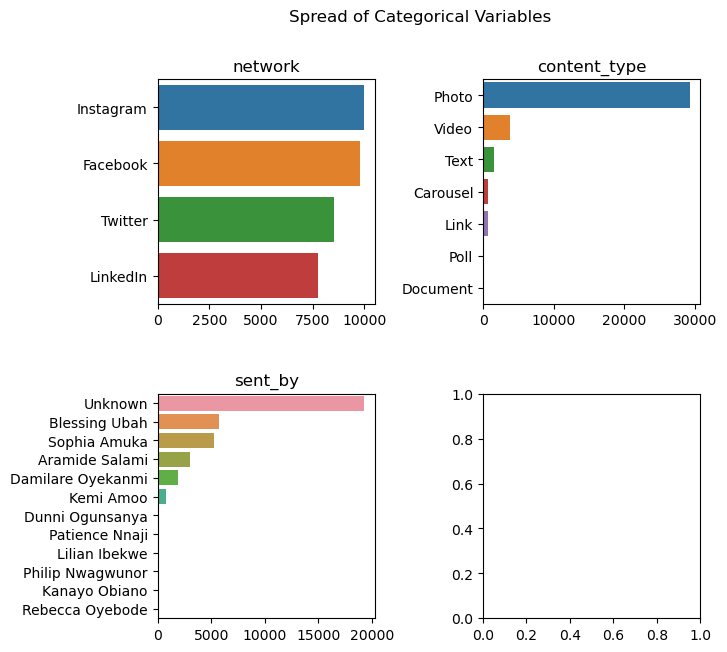

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.5)
cat_names = ['network', 'content_type', 'sent_by']

for ax, col, name in zip(axes.ravel(), cat_cols, cat_names):
    sns.countplot(data=df, y=col, ax=ax, orient='h',
                  order=df[col].value_counts(ascending=False).index)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)
    
plt.suptitle('Spread of Categorical Variables')
plt.show()

**Initial Findings on Categorical Variables**
* The social media site with the most posts in our dataset is `Instagram` with about 10,000 records. However, all records have posts in excess of 7500 in the dataframe.
* Photo is significantly the most popular content type.
* Most posts were sent by an unknown sender. 

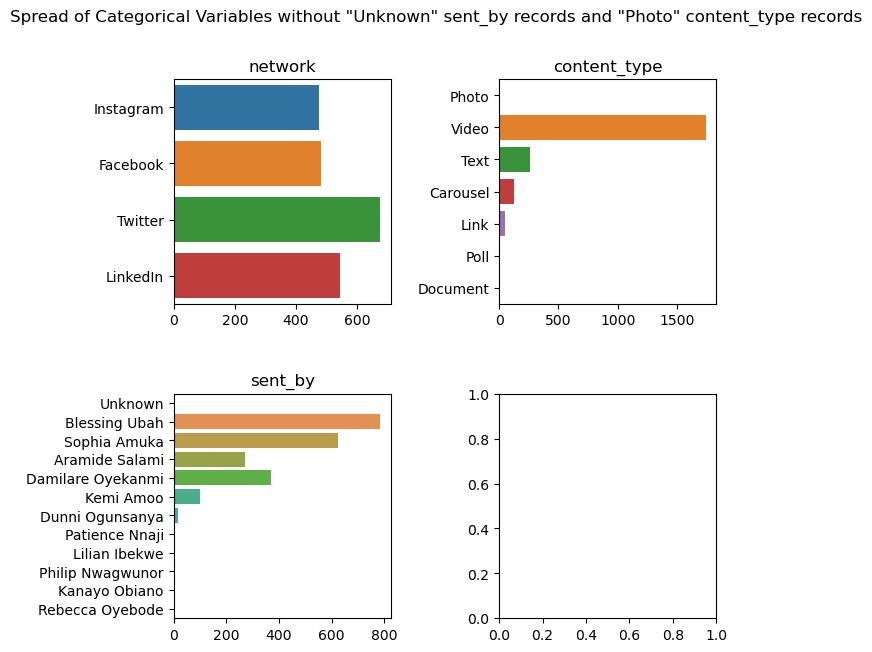

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.5)
cat_names = ['network', 'content_type', 'sent_by']

for ax, col, name in zip(axes.ravel(), cat_cols, cat_names):
    sns.countplot(data=df.query('sent_by != "Unknown" and content_type != "Photo"'), y=col, ax=ax, orient='h', order=df[col].value_counts(ascending=False).index)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(name)

plt.suptitle('Spread of Categorical Variables without "Unknown" sent_by records and "Photo" content_type records')
plt.show()

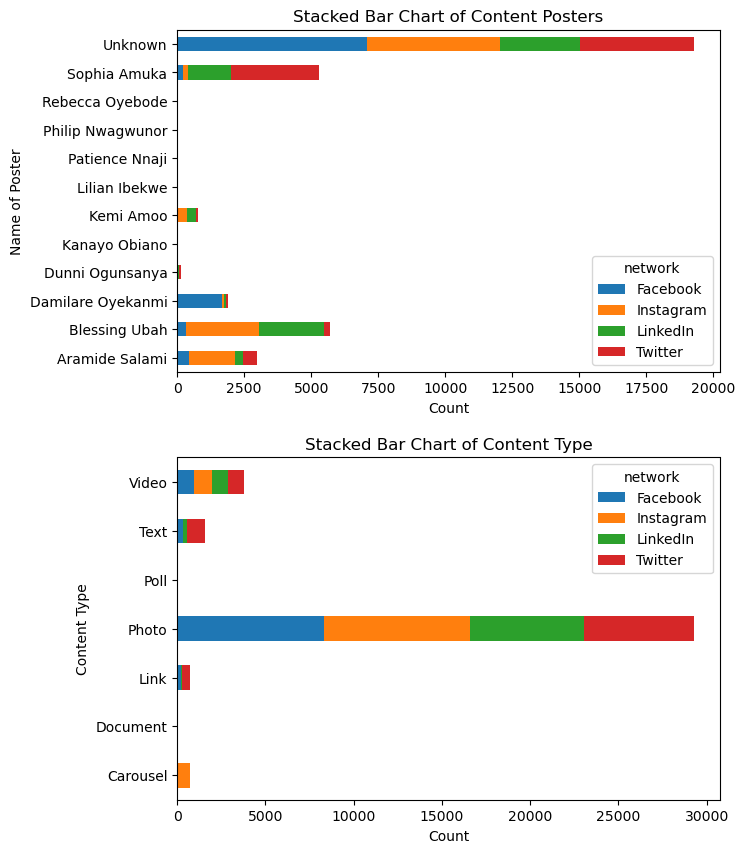

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10))
fig.subplots_adjust(hspace=0.25)

pd.crosstab(df.sent_by, df.network).plot(kind='barh', stacked=True, ax=axes[0])
axes[0].set_title('Stacked Bar Chart of Content Posters')
axes[0].set_ylabel('Name of Poster')
axes[0].set_xlabel('Count')

pd.crosstab(df.content_type, df.network).plot(kind='barh', stacked=True, ax=axes[1])
axes[1].set_title('Stacked Bar Chart of Content Type')
axes[1].set_ylabel('Content Type')
axes[1].set_xlabel('Count')

plt.show()

When stacked by `network`, some interesting trends arise:
* Blessing Ubah, unlike other posters, makes significantly more posts on LinkedIn than on Twitter
* Twitter features significantly more text posts than LinkedIn, more than for all other content type counts visible on the chart.

**Key Questions**

* What are the most engaging types of posts?

Poll is the most engaging content type for impressions. However, there are only 2 poll-based records and they have no post content. Text posts are the most engaging by reach and Poll posts have the highest engagements.

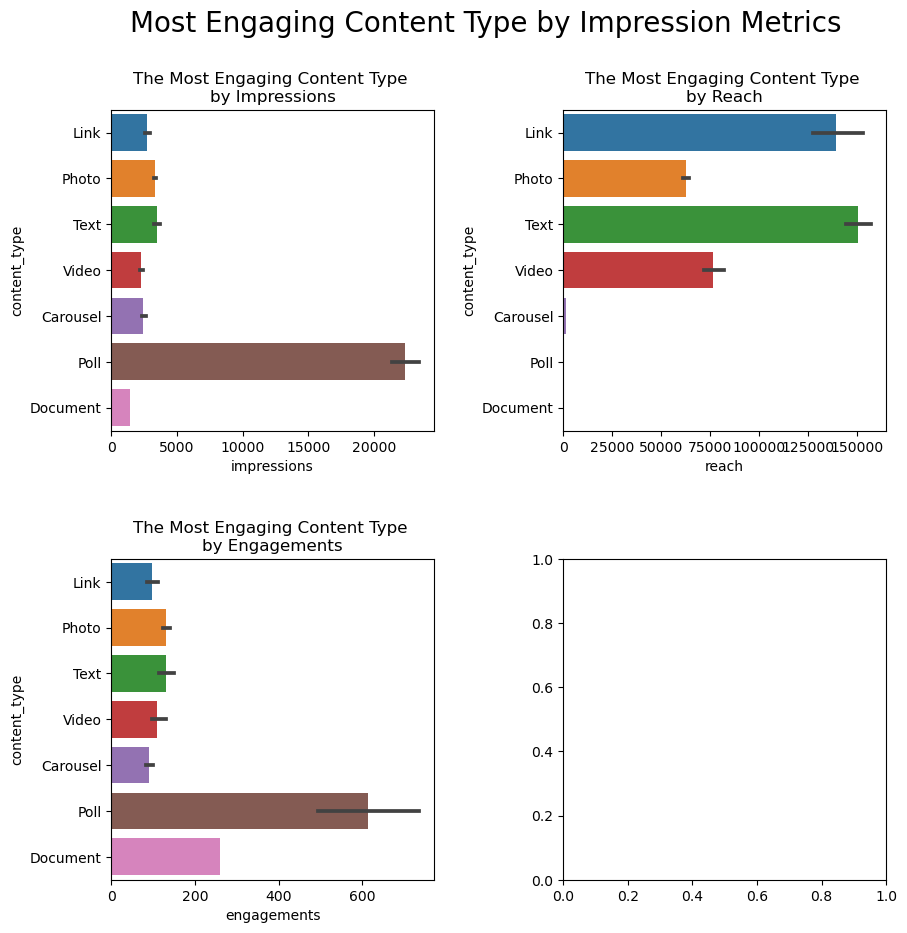

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    sns.barplot(data=df, x=name, y='content_type', ax=ax, orient='h')
    ax.set_title(f'The Most Engaging Content Type \nby {name.title()}')

plt.suptitle('Most Engaging Content Type by Impression Metrics', fontsize=20)
plt.show()

In [78]:
df.query('content_type=="Poll"')

network content_type  sent_by     post  \
date                                                           
2023-04-24 11:26:00  LinkedIn         Poll  Unknown  no post   
2023-06-01 15:01:00  LinkedIn         Poll  Unknown  no post   

                        linked_content  impressions  organic_impressions  \
date                                                                       
2023-04-24 11:26:00  no linked content      23379.0              23379.0   
2023-06-01 15:01:00  no linked content      21335.0              21335.0   

                     viral_impressions  non_viral_impressions  \
date                                                            
2023-04-24 11:26:00                0.0                    0.0   
2023-06-01 15:01:00                0.0                    0.0   

                     paid_impressions  ...  unique_organic_video_views  \
date                                   ...                               
2023-04-24 11:26:00               0.0  ...                         0.0   
2023-06-01 15:01:00               0.0  ...                         0.0   

                     unique_paid_video_views  unique_10_second_video_views  \
date                                                                         
2023-04-24 11:26:00                      0.0                           0.0   
2023-06-01 15:01:00                      0.0                           0.0   

                     unique_full_video_views  unique_organic_95%_video_views  \
date                                                                           
2023-04-24 11:26:00                      0.0                             0.0   
2023-06-01 15:01:00                      0.0                             0.0   

                     unique_paid_95%_video_views     tags  hashtags  \
date                                                                  
2023-04-24 11:26:00                          0.0  no tags        []   
2023-06-01 15:01:00                          0.0  no tags        []   

                     character_count  word_count  
date                                              
2023-04-24 11:26:00              0.0         0.0  
2023-06-01 15:01:00              0.0         0.0  

[2 rows x 112 columns]

Statistical Tests:

We'll conduct some tests to confirm the statistical significance of these charts. We'll first use the Analysis of Variance (ANOVA) test. ANOVA tests whether there are any statistically significant differences among the means of the numeric variable across the categorical groups. In our case we'll be testing whether there are any statistically significant differences among the means of the means of [impression, engagements, reach], ehen classified across different content types.

The ANOVA test returns an f-statistic and a p-value. 
- The F-statistic is a measure of the ratio of the between-group variance to the within-group variance. It indicates how much the variance in the dependent variable (in this instance, either impressions, engagement, or reach) can be attributed to the categorical variable (content type). Higher F-values suggest larger differences among group means relative to the variation within each group implying that there might be significant differences among group means.
- The p-value associated with the F-statistic tells us the probability of observing the observed F-statistic by random chance.
Smaller p-values (typically less than a chosen significance level, often 0.05) indicate stronger evidence that the F-statistic is not due to chance, i.e. it is statistically significant. This indicates that there are significant differences among the group means.

In [79]:
df.content_type.unique()

array(['Link', 'Photo', 'Text', 'Video', 'Carousel', 'Poll', 'Document'],
      dtype=object)

In [80]:
from scipy.stats import f_oneway

lnk = df.loc[df.content_type=='Link', 'impressions']
pho = df.loc[df.content_type=='Photo', 'impressions']
txt = df.loc[df.content_type=='Text', 'impressions']
vid = df.loc[df.content_type=='Video', 'impressions']
car = df.loc[df.content_type=='Carousel', 'impressions']
pol = df.loc[df.content_type=='Poll', 'impressions']
doc = df.loc[df.content_type=='Document', 'impressions']

f_stat, p_value = f_oneway(lnk, pho, txt, vid, car, pol, doc)

print('Impressions v. Content Type')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Content Type
F-Statistic: 44.904
P-Value: 4.685334090909321e-55


In [81]:
lnk = df.loc[df.content_type=='Link', 'engagements']
pho = df.loc[df.content_type=='Photo', 'engagements']
txt = df.loc[df.content_type=='Text', 'engagements']
vid = df.loc[df.content_type=='Video', 'engagements']
car = df.loc[df.content_type=='Carousel', 'engagements']
pol = df.loc[df.content_type=='Poll', 'engagements']
doc = df.loc[df.content_type=='Document', 'engagements']

f_stat, p_value = f_oneway(lnk, pho, txt, vid, car, pol, doc)

print('Engagements v. Content Type')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Engagements v. Content Type
F-Statistic: 1.201
P-Value: 0.3020611620705095


In [82]:
lnk = df.loc[df.content_type=='Link', 'reach']
pho = df.loc[df.content_type=='Photo', 'reach']
txt = df.loc[df.content_type=='Text', 'reach']
vid = df.loc[df.content_type=='Video', 'reach']
car = df.loc[df.content_type=='Carousel', 'reach']
pol = df.loc[df.content_type=='Poll', 'reach']
doc = df.loc[df.content_type=='Document', 'reach']

f_stat, p_value = f_oneway(lnk, pho, txt, vid, car, pol, doc)

print('Reach v. Content Type')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Reach v. Content Type
F-Statistic: 195.701
P-Value: 1.973390643751267e-246


When reach or impressions is compared to the content_type categorical feature, the resulting f-statistic and p-value imply that the variation among group means is not likely due to chance and is statistically significant. The inverse is the case for engagaments.

We can conclude that polls will generate the highest impressions and text posts will generate the highest reach. This is despite the fact that photo is the content type the user posts the most.

**Key Questions**
* Which platform yields the highest engagement for the client?

Facebook provides the highest impression and engagements and Twitter provides the highest reach.

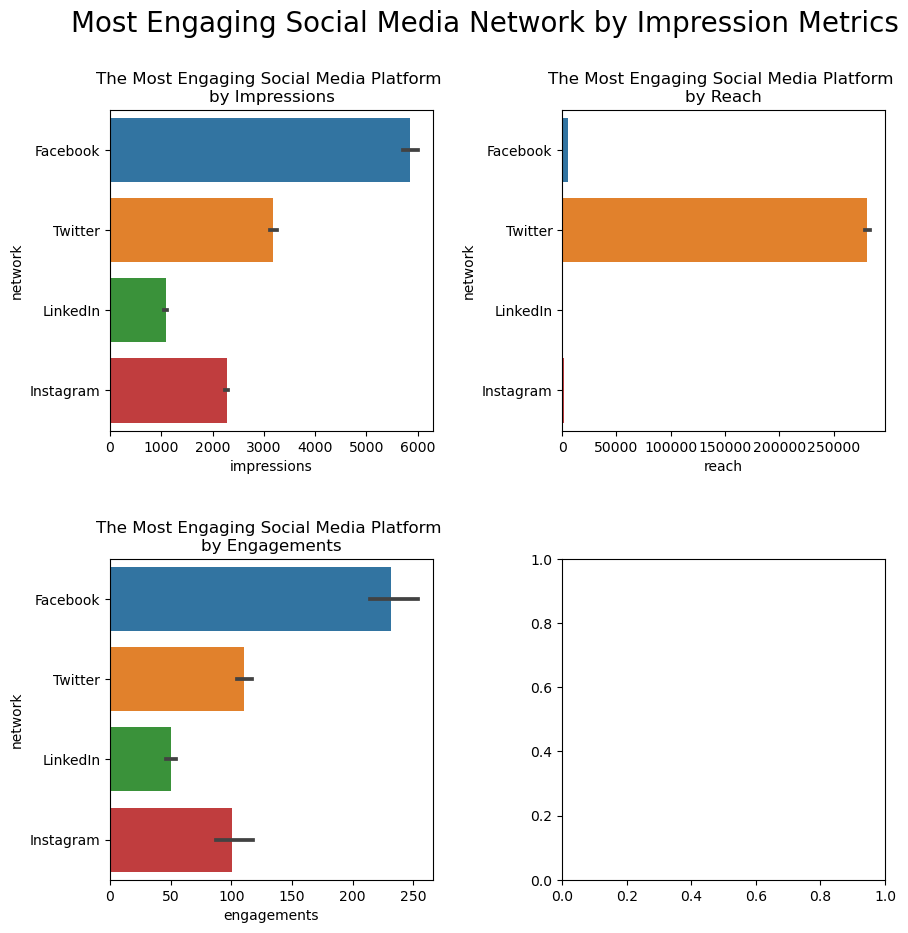

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    sns.barplot(data=df, x=name, y='network', ax=ax, orient='h')
    ax.set_title(f'The Most Engaging Social Media Platform \nby {name.title()}')

plt.suptitle('Most Engaging Social Media Network by Impression Metrics', fontsize=20)
plt.show()

Statistical Tests: ANOVA

In [84]:
df.network.unique()

array(['Facebook', 'Twitter', 'LinkedIn', 'Instagram'], dtype=object)

In [85]:
fb = df.loc[df.network=='Facebook', 'impressions']
tw = df.loc[df.network=='Twitter', 'impressions']
li = df.loc[df.network=='LinkedIn', 'impressions']
ig = df.loc[df.network=='Instagram', 'impressions']

f_stat, p_value = f_oneway(fb, tw, li, ig)

print('Impressions v. Social Media Platform')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Social Media Platform
F-Statistic: 2260.482
P-Value: 0.0


In [86]:
fb = df.loc[df.network=='Facebook', 'engagements']
tw = df.loc[df.network=='Twitter', 'engagements']
li = df.loc[df.network=='LinkedIn', 'engagements']
ig = df.loc[df.network=='Instagram', 'engagements']

f_stat, p_value = f_oneway(fb, tw, li, ig)

print('Impressions v. Social Media Platform')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Social Media Platform
F-Statistic: 107.516
P-Value: 2.6683347837541804e-69


In [87]:
fb = df.loc[df.network=='Facebook', 'reach']
tw = df.loc[df.network=='Twitter', 'reach']
li = df.loc[df.network=='LinkedIn', 'reach']
ig = df.loc[df.network=='Instagram', 'reach']

f_stat, p_value = f_oneway(fb, tw, li, ig)

print('Reach v. Social Media Platform')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Reach v. Social Media Platform
F-Statistic: 64477.094
P-Value: 0.0


When impressions, engagaments or reach is compared to the content_type categorical feature, the resulting f-statistic and p-value imply that the variation among group means is not likely due to chance and is statistically significant. 

We can conclude that Facebook yields the highest engagement for the client, despite the fact that Instagram is the platform the user makes use of the most.

**Key Questions**

* Which sender posts the most engaging posts?

Posts sent by Damilare Oyekanmi have the highest impressions. Posts sent by Philip Nwagwunor, Kanayo Obiano, Rebecca Oyebode and Lilian Ibekwe have the highest reach. Posts with an unknown sender have the highest engagements. This does not provide much information regarding strategy for driving engagement using a particular sender.

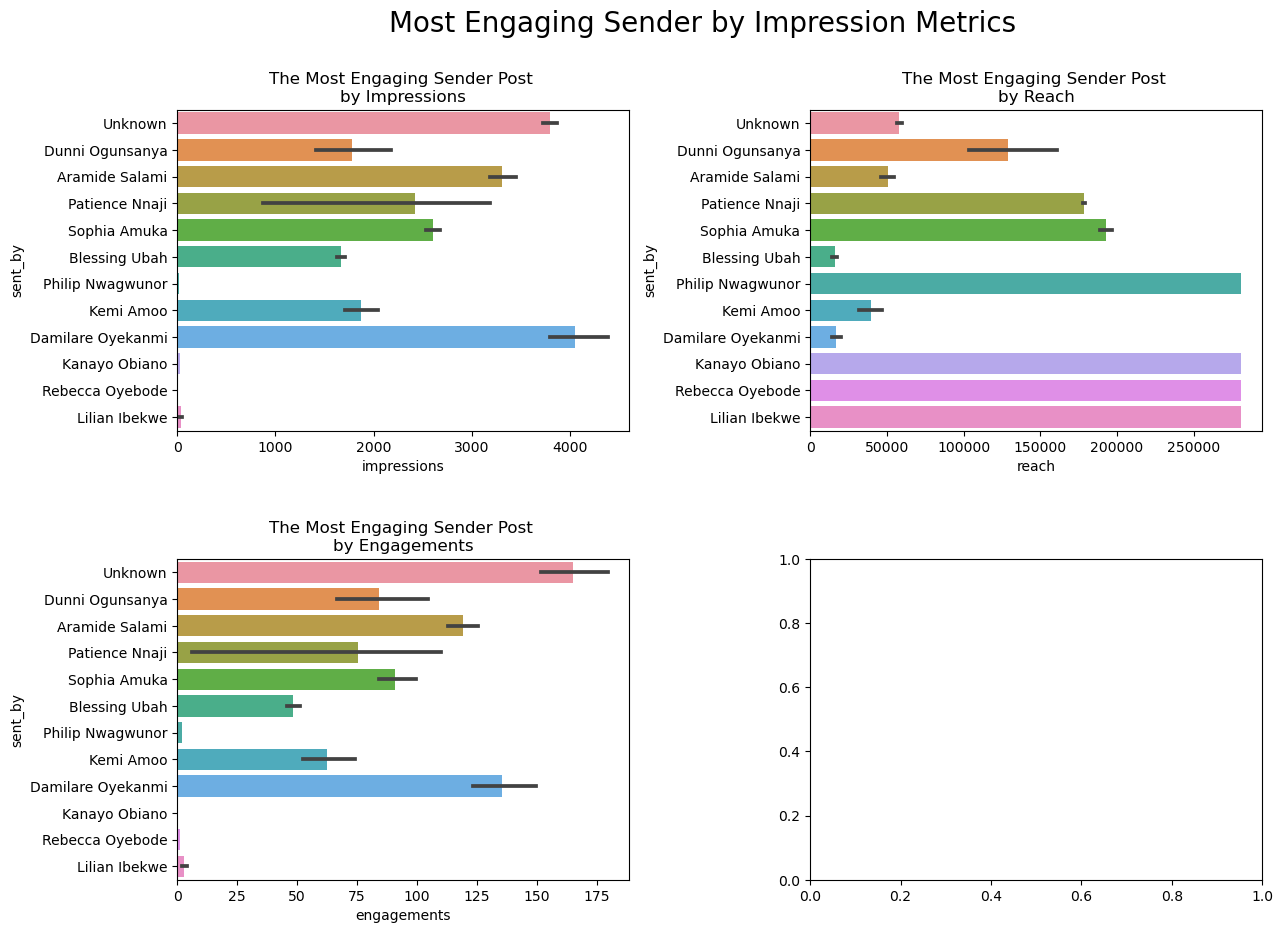

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    sns.barplot(data=df, x=name, y='sent_by', ax=ax, orient='h')
    ax.set_title(f'The Most Engaging Sender Post \nby {name.title()}')

plt.suptitle('Most Engaging Sender by Impression Metrics', fontsize=20)
plt.show()

Statistical Tests: ANOVA

In [89]:
df.sent_by.unique()

array(['Unknown', 'Dunni Ogunsanya', 'Aramide Salami', 'Patience Nnaji',
       'Sophia Amuka', 'Blessing Ubah', 'Philip Nwagwunor', 'Kemi Amoo',
       'Damilare Oyekanmi', 'Kanayo Obiano', 'Rebecca Oyebode',
       'Lilian Ibekwe'], dtype=object)

In [90]:
uk = df.loc[df.sent_by=='Unknown', 'impressions']
dog = df.loc[df.sent_by=='Dunni Ogunsanya', 'impressions']
asl = df.loc[df.sent_by=='Aramide Salami', 'impressions']
pn = df.loc[df.sent_by=='Patience Nnaji', 'impressions']
sa = df.loc[df.sent_by=='Sophia Amuka', 'impressions']
bu = df.loc[df.sent_by=='Blessing Ubah', 'impressions']
phn = df.loc[df.sent_by=='Philip Nwagwunor', 'impressions']
ka = df.loc[df.sent_by=='Kemi Amoo', 'impressions']
doy = df.loc[df.sent_by=='Damilare Oyekanmi', 'impressions']
ko = df.loc[df.sent_by=='Kanayo Obiano', 'impressions']
ro = df.loc[df.sent_by=='Rebecca Oyebode', 'impressions']
li = df.loc[df.sent_by=='Lilian Ibekwe', 'impressions']

f_stat, p_value = f_oneway(uk, dog, asl, pn, sa, bu, phn, ka, doy, ko, ro, li)

print('Impressions v. Sender')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Sender
F-Statistic: 120.682
P-Value: 6.689959748389004e-273


In [91]:
uk = df.loc[df.sent_by=='Unknown', 'engagements']
dog = df.loc[df.sent_by=='Dunni Ogunsanya', 'engagements']
asl = df.loc[df.sent_by=='Aramide Salami', 'engagements']
pn = df.loc[df.sent_by=='Patience Nnaji', 'engagements']
sa = df.loc[df.sent_by=='Sophia Amuka', 'engagements']
bu = df.loc[df.sent_by=='Blessing Ubah', 'engagements']
phn = df.loc[df.sent_by=='Philip Nwagwunor', 'engagements']
ka = df.loc[df.sent_by=='Kemi Amoo', 'engagements']
doy = df.loc[df.sent_by=='Damilare Oyekanmi', 'engagements']
ko = df.loc[df.sent_by=='Kanayo Obiano', 'engagements']
ro = df.loc[df.sent_by=='Rebecca Oyebode', 'engagements']
li = df.loc[df.sent_by=='Lilian Ibekwe', 'engagements']

f_stat, p_value = f_oneway(uk, dog, asl, pn, sa, bu, phn, ka, doy, ko, ro, li)

print('Engagements v. Sender')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Engagements v. Sender
F-Statistic: 13.268
P-Value: 1.1386325334241122e-25


In [92]:
uk = df.loc[df.sent_by=='Unknown', 'reach']
dog = df.loc[df.sent_by=='Dunni Ogunsanya', 'reach']
asl = df.loc[df.sent_by=='Aramide Salami', 'reach']
pn = df.loc[df.sent_by=='Patience Nnaji', 'reach']
sa = df.loc[df.sent_by=='Sophia Amuka', 'reach']
bu = df.loc[df.sent_by=='Blessing Ubah', 'reach']
phn = df.loc[df.sent_by=='Philip Nwagwunor', 'reach']
ka = df.loc[df.sent_by=='Kemi Amoo', 'reach']
doy = df.loc[df.sent_by=='Damilare Oyekanmi', 'reach']
ko = df.loc[df.sent_by=='Kanayo Obiano', 'reach']
ro = df.loc[df.sent_by=='Rebecca Oyebode', 'reach']
li = df.loc[df.sent_by=='Lilian Ibekwe', 'reach']

f_stat, p_value = f_oneway(uk, dog, asl, pn, sa, bu, phn, ka, doy, ko, ro, li)

print('Reach v. Sender')
print(f'F-Statistic: {f_stat:.3f}')
print(f'P-Value: {p_value}')

Reach v. Sender
F-Statistic: 712.846
P-Value: 0.0


When impressions, engagaments or reach is compared to the sent_by categorical feature, the resulting f-statistic and p-value imply that the variation among group means is not likely due to chance and is statistically significant. 

We can conclude that posts sent by Damilare Oyekanmi have the highest impressions, posts sent by Philip Nwagwunor, Kanayo Obiano, Rebecca Oyebode and Lilian Ibekwe have the highest reach and posts with an unknown sender have the highest engagements. This is despite the fact that unknown sender is the highest sender in the dataset.

**Trend Analysis: Key Questions**
* What are the peak times for user engagement? (i.e. best date and time for principal impression metrics)

Generally, the trendline seems flat across impression, reach and engagements metrics.


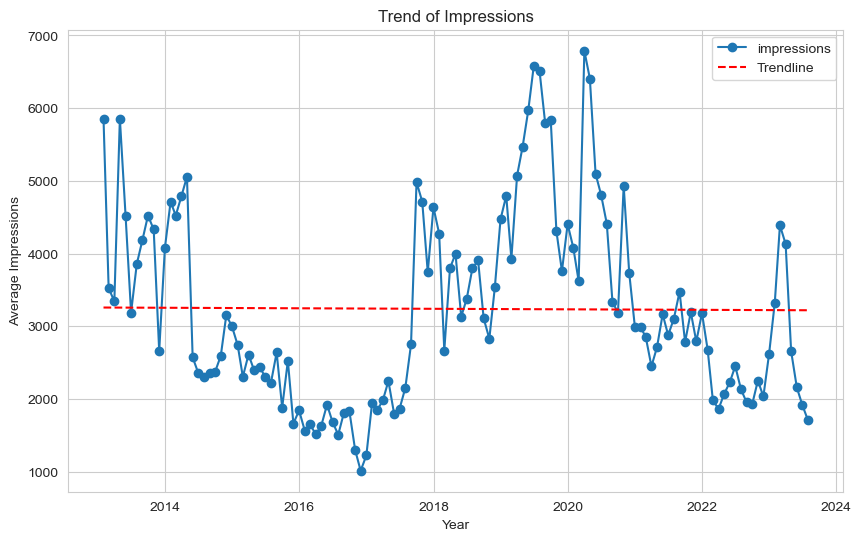

In [93]:
sns.set_style("whitegrid")
monthly_mean = df.impressions.resample('M').mean().interpolate()

# Create the line plot for the original data
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label='impressions')

# Fit a linear trendline using NumPy's polyfit
x_values = pd.to_numeric(monthly_mean.index) / 10**9  # Convert timestamps to seconds
coefficients = np.polyfit(x_values, monthly_mean, 1)
slope, intercept = coefficients

# Create a line plot for the trendline
trendline_values = slope * x_values + intercept
# Convert back to datetime
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
plt.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

# Add labels and a legend (optional)
plt.xlabel('Year')
plt.ylabel('Average Impressions')
plt.title('Trend of Impressions')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

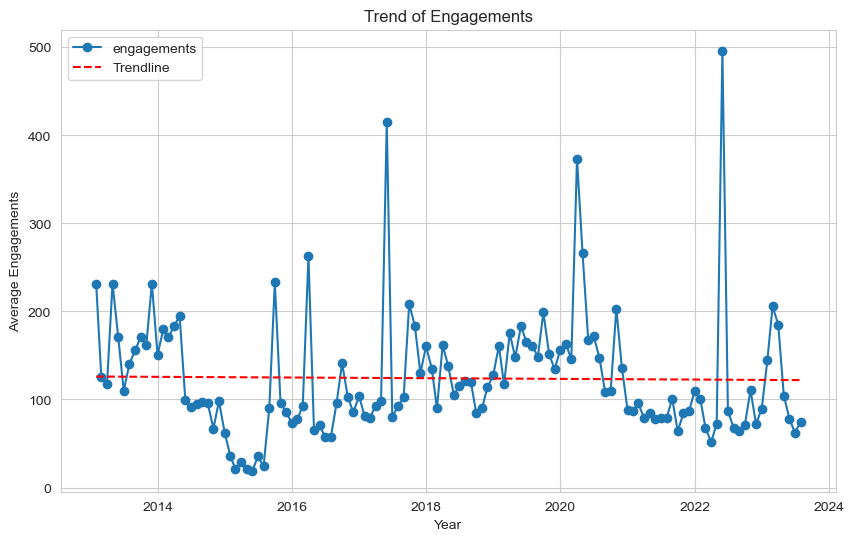

In [94]:
sns.set_style("whitegrid")
monthly_mean = df.engagements.resample('M').mean().interpolate()

plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label='engagements')

x_values = pd.to_numeric(monthly_mean.index) / 10**9
coefficients = np.polyfit(x_values, monthly_mean, 1)
slope, intercept = coefficients

trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
plt.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

plt.xlabel('Year')
plt.ylabel('Average Engagements')
plt.title('Trend of Engagements')
plt.legend()
plt.grid(True)
plt.show()

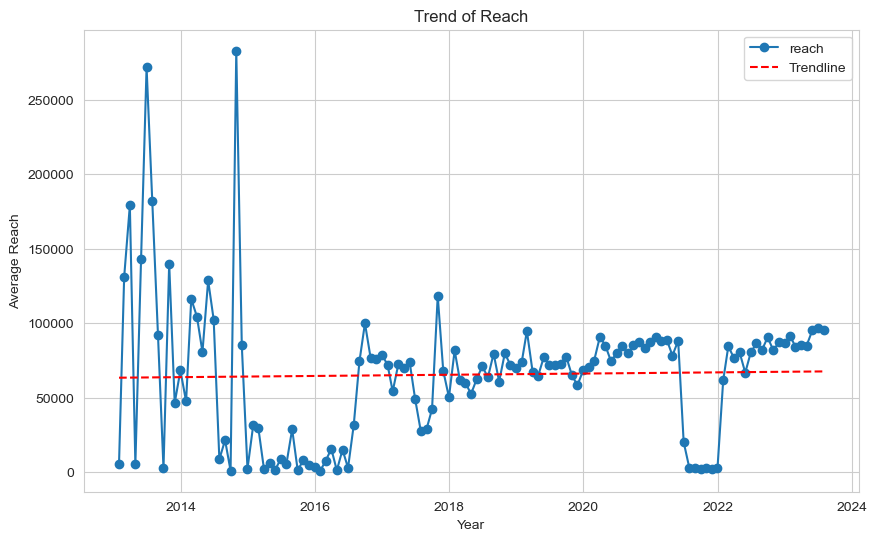

In [95]:
sns.set_style("whitegrid")
monthly_mean = df.reach.resample('M').mean().interpolate()

plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label='reach')

x_values = pd.to_numeric(monthly_mean.index) / 10**9
coefficients = np.polyfit(x_values, monthly_mean, 1)
slope, intercept = coefficients

trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
plt.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

plt.xlabel('Year')
plt.ylabel('Average Reach')
plt.title('Trend of Reach')
plt.legend()
plt.grid(True)
plt.show()

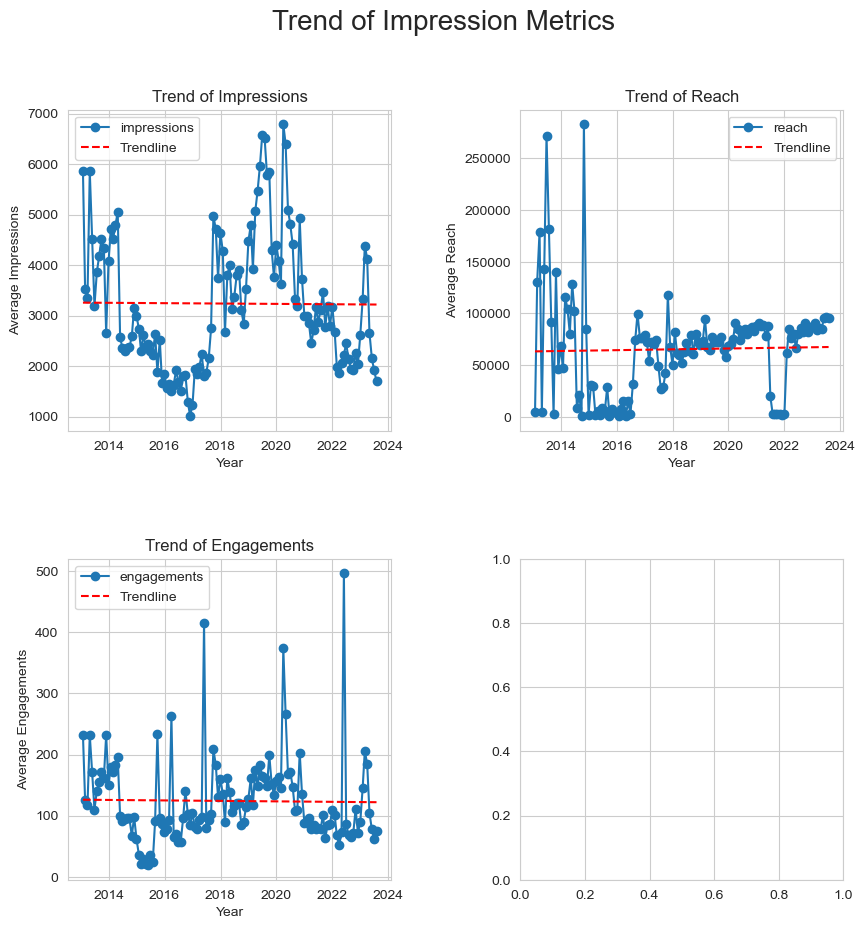

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    monthly_mean = df[name].resample('M').mean().interpolate()
    ax.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label=name)
    x_values = pd.to_numeric(monthly_mean.index) / 10**9
    coefficients = np.polyfit(x_values, monthly_mean, 1)
    slope, intercept = coefficients

    trendline_values = slope * x_values + intercept
    trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
    ax.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Average {name.title()}')
    ax.set_title(f'Trend of {name.title()}')
    ax.legend()

plt.suptitle('Trend of Impression Metrics', fontsize=20)
plt.grid(True)
plt.show()

When we reclassified by Hour, the trendline shows that each metric sees increased values as the hours increase. Peak times for impression metrics are:
- 9pm for Impressions & Engagements
- 8am for reach

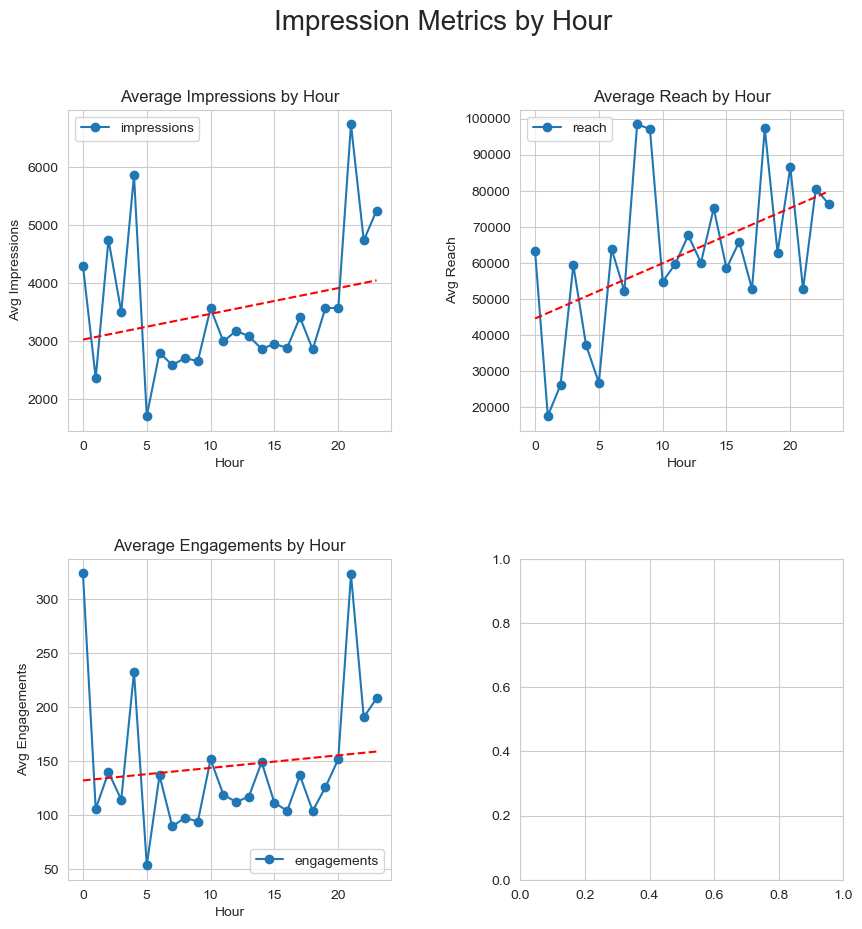

In [97]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    hour_mean = df.groupby(df.index.hour)[name].mean().reset_index().set_index('date')
    hour_mean.plot(
    xlabel='Hour', ylabel=f'Avg {name.title()}', linestyle='-', 
    marker='o', title=f'Average {name.title()} by Hour',
    label=name, ax=ax
    )
    x_values = hour_mean.index
    coefficients = np.polyfit(x_values, hour_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    ax.plot(x_values, trendline_values, label='Trendline', linestyle='--', color='red')

plt.suptitle('Impression Metrics by Hour', fontsize=20)
plt.show()

Statistical Tests:

We'll be conducting 3 statistical tests to test the null hypothesis raised by the charts, that there is no statistically significant relationship between time (hour) and the relevant metric:
- Correlation analysis, which measures the strength and direction of the linear relationship between two continuous numeric variables. The Pearson correlation coefficient (r) is commonly used for normally distributed data, while the Spearman rank correlation coefficient (ρ) is suitable for non-normally distributed data or when the relationship may be nonlinear.

- Linear regression, which models the relationship between two numeric variables by fitting a linear equation to the data. It helps us understand how one variable changes as the other changes. Linear regression coefficients helps us assess the strength and direction of the relationship.

- T-Test or Mann-Whitney U Test compares the means of two numeric variables between two groups to determine whether there is a significant difference between the two groups. T-test is for normally distributed data and Mann-Whitney U test is for non-normally distributed data. A higher absolute statistic value (whether t-statistic or U-statistic)  is often associated with a smaller p-value, which indicates stronger evidence against the null hypothesis, i.e. we would accept the visuals from our plot. 

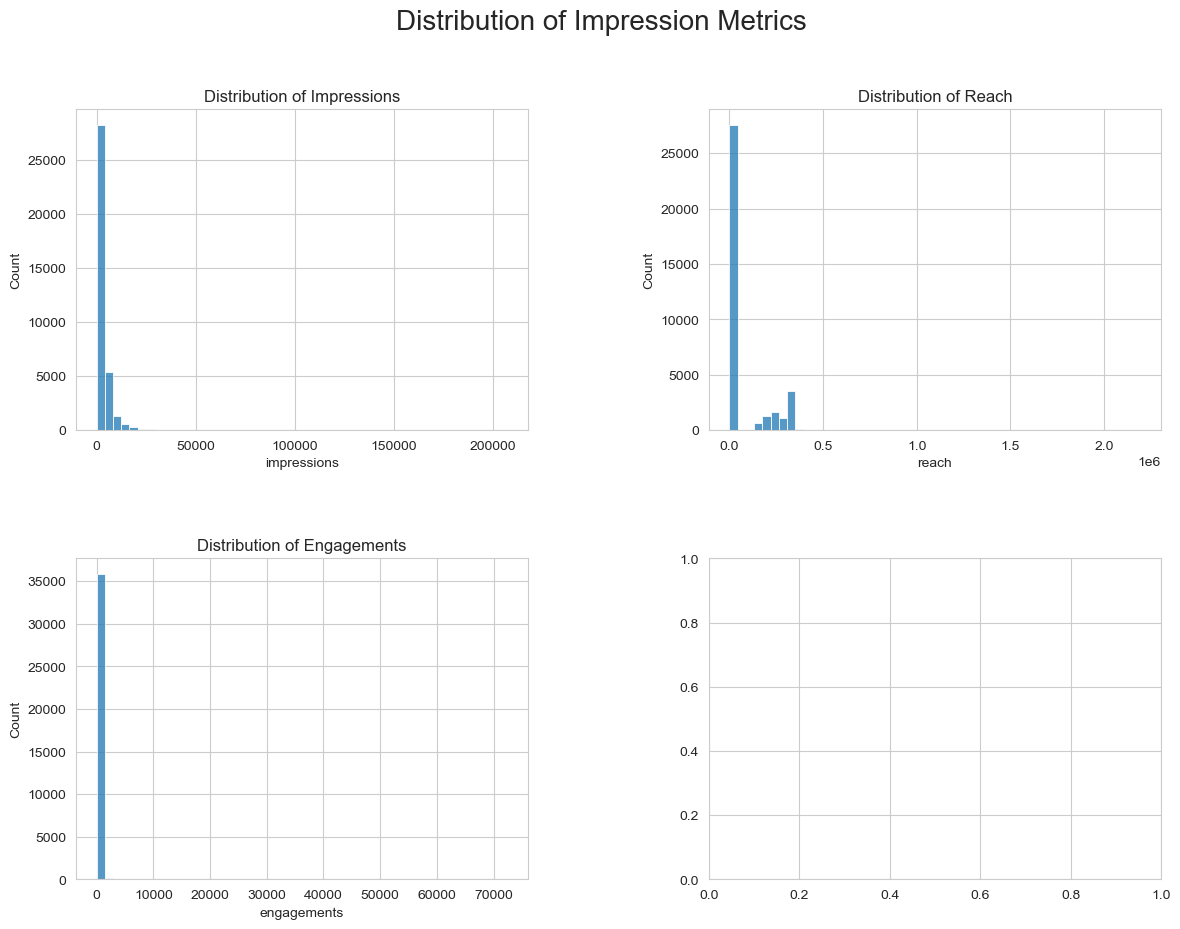

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    sns.histplot(data=df, x=name, bins=50, ax=ax)
    ax.set_title(f'Distribution of {name.title()}')

plt.suptitle('Distribution of Impression Metrics', fontsize=20)
plt.show()

Pearson Correlation:

The low correlation coefficients and the statistically significant p-values implies that the relationship between the impression metrics and hour is not linear.

In [99]:
correlation_coefficient, p_value = pearsonr(df.index.hour, df.impressions)
print('Impressions v. Hour')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.hour, df.engagements)
print('Engagements v. Hour')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.hour, df.reach)
print('Reach v. Hour')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Hour
Correlation Coefficient: 0.060
P-Value: 7.369279358823349e-30


Engagements v. Hour
Correlation Coefficient: 0.017
P-Value: 0.001150888901232051


Reach v. Hour
Correlation Coefficient: -0.007
P-Value: 0.15940362087602777


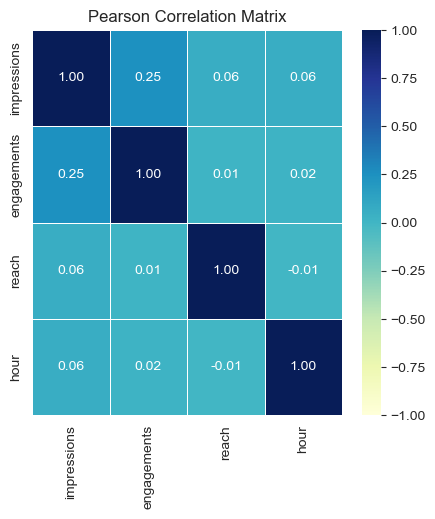

In [100]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(hour=df.index.hour)[[
        'impressions', 'engagements', 'reach', 'hour'
        ]].corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Pearson Correlation Matrix');

Spearman Rank Correlation:

According to Pearson and Spearman Rank Correlation, there is no correlation between hour of posting and the impression metrics.

In [101]:
rho, p_value = spearmanr(df.index.hour, df.impressions)
print('Impressions v. Hour')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.hour, df.engagements)
print('Engagements v. Hour')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.hour, df.reach)
print('Reach v. Hour')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")


Impressions v. Hour
Spearman's rho (ρ): 0.068
P-value: 7.110486932200647e-38


Engagements v. Hour
Spearman's rho (ρ): 0.054
P-value: 1.3194053181149577e-24


Reach v. Hour
Spearman's rho (ρ): 0.030
P-value: 7.0185008358835495e-09


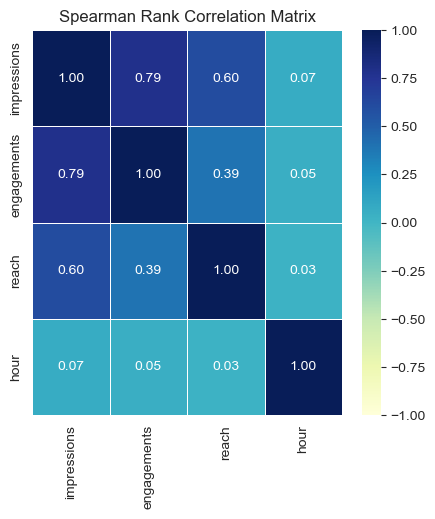

In [102]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(hour=df.index.hour)[[
        'impressions', 'engagements', 'reach', 'hour'
        ]].corr(numeric_only=True, method='spearman'),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Spearman Rank Correlation Matrix');

Linear Regression:

Impressions

In [103]:
data = df.assign(hour=df.index.hour)
formula = 'impressions ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     129.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           7.37e-30
Time:                        14:44:45   Log-Likelihood:            -3.5427e+05
No. Observations:               36092   AIC:                         7.085e+05
Df Residuals:                   36090   BIC:                         7.086e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2241.0483     88.210     25.406      0.0

Residuals, in the context of statistical modeling and regression analysis, are the differences between the observed or actual values of a dependent variable and the predicted values of that variable based on a statistical model. They represent the discrepancies or errors between what the model predicts and what is actually observed in the data.

RMSE (Root Mean Square Error) is a metric in statistics and machine learning used to measure the accuracy of a predictive model, particularly in the context of regression analysis or regression machine learning algorithms. RMSE quantifies the average magnitude of the errors or residuals between the predicted values and the actual (observed) values of the dependent variable. A lower RMSE indicates that the model's predictions are closer, on average, to the actual (observed) values of the dependent variable.

In our model, the standard deviation of the residuals is the RMSE of the model and will determine accuracy:

In [104]:
print('RMSE: ', np.std(results.resid))

RMSE:  4432.799382041727


R-squared (R²), also known as the coefficient of determination, is a statistical measure used in regression analysis to assess the goodness of fit of a regression model to the observed data. It quantifies the proportion of the variance in the dependent variable (in this case, the impression metrics) that is explained by the independent variables (in this case, time) in the model. 

In other words, R-squared tells us how well the independent variables account for the variability in the dependent variable. R-squared values range from 0 to 1, with higher values indicating a better fit. 

In [105]:
print('R_squared / Goodness of Fit: ', results.rsquared)

R_squared / Goodness of Fit:  0.003563513659722184


Residual plots visualize the linearity assumption. If the residuals appear randomly scattered around zero and show no discernible pattern, it suggests that the linear relationship assumption is met.

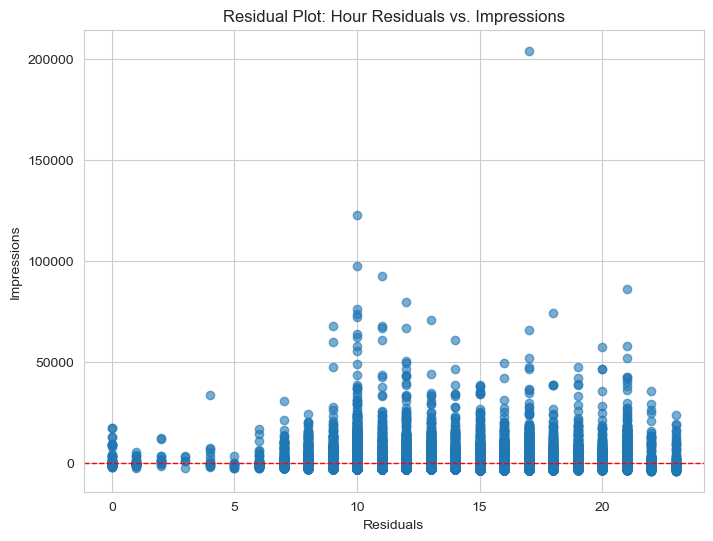

In [106]:
plt.figure(figsize=(8, 6))
plt.scatter(data.hour, results.resid, alpha=0.6)
plt.title("Residual Plot: Hour Residuals vs. Impressions")
plt.xlabel("Residuals")
plt.ylabel("Impressions")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [107]:
data = df.assign(hour=df.index.hour)
data['hour'] = data.hour ** 2
formula = 'impressions ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     173.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.89e-39
Time:                        14:44:45   Log-Likelihood:            -3.5425e+05
No. Observations:               36092   AIC:                         7.085e+05
Df Residuals:                   36090   BIC:                         7.085e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2621.7892     50.251     52.173      0.0

Engagements

In [108]:
data = df.assign(hour=df.index.hour)
formula = 'engagements ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.57
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00115
Time:                        14:44:45   Log-Likelihood:            -2.8829e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.1663     14.179      5.865      0.0

In [109]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  712.539452333983
R_squared / Goodness of Fit:  0.0002927727838598626


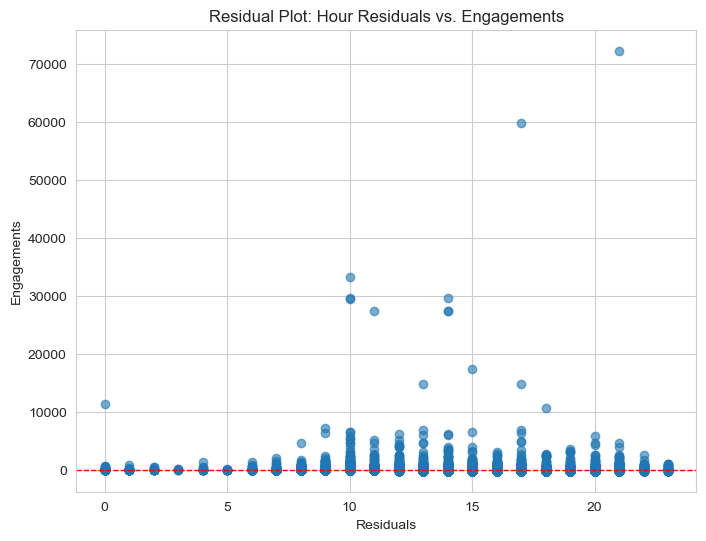

In [110]:
# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(data.hour, results.resid, alpha=0.6)
plt.title("Residual Plot: Hour Residuals vs. Engagements")
plt.xlabel("Residuals")
plt.ylabel("Engagements")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [111]:
data = df.assign(hour=df.index.hour)
data['hour'] = data.hour ** 2
formula = 'engagements ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.91
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           0.000113
Time:                        14:44:46   Log-Likelihood:            -2.8829e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     99.9750      8.082     12.370      0.0

Reach

In [112]:
data = df.assign(hour=df.index.hour)
formula = 'reach ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.980
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.159
Time:                        14:44:46   Log-Likelihood:            -4.7586e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.163e+04   2562.488     27.953      0.0

In [113]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  128772.37090114894
R_squared / Goodness of Fit:  5.485862274479114e-05


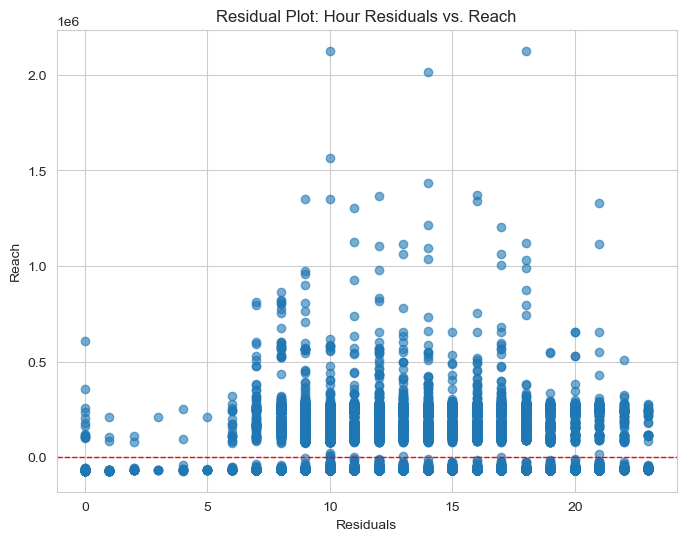

In [114]:
plt.figure(figsize=(8, 6))
plt.scatter(data.hour, results.resid, alpha=0.6)
plt.title("Residual Plot: Hour Residuals vs. Reach")
plt.xlabel("Residuals")
plt.ylabel("Reach")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [115]:
data = df.assign(hour=df.index.hour)
data['hour'] = data.hour ** 2
formula = 'reach ~ hour'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3722
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.542
Time:                        14:44:46   Log-Likelihood:            -4.7586e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.894e+04   1460.717     47.197      0.0

T-Test:

In [116]:
from scipy.stats import ttest_ind

group1_data = df.index.hour
group2_data = df.impressions

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Impressions v. Hour')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.hour
group2_data = df.engagements

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Engagements v. Hour')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.hour
group2_data = df.reach

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Reach v. Hour')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Hour
T-statistic: -136.637
P-value: 0.0


Engagements v. Hour
T-statistic: -30.399
P-value: 1.0721500775877559e-201


Reach v. Hour
T-statistic: -100.521
P-value: 0.0


Mann-Whitney U test:

In [117]:
from scipy.stats import mannwhitneyu

group1_data = df.index.hour
group2_data = df.impressions

u_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Impressions v. Hour')
print(f"U-statistic: {u_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.hour
group2_data = df.engagements

u_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Engagements v. Hour')
print(f"U-statistic: {u_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.hour
group2_data = df.reach

u_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Reach v. Hour')
print(f"U-statistic: {u_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Hour
U-statistic: 58905390.000
P-value: 0.0


Engagements v. Hour
U-statistic: 137914759.500
P-value: 0.0


Reach v. Hour
U-statistic: 422413876.500
P-value: 0.0


When we reclassified by Day, the trendline shows that impressions and reach sees decreased values as the month progresses, while engagements sees the inverse.

Peak days for impression metrics are:
- 17th for Impressions 
- 27th for Engagements
- 1st for Reach

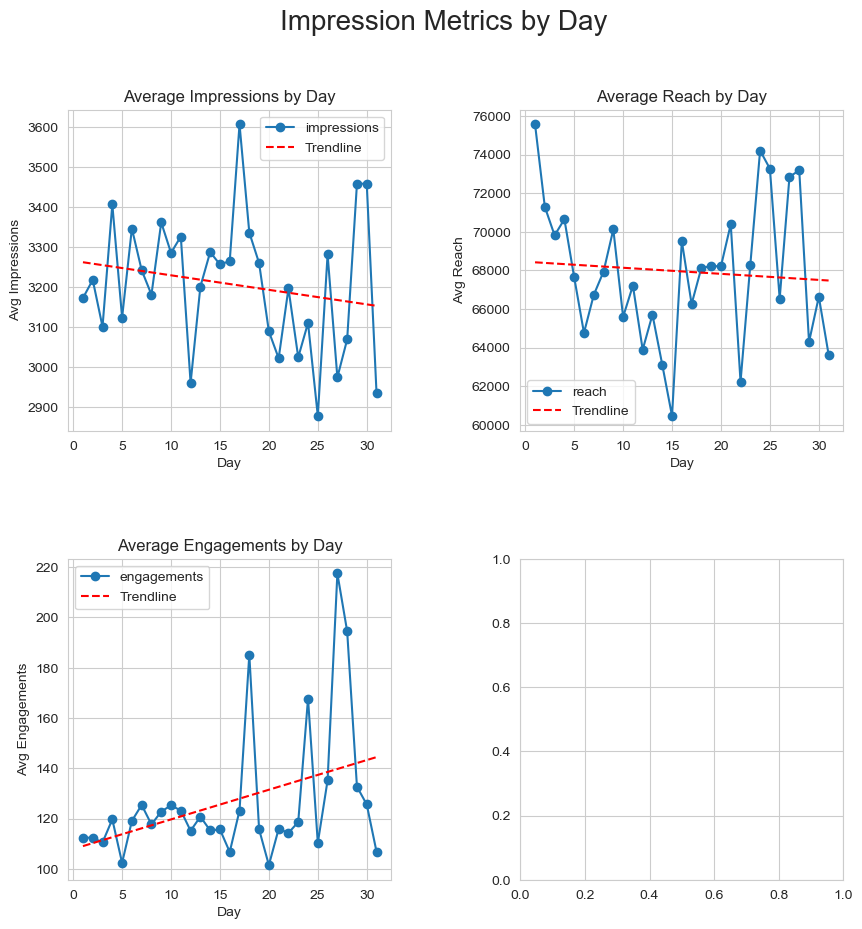

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    day_mean = df.groupby(df.index.day)[name].mean().reset_index().set_index('date')
    day_mean.plot(
    xlabel='Day', ylabel=f'Avg {name.title()}', linestyle='-', 
    marker='o', title=f'Average {name.title()} by Day',
    label=name, ax=ax
    )
    x_values = day_mean.index
    coefficients = np.polyfit(x_values, day_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    ax.plot(x_values, trendline_values, label='Trendline', linestyle='--', color='red')
    ax.legend()

plt.suptitle('Impression Metrics by Day', fontsize=20)
plt.show()

Statistical Tests:

Pearson Correlation

In [119]:
correlation_coefficient, p_value = pearsonr(df.index.day, df.impressions)
print('Impressions v. Day')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.day, df.engagements)
print('Engagements v. Day')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.day, df.reach)
print('Reach v. Day')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Day
Correlation Coefficient: -0.007
P-Value: 0.17897301945181537


Engagements v. Day
Correlation Coefficient: 0.017
P-Value: 0.0010263526482293375


Reach v. Day
Correlation Coefficient: -0.001
P-Value: 0.7919885762470708


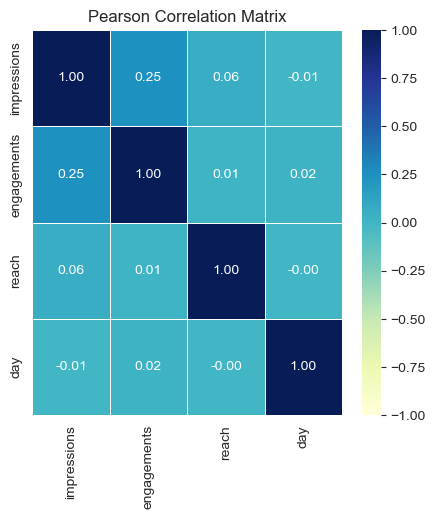

In [120]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(day=df.index.day)[[
        'impressions', 'engagements', 'reach', 'day'
        ]].corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Pearson Correlation Matrix');

Spearman Rank Correlation:

According to Pearson and Spearman Rank Correlation, there is no correlation between month of posting and the impression metrics.

In [121]:
rho, p_value = spearmanr(df.index.day, df.impressions)
print('Impressions v. Day')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.day, df.engagements)
print('Engagements v. Day')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.day, df.reach)
print('Reach v. Day')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")


Impressions v. Day
Spearman's rho (ρ): -0.012
P-value: 0.01990126276362677


Engagements v. Day
Spearman's rho (ρ): -0.007
P-value: 0.1805217474680901


Reach v. Day
Spearman's rho (ρ): -0.002
P-value: 0.6795975623950655


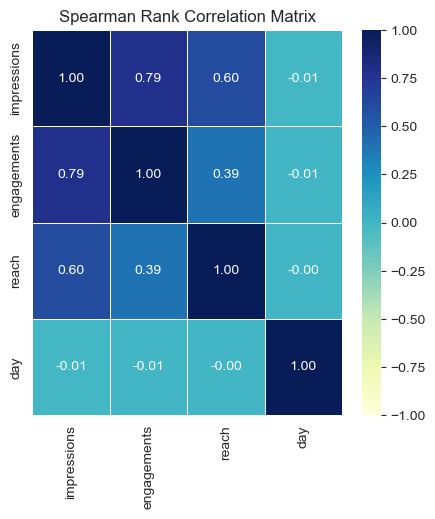

In [122]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(day=df.index.day)[[
        'impressions', 'engagements', 'reach', 'day'
        ]].corr(numeric_only=True, method='spearman'),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Spearman Rank Correlation Matrix');

Linear Regression:

Impressions

In [123]:
data = df.assign(day=df.index.day)
formula = 'impressions ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.806
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.179
Time:                        14:44:47   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3262.5377     47.164     69.174      0.0

In [124]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  4440.607605949177
R_squared / Goodness of Fit:  5.00446408154831e-05


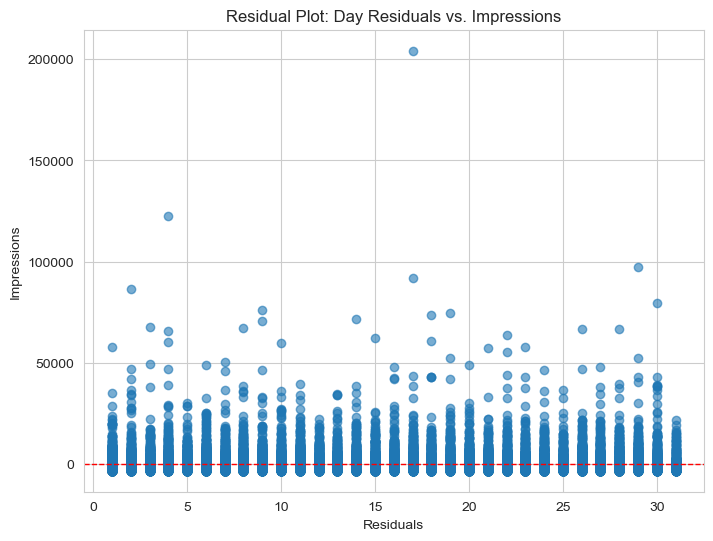

In [125]:
plt.figure(figsize=(8, 6))
plt.scatter(data.day, results.resid, alpha=0.6)
plt.title("Residual Plot: Day Residuals vs. Impressions")
plt.xlabel("Residuals")
plt.ylabel("Impressions")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [126]:
data = df.assign(day=df.index.day)
data['day'] = data.day ** 2
formula = 'impressions ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.133
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.144
Time:                        14:44:47   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3245.8993     35.188     92.245      0.0

Engagements

In [127]:
data = df.assign(day=df.index.day)
formula = 'engagements ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.78
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00103
Time:                        14:44:47   Log-Likelihood:            -2.8829e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    106.0383      7.568     14.011      0.0

In [128]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  712.5373610682958
R_squared / Goodness of Fit:  0.00029864095115095246


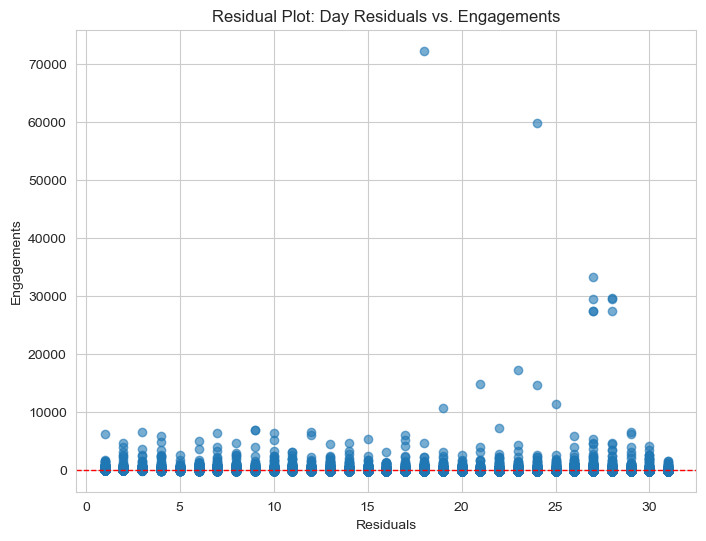

In [129]:
plt.figure(figsize=(8, 6))
plt.scatter(data.day, results.resid, alpha=0.6)
plt.title("Residual Plot: Day Residuals vs. Engagements")
plt.xlabel("Residuals")
plt.ylabel("Engagements")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [130]:
data = df.assign(day=df.index.day)
data['day'] = data.day ** 2
formula = 'engagements ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.57
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           0.000672
Time:                        14:44:47   Log-Likelihood:            -2.8829e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.2673      5.646     20.061      0.0

Reach

In [131]:
data = df.assign(day=df.index.day)
formula = 'reach ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06955
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.792
Time:                        14:44:47   Log-Likelihood:            -4.7586e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.518e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.847e+04   1367.747     50.057      0.0

In [132]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  128775.77909300828
R_squared / Goodness of Fit:  1.9272374439660567e-06


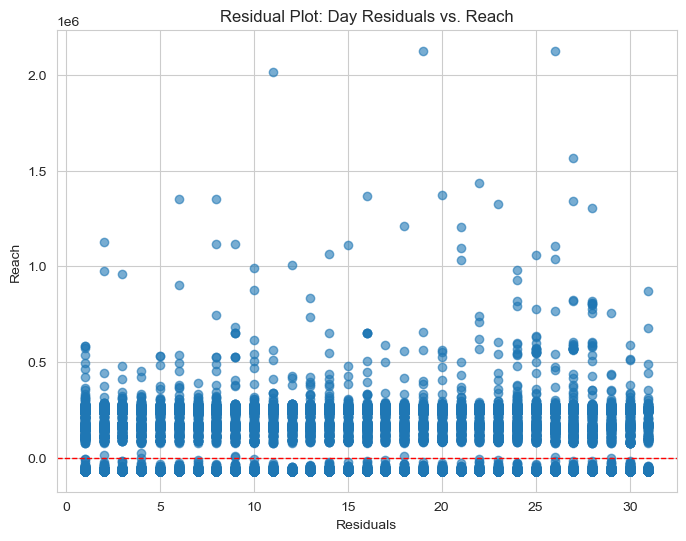

In [133]:
plt.figure(figsize=(8, 6))
plt.scatter(data.day, results.resid, alpha=0.6)
plt.title("Residual Plot: Day Residuals vs. Reach")
plt.xlabel("Residuals")
plt.ylabel("Reach")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [134]:
data = df.assign(day=df.index.day)
data['day'] = data.day ** 2
formula = 'reach ~ day'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07262
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.788
Time:                        14:44:47   Log-Likelihood:            -4.7586e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.518e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.795e+04   1020.437     66.586      0.0

T-test

In [135]:
group1_data = df.index.day
group2_data = df.impressions

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Impressions v. Day')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.day
group2_data = df.engagements

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Engagements v. Day')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.day
group2_data = df.reach

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Reach v. Day')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Day
T-statistic: -136.549
P-value: 0.0


Engagements v. Day
T-statistic: -29.853
P-value: 1.2384280932330824e-194


Reach v. Day
T-statistic: -100.518
P-value: 0.0


Mann-Whitney U-test:

In [136]:
group1_data = df.index.day
group2_data = df.impressions

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Impressions v. Day')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.day
group2_data = df.engagements

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Engagements v. Day')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.day
group2_data = df.reach

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Reach v. Day')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Day
U-statistic: 58733456.000
P-value: 0.0


Engagements v. Day
U-statistic: 163452815.000
P-value: 0.0


Reach v. Day
U-statistic: 420601099.000
P-value: 0.0


When we reclassified by Month, the trendline shows that each metric sees decreased values as the year progresses.

Peak months for impression metrics are:
- July for Impressions 
- March for Engagements
- Mayfor Reach

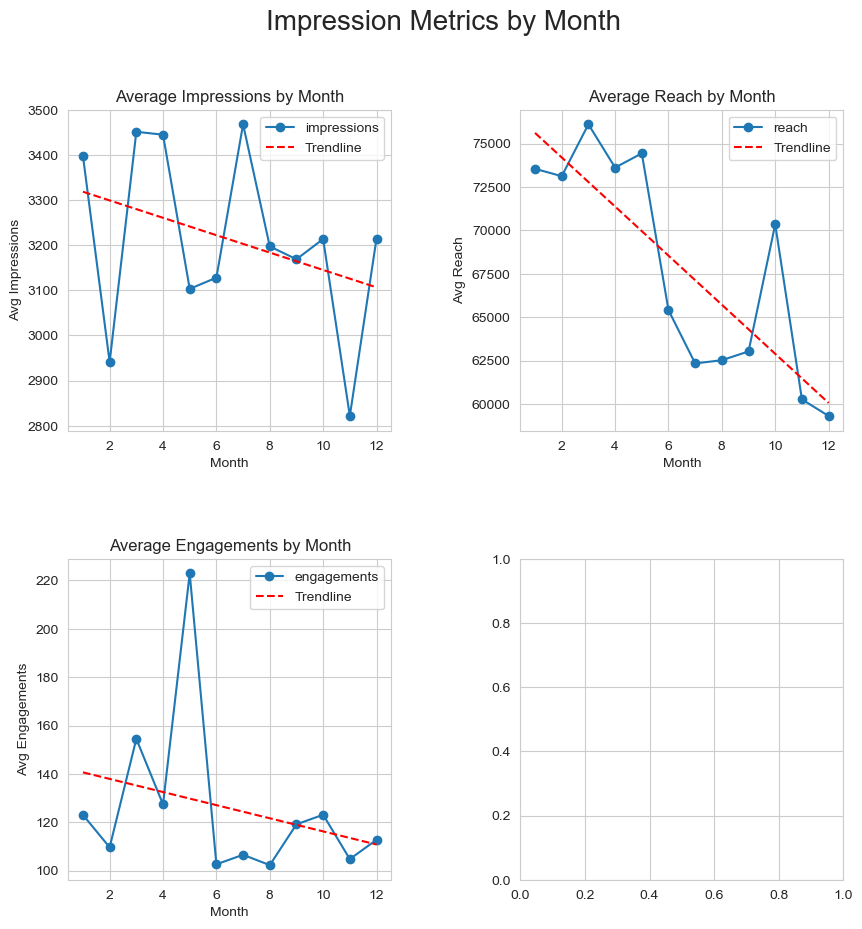

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    month_mean = df.groupby(df.index.month)[name].mean().reset_index().set_index('date')
    month_mean.plot(
    xlabel='Month', ylabel=f'Avg {name.title()}', linestyle='-', 
    marker='o', title=f'Average {name.title()} by Month',
    label=name, ax=ax
    )
    x_values = month_mean.index
    coefficients = np.polyfit(x_values, month_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    ax.plot(x_values, trendline_values, label='Trendline', linestyle='--', color='red')
    ax.legend()

plt.suptitle('Impression Metrics by Month', fontsize=20)
plt.show()

Statistical Tests:

Pearson Correlation

In [138]:
correlation_coefficient, p_value = pearsonr(df.index.month, df.impressions)
print('Impressions v. Month')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.month, df.engagements)
print('Engagements v. Month')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.month, df.reach)
print('Reach v. Month')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Month
Correlation Coefficient: -0.014
P-Value: 0.007520928508275816


Engagements v. Month
Correlation Coefficient: -0.014
P-Value: 0.00890919697192517


Reach v. Month
Correlation Coefficient: -0.038
P-Value: 7.024893017249594e-13


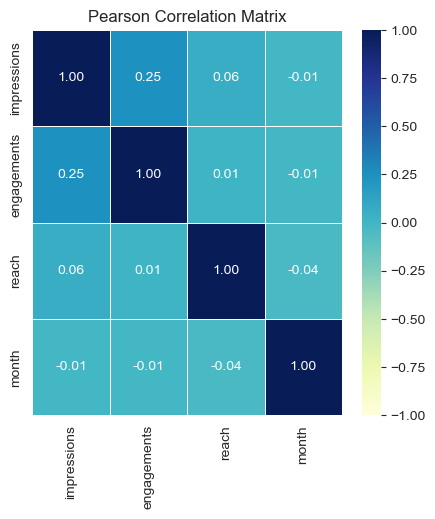

In [139]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(month=df.index.month)[[
        'impressions', 'engagements', 'reach', 'month'
        ]].corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Pearson Correlation Matrix');

Spearman Rank Correlation:

According to Pearson and Spearman Rank Correlation, there is no correlation between month of posting and the impression metrics.

In [140]:
rho, p_value = spearmanr(df.index.month, df.impressions)
print('Impressions v. Month')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.month, df.engagements)
print('Engagements v. Month')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.month, df.reach)
print('Reach v. Month')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")


Impressions v. Month
Spearman's rho (ρ): -0.013
P-value: 0.014933555561172415


Engagements v. Month
Spearman's rho (ρ): 0.002
P-value: 0.685412813504236


Reach v. Month
Spearman's rho (ρ): -0.027
P-value: 1.8750733858569564e-07


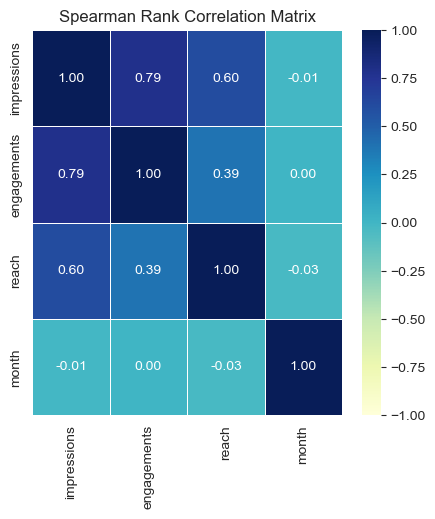

In [141]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(month=df.index.month)[[
        'impressions', 'engagements', 'reach', 'month'
        ]].corr(numeric_only=True, method='spearman'),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Spearman Rank Correlation Matrix');

Linear Regression:

Impressions

In [142]:
data = df.assign(month=df.index.month)
formula = 'impressions ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.145
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00752
Time:                        14:44:48   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3324.5417     49.640     66.973      0.0

In [143]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  4440.279212224301
R_squared / Goodness of Fit:  0.00019793663106515424


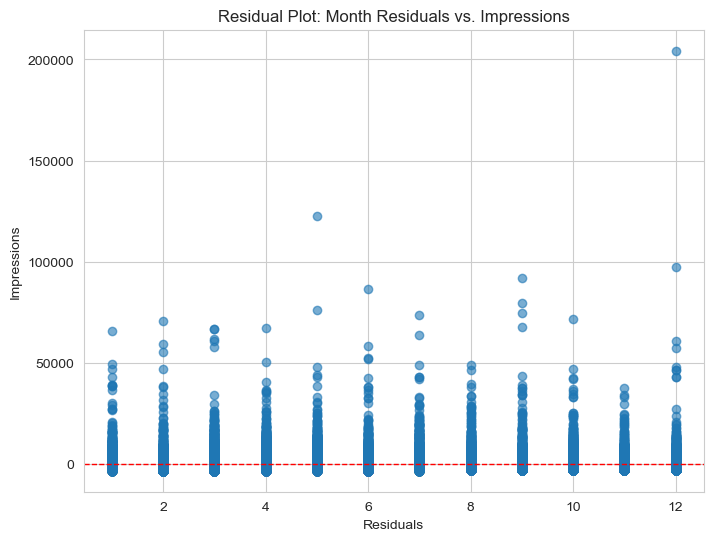

In [144]:
plt.figure(figsize=(8, 6))
plt.scatter(data.month, results.resid, alpha=0.6)
plt.title("Residual Plot: Month Residuals vs. Impressions")
plt.xlabel("Residuals")
plt.ylabel("Impressions")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [145]:
data = df.assign(month=df.index.month)
data['month'] = data.month ** 2
formula = 'impressions ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.506
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00354
Time:                        14:44:48   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3286.0747     35.671     92.122      0.0

Engagements

In [146]:
data = df.assign(month=df.index.month)
formula = 'engagements ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.842
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00891
Time:                        14:44:48   Log-Likelihood:            -2.8830e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    146.0035      7.966     18.328      0.0

In [147]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  712.5762419829857
R_squared / Goodness of Fit:  0.00018953687923040086


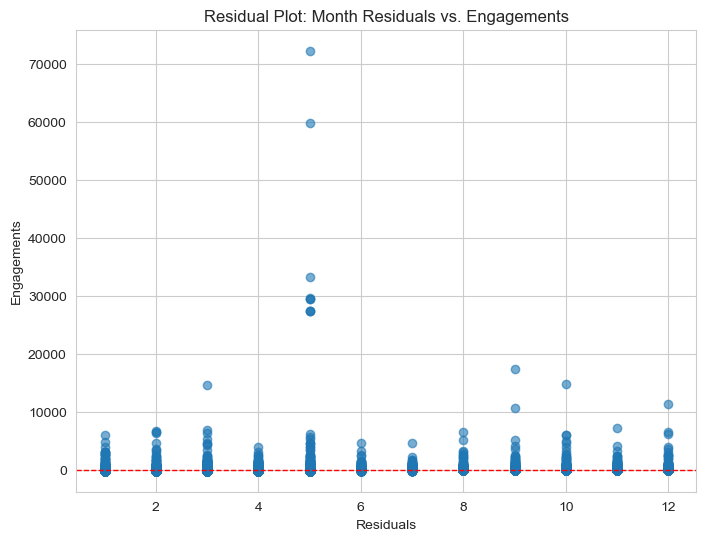

In [148]:
plt.figure(figsize=(8, 6))
plt.scatter(data.month, results.resid, alpha=0.6)
plt.title("Residual Plot: Month Residuals vs. Engagements")
plt.xlabel("Residuals")
plt.ylabel("Engagements")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [149]:
data = df.assign(month=df.index.month)
data['month'] = data.month ** 2
formula = 'engagements ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.053
Date:                Fri, 06 Oct 2023   Prob (F-statistic):            0.00262
Time:                        14:44:48   Log-Likelihood:            -2.8830e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    140.6323      5.724     24.567      0.0

Reach

In [150]:
data = df.assign(month=df.index.month)
formula = 'reach ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     51.57
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           7.02e-13
Time:                        14:44:48   Log-Likelihood:            -4.7584e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.727e+04   1438.615     53.709      0.0

In [151]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  128683.98730640755
R_squared / Goodness of Fit:  0.001427022789824317


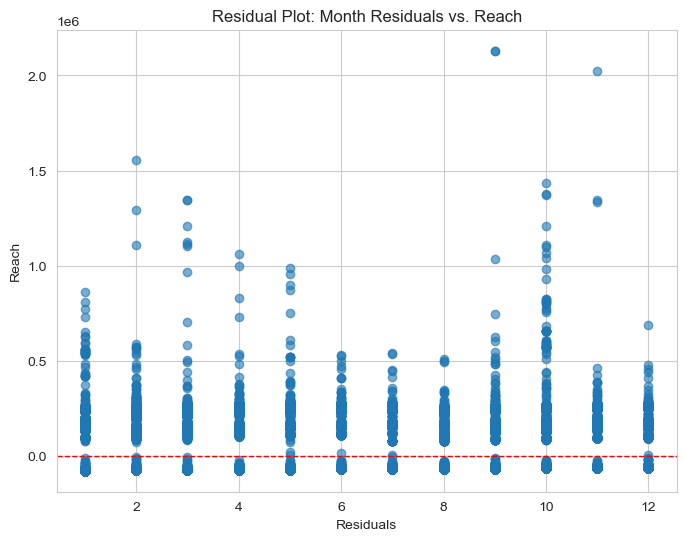

In [152]:
plt.figure(figsize=(8, 6))
plt.scatter(data.month, results.resid, alpha=0.6)
plt.title("Residual Plot: Month Residuals vs. Reach")
plt.xlabel("Residuals")
plt.ylabel("Reach")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [153]:
data = df.assign(month=df.index.month)
data['month'] = data.month ** 2
formula = 'reach ~ month'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     49.02
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.57e-12
Time:                        14:44:49   Log-Likelihood:            -4.7584e+05
No. Observations:               36092   AIC:                         9.517e+05
Df Residuals:                   36090   BIC:                         9.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.362e+04   1033.838     71.211      0.0

T-test:

In [154]:
group1_data = df.index.month
group2_data = df.impressions

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Impressions v. Month')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.month
group2_data = df.engagements

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Engagements v. Month')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.month
group2_data = df.reach

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Reach v. Month')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Month
T-statistic: -136.944
P-value: 0.0


Engagements v. Month
T-statistic: -32.314
P-value: 1.8892912632869177e-227


Reach v. Month
T-statistic: -100.532
P-value: 0.0


Mann-Whitney U-test:

In [155]:
group1_data = df.index.month
group2_data = df.impressions

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Impressions v. Month')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.month
group2_data = df.engagements

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Engagements v. Month')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.month
group2_data = df.reach

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Reach v. Month')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Month
U-statistic: 56869839.000
P-value: 0.0


Engagements v. Month
U-statistic: 57349377.500
P-value: 0.0


Reach v. Month
U-statistic: 417126545.000
P-value: 0.0


When we reclassified by Year, the trendline shows slight increases as the years increase for impressions and engagements and the inverse (slight decrease) for reach.

Peak years for impression metrics are:
- 2019 for Impressions 
- 2013 for Engagements
- 2020 for Reach

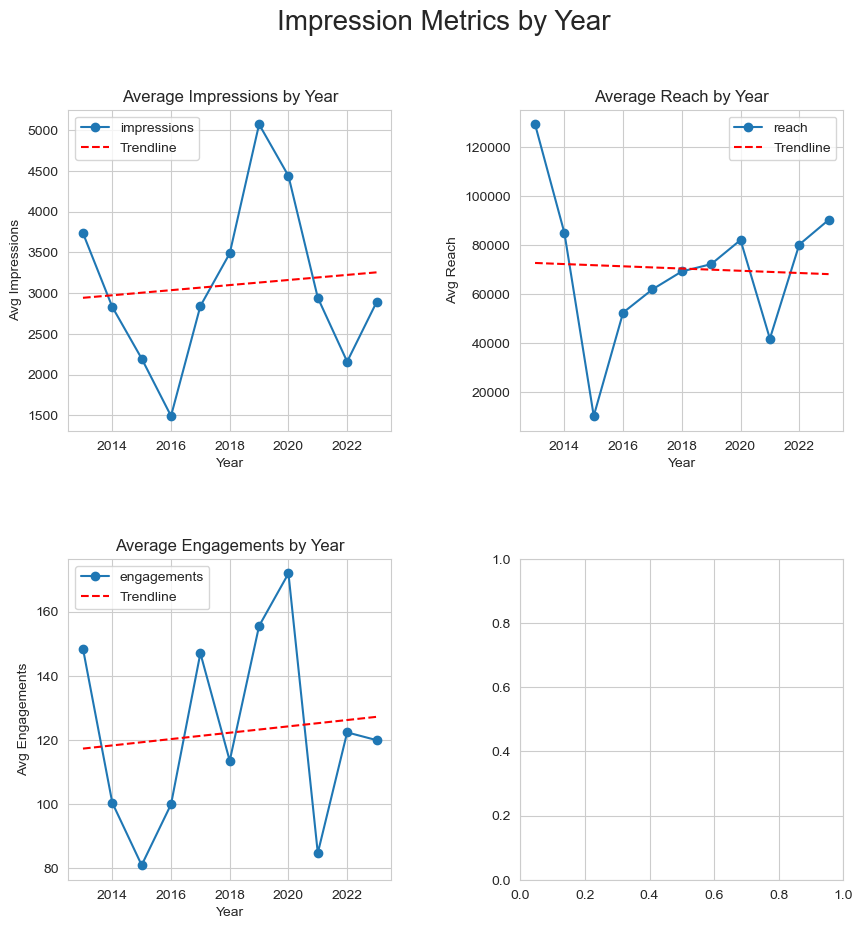

In [156]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), ['impressions', 'reach', 'engagements']):
    yr_mean = df.groupby(df.index.year)[name].mean().reset_index().set_index('date')
    yr_mean.plot(
    xlabel='Year', ylabel=f'Avg {name.title()}', linestyle='-', 
    marker='o', title=f'Average {name.title()} by Year',
    label=name, ax=ax
    )
    x_values = yr_mean.index
    coefficients = np.polyfit(x_values, yr_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    ax.plot(x_values, trendline_values, label='Trendline', linestyle='--', color='red')
    ax.legend()

plt.suptitle('Impression Metrics by Year', fontsize=20)
plt.show()

Statistical Tests:

Pearson Correlation

In [157]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.impressions)
print('Impressions v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.year, df.engagements)
print('Engagements v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

correlation_coefficient, p_value = pearsonr(df.index.year, df.reach)
print('Reach v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')

Impressions v. Year
Correlation Coefficient: -0.002
P-Value: 0.6381539937464477


Engagements v. Year
Correlation Coefficient: -0.000
P-Value: 0.9521806427201329


Reach v. Year
Correlation Coefficient: 0.065
P-Value: 2.8943217919284545e-35


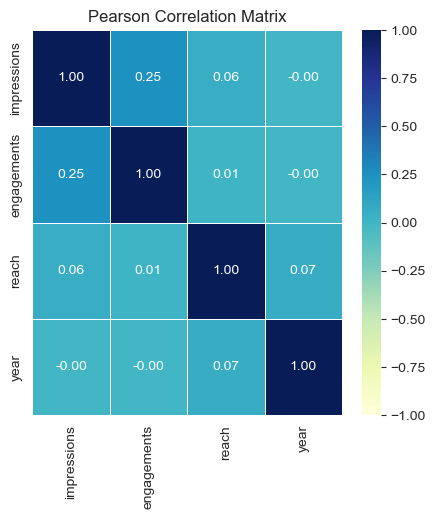

In [158]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(year=df.index.year)[[
        'impressions', 'engagements', 'reach', 'year'
        ]].corr(numeric_only=True),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Pearson Correlation Matrix');

Spearman Rank Correlation:

According to Pearson and Spearman Rank Correlation, there is no correlation between month of posting and the impression metrics.

In [159]:
rho, p_value = spearmanr(df.index.year, df.impressions)
print('Impressions v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.year, df.engagements)
print('Engagements v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")
print('\n')

rho, p_value = spearmanr(df.index.year, df.reach)
print('Reach v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")


Impressions v. Year
Spearman's rho (ρ): -0.045
P-value: 9.218799107473157e-18


Engagements v. Year
Spearman's rho (ρ): -0.122
P-value: 1.4440660933647372e-120


Reach v. Year
Spearman's rho (ρ): 0.100
P-value: 5.296694704003087e-81


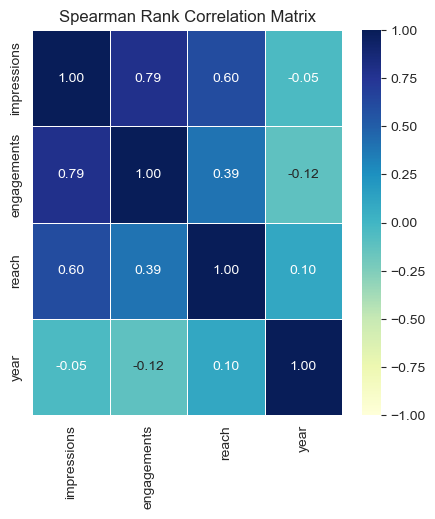

In [160]:
plt.figure(figsize=(5, 5))
sns.heatmap(
    df.assign(year=df.index.year)[[
        'impressions', 'engagements', 'reach', 'year'
        ]].corr(numeric_only=True, method='spearman'),
    annot=True,
    linewidths=0.5,
    center=0,
    vmin=-1,
    vmax=1,
    fmt= ".2f",
    cmap="YlGnBu")
plt.title('Spearman Rank Correlation Matrix');

Linear Regression:

Impressions

In [161]:
data = df.assign(year=df.index.year)
formula = 'impressions ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2212
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.638
Time:                        14:44:49   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.294e+04   2.07e+04      0.625      0.5

In [162]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  4440.7051175848555
R_squared / Goodness of Fit:  6.128206410660475e-06


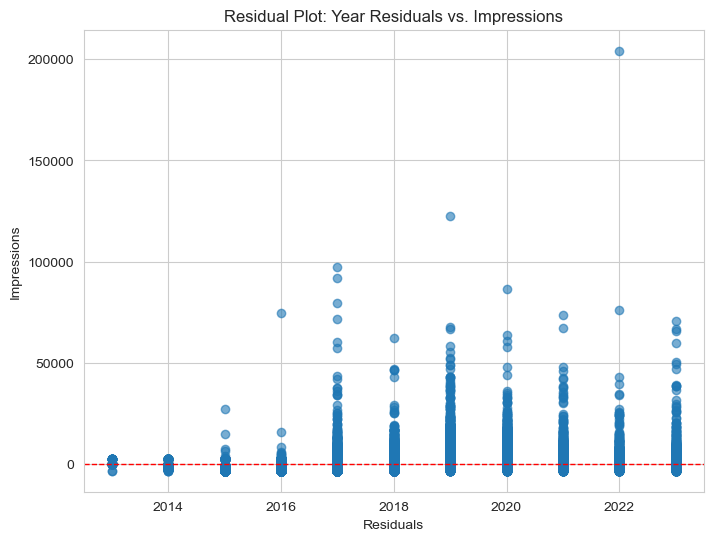

In [163]:
plt.figure(figsize=(8, 6))
plt.scatter(data.year, results.resid, alpha=0.6)
plt.title("Residual Plot: Year Residuals vs. Impressions")
plt.xlabel("Residuals")
plt.ylabel("Impressions")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [164]:
data = df.assign(year=df.index.year)
data['year'] = data.year ** 2
formula = 'impressions ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2377
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.626
Time:                        14:44:50   Log-Likelihood:            -3.5433e+05
No. Observations:               36092   AIC:                         7.087e+05
Df Residuals:                   36090   BIC:                         7.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8252.4176   1.03e+04      0.797      0.4

Engagements

In [165]:
data = df.assign(year=df.index.year)
formula = 'engagements ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003596
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.952
Time:                        14:44:50   Log-Likelihood:            -2.8830e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    326.7546   3320.610      0.098      0.9

In [166]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  712.6437458159633
R_squared / Goodness of Fit:  9.964762104353042e-08


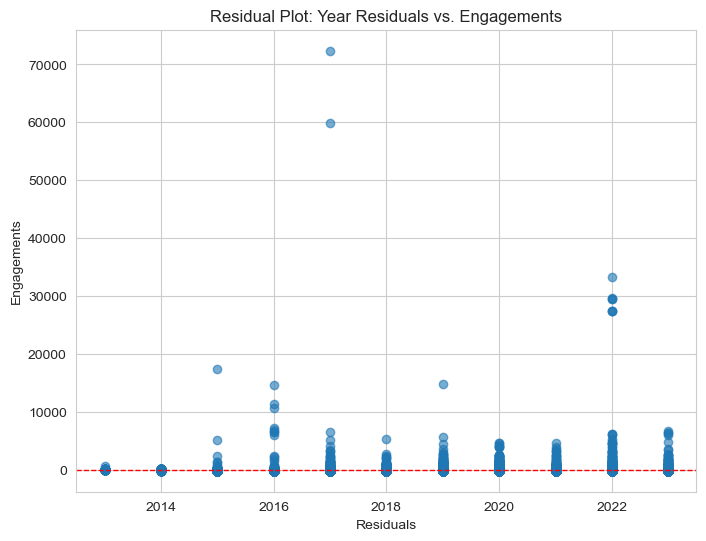

In [167]:
plt.figure(figsize=(8, 6))
plt.scatter(data.year, results.resid, alpha=0.6)
plt.title("Residual Plot: Year Residuals vs. Engagements")
plt.xlabel("Residuals")
plt.ylabel("Engagements")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [168]:
data = df.assign(year=df.index.year)
data['year'] = data.year ** 2
formula = 'engagements ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003846
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.951
Time:                        14:44:50   Log-Likelihood:            -2.8830e+05
No. Observations:               36092   AIC:                         5.766e+05
Df Residuals:                   36090   BIC:                         5.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    230.6134   1660.654      0.139      0.8

Reach

In [169]:
data = df.assign(year=df.index.year)
formula = 'reach ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     153.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.89e-35
Time:                        14:44:50   Log-Likelihood:            -4.7579e+05
No. Observations:               36092   AIC:                         9.516e+05
Df Residuals:                   36090   BIC:                         9.516e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -7.36e+06   5.99e+05    -12.291      0.0

In [170]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  128502.23051929736
R_squared / Goodness of Fit:  0.004245854314542052


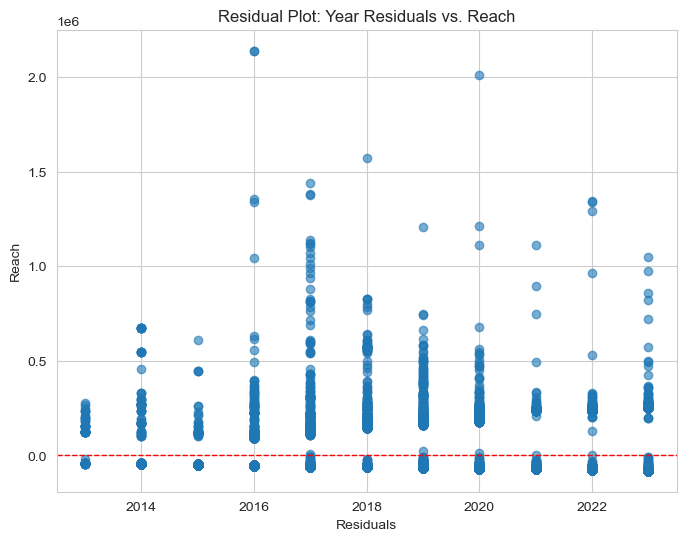

In [171]:
plt.figure(figsize=(8, 6))
plt.scatter(data.year, results.resid, alpha=0.6)
plt.title("Residual Plot: Year Residuals vs. Reach")
plt.xlabel("Residuals")
plt.ylabel("Reach")
plt.axhline(y=0, color='red', linestyle='--', lw=1)
plt.grid(True)
plt.show()

Polynomial Regression

In [172]:
data = df.assign(year=df.index.year)
data['year'] = data.year ** 2
formula = 'reach ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     153.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.91e-35
Time:                        14:44:50   Log-Likelihood:            -4.7579e+05
No. Observations:               36092   AIC:                         9.516e+05
Df Residuals:                   36090   BIC:                         9.516e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.646e+06   2.99e+05    -12.177      0.0

T-tests:

In [173]:
group1_data = df.index.year
group2_data = df.impressions

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Impressions v. Year')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.year
group2_data = df.engagements

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Engagements v. Year')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.year
group2_data = df.reach

t_stat, p_value = ttest_ind(group1_data, group2_data)
print('Reach v. Year')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Year
T-statistic: -50.818
P-value: 0.0


Engagements v. Year
T-statistic: 504.361
P-value: 0.0


Reach v. Year
T-statistic: -97.562
P-value: 0.0


In [174]:
group1_data = df.index.year
group2_data = df.impressions

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Impressions v. Year')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.year
group2_data = df.engagements

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Engagements v. Year')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")
print('\n')

group1_data = df.index.year
group2_data = df.reach

t_stat, p_value = mannwhitneyu(group1_data, group2_data)
print('Reach v. Year')
print(f"U-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

Impressions v. Year
U-statistic: 613749293.500
P-value: 3.755335723181876e-41


Engagements v. Year
U-statistic: 1297790323.500
P-value: 0.0


Reach v. Year
U-statistic: 633116653.500
P-value: 7.117954656904422e-11


Autocorrelation Analysis:

Impressions

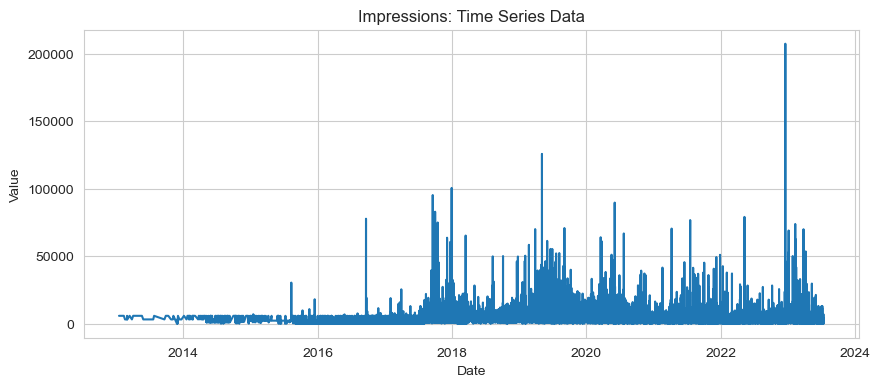

In [175]:
# Visualize the time series data to get an overview.
plt.figure(figsize=(10, 4))
plt.plot(df.impressions)
plt.title('Impressions: Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

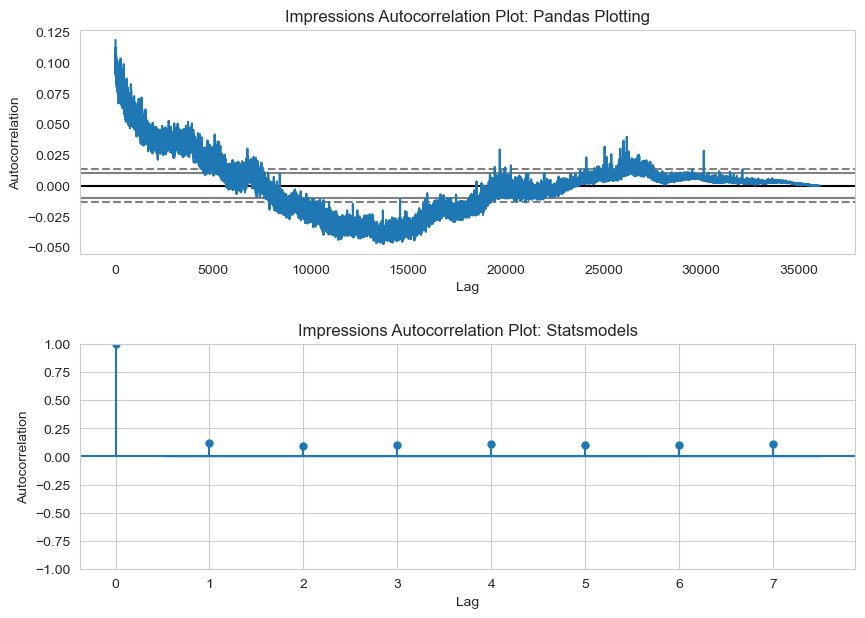

<Figure size 1000x400 with 0 Axes>

In [176]:
# Calculate the autocorrelation function (ACF) 
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.impressions, ax=axes[0])
axes[0].set_title('Impressions Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.impressions, lags=7, ax=axes[1])
axes[1].set_title('Impressions Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Statistical Testing:

The Ljung-Box test is a statistical test used to assess the presence of autocorrelation in a time series at multiple lags. It is a popular test for checking the independence of residuals in a time series analysis or forecasting context. 

The Ljung-Box test helps determine whether the autocorrelations of a time series at different lags are statistically significant, indicating whether the time series exhibits significant autocorrelation beyond what would be expected by chance.

In [177]:
# Check p-values for statistical significance
acorr_ljungbox(df.impressions, lags=7)

lb_stat      lb_pvalue
1   506.505254  3.652383e-112
2   840.184414  3.599753e-183
3  1238.949869  2.595801e-268
4  1696.380343   0.000000e+00
5  2042.668795   0.000000e+00
6  2410.066060   0.000000e+00
7  2818.030955   0.000000e+00

Engagements

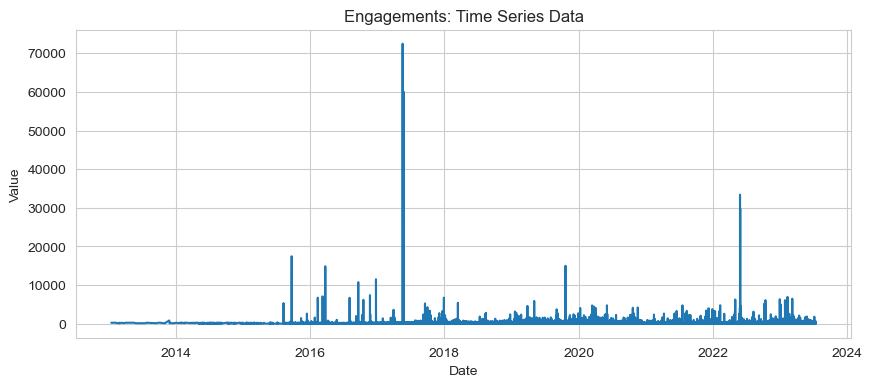

In [178]:
plt.figure(figsize=(10, 4))
plt.plot(df.engagements)
plt.title('Engagements: Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Plot the autocorrelation function (ACF)

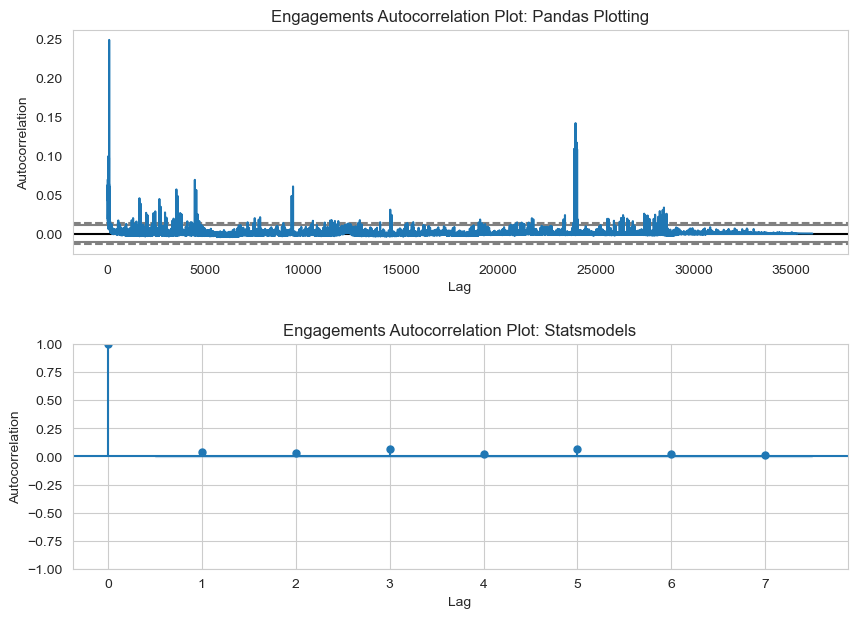

<Figure size 1000x400 with 0 Axes>

In [179]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.engagements, ax=axes[0])
axes[0].set_title('Engagements Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.engagements, lags=7, ax=axes[1])
axes[1].set_title('Engagements Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Statistical Significance

In [180]:
acorr_ljungbox(df.engagements, lags=7)

lb_stat     lb_pvalue
1   64.129914  1.164795e-15
2   92.734609  7.293490e-21
3  233.349962  2.609113e-50
4  245.681568  5.543563e-52
5  419.881801  1.536151e-88
6  435.070589  8.010216e-91
7  445.415567  4.284315e-92

Reach

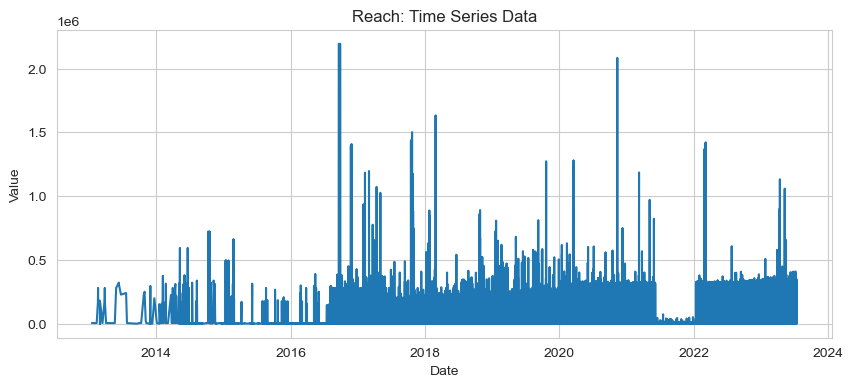

In [181]:
plt.figure(figsize=(10, 4))
plt.plot(df.reach)
plt.title('Reach: Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Autocorrelation Function:

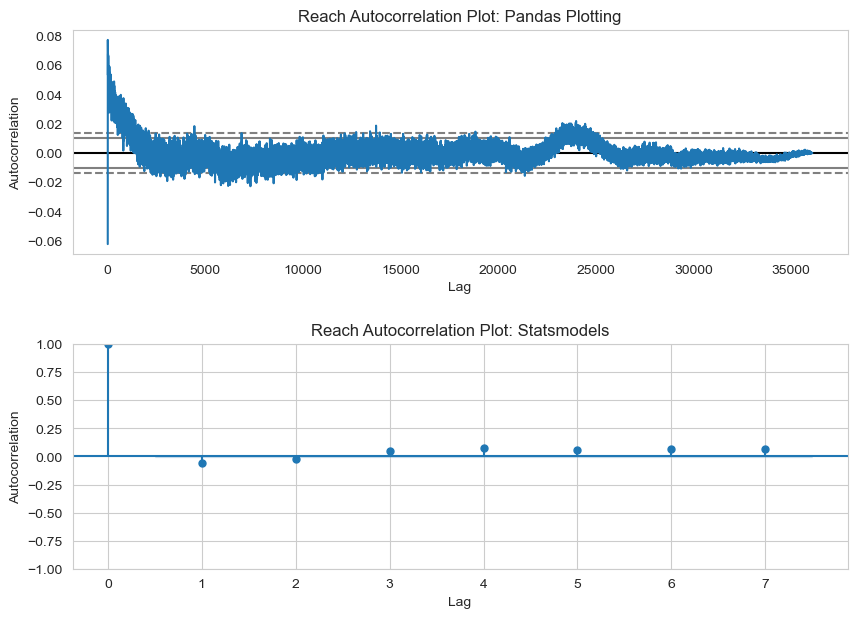

<Figure size 1000x400 with 0 Axes>

In [182]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.reach, ax=axes[0])
axes[0].set_title('Reach Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.reach, lags=7, ax=axes[1])
axes[1].set_title('Reach Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Statistical Significance

In [183]:
acorr_ljungbox(df.reach, lags=7)

lb_stat      lb_pvalue
1  139.918229   2.773929e-32
2  160.716833   1.261198e-35
3  234.074291   1.819173e-50
4  449.922854   4.513651e-96
5  580.951860  2.637401e-123
6  725.143671  2.276178e-153
7  866.053151  1.026046e-182

Conclusion:

When averaged over months, the general trendline across all impression metrics (impression, engagements, reach) is flat indicating no changes over time.

However, when averaged over any specific period (hour, day,  month, year), each impression metric has either an increased, decreased or flat trendline. From this, we generated and tested the hypothesis that there is as statistically significant relationship between time periods and impression metrics. We tested the strength our hypotheses using correlation tests, linear regression analysis, t-tests and u-tests.

We used correlation analysis to measure the strength and direction of the linear relationship between the two features. Pearson correlation assumes a normal distribution of the data and Spearman rank correlation assumes a non-normal distribution.

We used linear regression analysis to assess the strength and direction of the relationship between the two features by fitting a linear equation to the data. This helps us understand how one feature changes as the other changes.

We used T-Test or Mann-Whitney U Test to compare the means of the two features to determine whether there is a significant difference between the two groups. T-test assumes a normal distribution of the data and U-test assumes a non-normal distribution.

_Time Period: Hour_

All metrics show an increasing trendline when averaged by hour. However, there is no significant correlation between hour and any of the metrics. The highest correlation was with impressions, which was 6% with Pearson and 7% with Spearman Rho. The p-values for the correlations are much lower than our specified threshold of 5%, implying that the correlation is statistically significant. However, it is low.

When we tested the strength of the linear relationship between hour and the impression metrics using linear regression analysis, the r squared was 0% indicating that the linear equation / model was not a good fit for the data. This was confirmed by our residual plot. The model's RMSE of [impressions: 4432, engagements: 712, reach: 128772], indicated that its impression metrics predictions were on average [4432/ 712/ 128772] points greater than the actual/ observed impression metrics. None of the fits were improved by using a 2nd degree polynomial model.

When we compared the means of both features against hour to determine whether there was a significant difference between the two features, the metrics had negative T-statistic with a 0% p-value indicating that the distributions were not normal. However, they had very high positive U-statistic (the highest being for Reach) with 0% p-value indicating that when we assume the distribution are not normal, there is a statistically significant difference in the means of both features.

We can therefore conclude that when impressions is compared with Hour, there is a slight positive correlation and a significant difference between means. However, the relationship is not linear and cannot be modeled on a line. When we assume that the impression metric distributions are non-normal, we find that there is a statistically significant difference in the means of both features. However, hour may not be a good predictor for impression metrics.

_Time Period: Day_

Impressions and reach decrease when averaged by day, while engagements increase. However, there is no significant correlation between day and any of the metrics. The highest correlation was engagements at 2% with Pearson and impressions at 1% with Spearman Rho. The p-values for the correlations are lower than our specified threshold of 5%, implying that the correlation is statistically significant. However, it is low.

When we tested the strength of the linear relationship between day and the impression metrics using linear regression analysis, the r squared was 0% indicating that the linear equation / model was not a good fit for the data. This was confirmed by our residual plot. The model's RMSE of [impressions: 4440, engagements: 712, reach: 128775], indicated that its impression metrics predictions were on average [4440/ 712/ 128775] points greater than the actual/ observed impression metrics. None of the fits were improved by using a 2nd degree polynomial model.

When we compared the means of both features against day to determine whether there was a significant difference between the two features, the metrics had negative T-statistic with a 0% p-value indicating that the distributions were not normal. However, they had very high positive U-statistic (the highest being for Reach) with 0% p-value indicating that when we assume the distribution are not normal, there is a statistically significant difference in the means of both features.

We can therefore conclude that when impressions is compared with Day, there is a significant difference between means. However, the relationship is not linear and cannot be modeled on a line and there is no correlation. When we assume that the impression metric distributions are non-normal, we find that there is a statistically significant difference in the means of both features. However, day may not be a good predictor for impression metrics.

_Time Period: Month_

All metrics show an increasing trendline when averaged by month. However, there is no significant correlation between month and any of the metrics. The highest correlation was reach at -4% with Pearson and -3% with Spearman Rho. The p-values for the correlations are lower than our specified threshold of 5%, implying that the correlation is statistically significant. However, it is low.

When we tested the strength of the linear relationship between month and the impression metrics using linear regression analysis, the r squared was 0% indicating that the linear equation / model was not a good fit for the data. This was confirmed by our residual plot. The model's RMSE of [impressions: 4440, engagements: 712, reach: 128683], indicated that its impression metrics predictions were on average [4440/ 712/ 128683] points greater than the actual/ observed impression metrics. None of the fits were improved by using a 2nd degree polynomial model.

When we compared the means of both features against month to determine whether there was a significant difference between the two features, the metrics had negative T-statistic with a 0% p-value indicating that the distributions were not normal. However, they had very high positive U-statistic (the highest being for Reach) with 0% p-value indicating that when we assume the distribution are not normal, there is a statistically significant difference in the means of both features.

We can therefore conclude that when impressions is compared with Month, there is a significant difference between means. However, the relationship is not linear and cannot be modeled on a line and there is no correlation. When we assume that the impression metric distributions are non-normal, we find that there is a statistically significant difference in the means of both features. However, month may not be a good predictor for impression metrics.

_Time Period: Year_

Impressions and engagements increase when averaged by year, while reach decrease.

However, there is a slight correlation between year and any of the metrics. The highest correlation was reach at 7% with Pearson and 10% with Spearman Rho, and -12% engagements with Spearman Rho. The p-values for the correlations are lower than our specified threshold of 5%, implying that the correlation is statistically significant. However, this is the most significant correlation we've seen. Year has better correlation with impression metrics than other time periods.

When we tested the strength of the linear relationship between year and the impression metrics using linear regression analysis, the r squared was 0% indicating that the linear equation / model was not a good fit for the data. This was confirmed by our residual plot. The model's RMSE of [impressions: 4440, engagements: 712, reach: 128502], indicated that its impression metrics predictions were on average [4440/ 712/ 128502] points greater than the actual/ observed impression metrics. None of the fits were improved by using a 2nd degree polynomial model.

When we compared the means of both features against year to determine whether there was a significant difference between the two features, the metrics had negative T-statistic with a 0% p-value indicating that the distributions were not normal. However, they had very high positive U-statistic (the highest being for Engagements) with 0% p-value indicating that when we assume the distribution are not normal, there is a statistically significant difference in the means of both features.

We can therefore conclude that when impressions is compared with Year, there is a significant difference between means. However, the relationship is not linear and cannot be modeled on a line. However, there is a slight correlationbetween Year and impression metrics, which is higher than for other time periods. When we assume that the impression metric distributions are non-normal, we find that there is a statistically significant difference in the means of both features. Year is a better time-period predictor for impression metrics, than other time periods.

**Trend Analysis: Key Questions**
* Are there any noticeable trends over time (e.g., increasing likes, decreasing shares)?

For this portion, we'll create a general metrics varriable for unique metrics tracked by at least 3 of the 4 social media networks.

In [184]:
gen_metrics = [
    'impressions', 'reach', 'engagements', 
    'engagement_rate_per_impression', 'engagement_rate_per_reach',
    'reactions', 'likes', 'comments', 'shares', 'post_link_clicks', 
    'post_clicks_all', 'video_views'
    ]

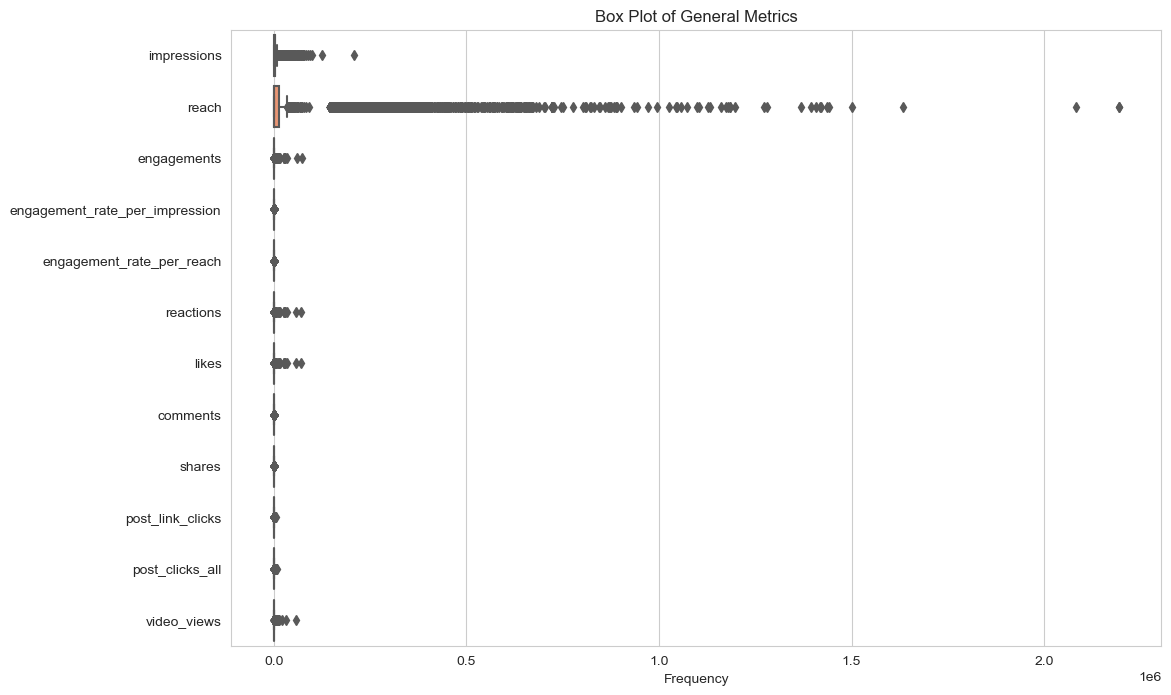

In [185]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[gen_metrics], orient="h", palette="Set2")
plt.title('Box Plot of General Metrics')
plt.xlabel('Frequency')

plt.show()

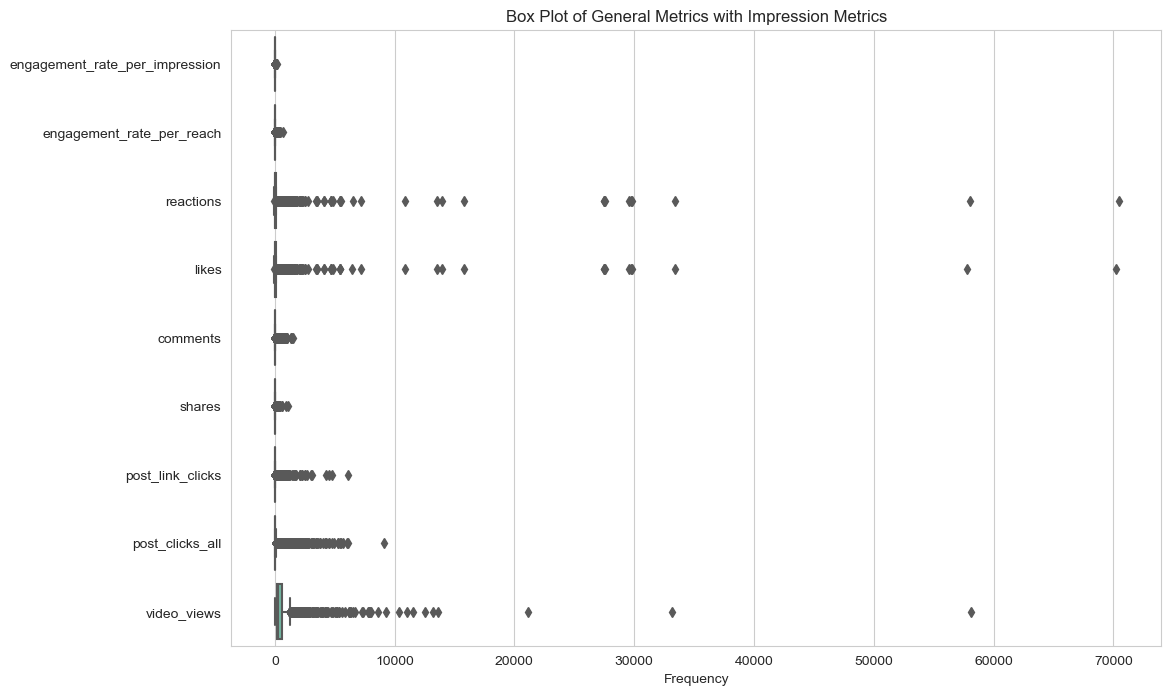

In [186]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[gen_metrics[3:]], orient="h", palette="Set2")
plt.title('Box Plot of General Metrics with Impression Metrics')
plt.xlabel('Frequency')

plt.show()

Generally, the trendlines for most features are flat or slightly inclined except for shares, which has a significant decline, and link clicks and video views which have significant inclines.

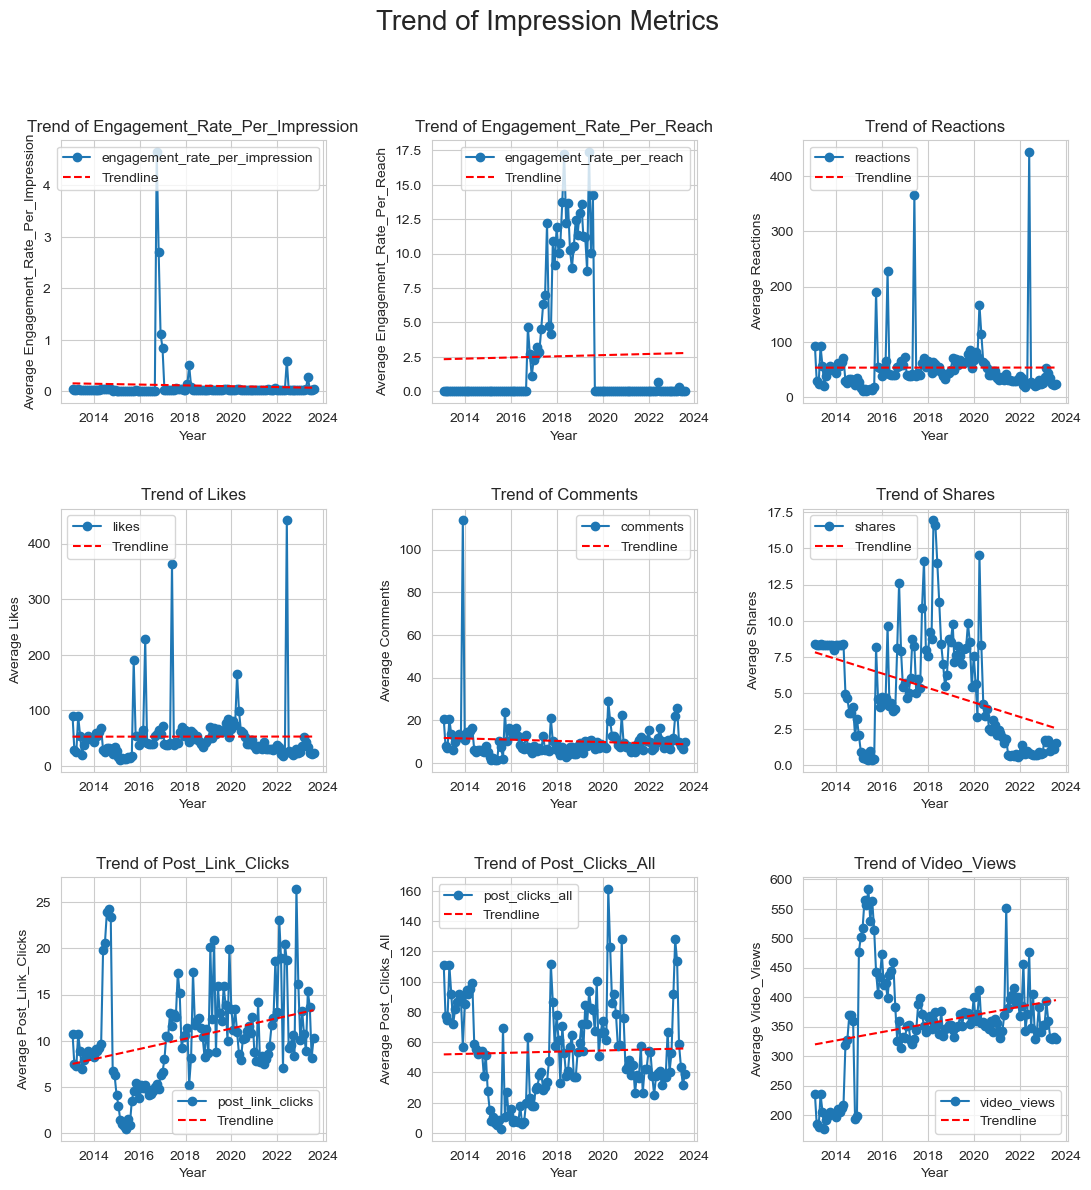

In [187]:
fig, axs = plt.subplots(3, 3, figsize=(13, 13))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), gen_metrics[3:]):
    monthly_mean = df[name].resample('M').mean().interpolate()
    ax.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label=name)
    x_values = pd.to_numeric(monthly_mean.index) / 10**9
    coefficients = np.polyfit(x_values, monthly_mean, 1)
    slope, intercept = coefficients

    trendline_values = slope * x_values + intercept
    trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
    ax.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Average {name.title()}')
    ax.set_title(f'Trend of {name.title()}')
    ax.legend()

plt.suptitle('Trend of Impression Metrics', fontsize=20)
plt.grid(True)
plt.show()

Statistical Tests:

We'll be conducting the following tests on the dataset, using network and timeseries data as independent variables and general metrics data as dependent variables:
1. Analysis of Variance
2. Regression Analysis
3. Kruskal-Wallis Test: The Equivalent of T & U Tests where the categorical variable has more than 2 levels.
4. Point Biserial Correlation - which measures the relationship between one binary (categorical) variable and one continuous (numeric) variable. In this case, the binary variable can be considered as a special categorical variable.

Analysis of Variance: Impressions

In [188]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'impressions ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df            F   PR(>F)
network   1.127122e+11      3.0  2263.400128  0.00000
year      1.286134e+08      1.0     7.748148  0.00538
Residual  5.990170e+11  36087.0          NaN      NaN


In the ANOVA model using network and year, network has a higher `sum of squares` of the residual error. This metric is used in models to quantify the variability explained by each independent variable while accounting for other variables in the model. `Network` also has a significantly higher F-statistic than `year` indicating that there are substantial variations in `impressions` across the different social media networks.

In this model, network has a significant impact on impressions. 

The chart of impressions by network over time is the visual confirmation of the ANOVA model.

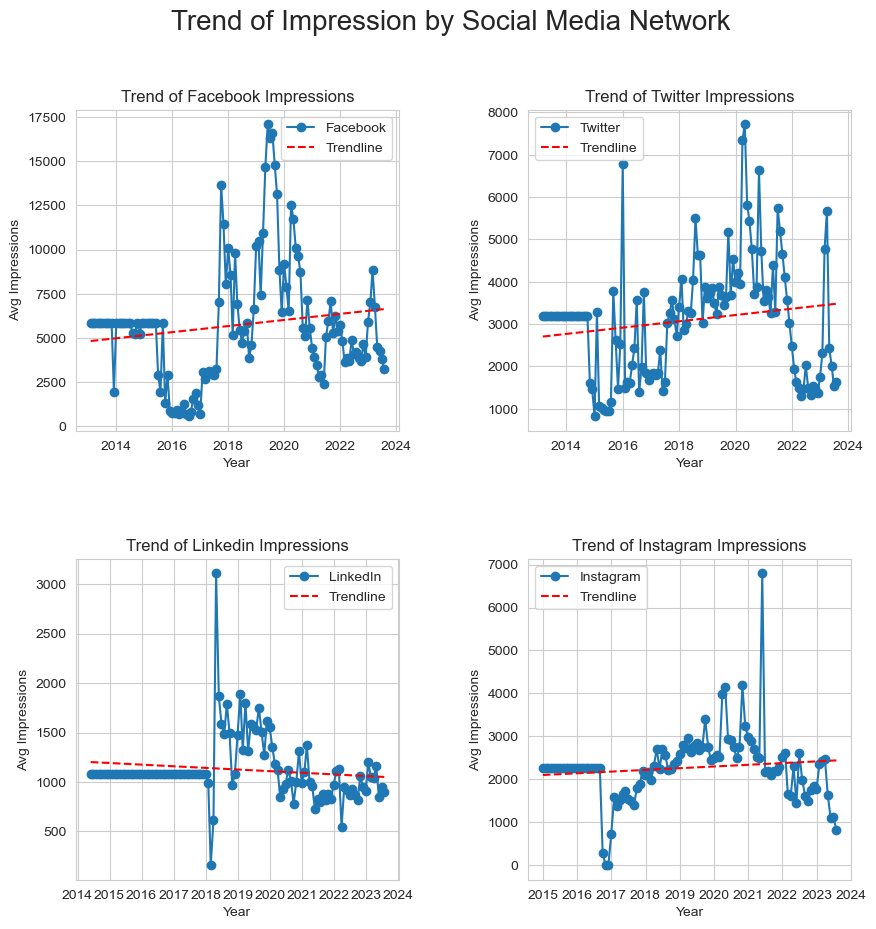

In [309]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), df.network.unique()):
    monthly_mean = df.loc[df.network==name, 'impressions'].resample('M').mean().interpolate()
    ax.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label=name)
    
    x_values = pd.to_numeric(monthly_mean.index) / 10**9
    coefficients = np.polyfit(x_values, monthly_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
    ax.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Avg Impressions')
    ax.set_title(f'Trend of {name.title()} Impressions')
    ax.legend()

plt.suptitle('Trend of Impression by Social Media Network', fontsize=20)
plt.grid(True)
plt.show()

In [310]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'impressions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df            F        PR(>F)
network       1.121045e+11      3.0  2268.732497  0.000000e+00
content_type  4.729010e+09      6.0    47.852052  8.191308e-59
year          3.053937e+08      1.0    18.541361  1.666954e-05
Residual      5.942880e+11  36081.0          NaN           NaN


When content type is included in the anova model, the F-statistic for the `year` variable doubles and the `sum of squares` triples, indicating that this model accounts for more significant variations in the `impressions` variable, than the previous model (without content type).

This plot confirms this model:

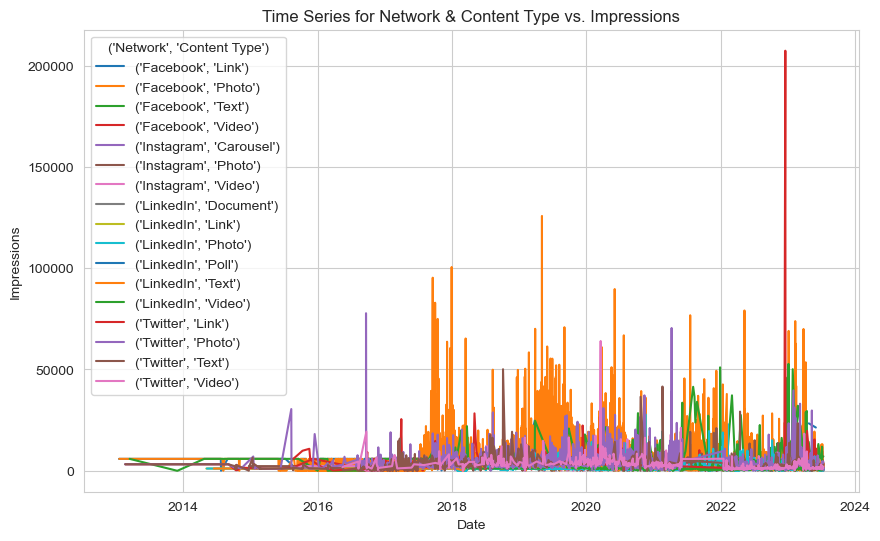

In [313]:
# Create a line plot with separate lines for each category
plt.figure(figsize=(10, 6))
for category1, category2 in df.groupby(['network', 'content_type']):
    plt.plot(category2.index, category2.impressions, label=category1)

plt.xlabel('Date')
plt.ylabel('Impressions')
plt.title('Time Series for Network & Content Type vs. Impressions')
plt.legend(title=('Network', 'Content Type'))
plt.grid(True)
plt.show()


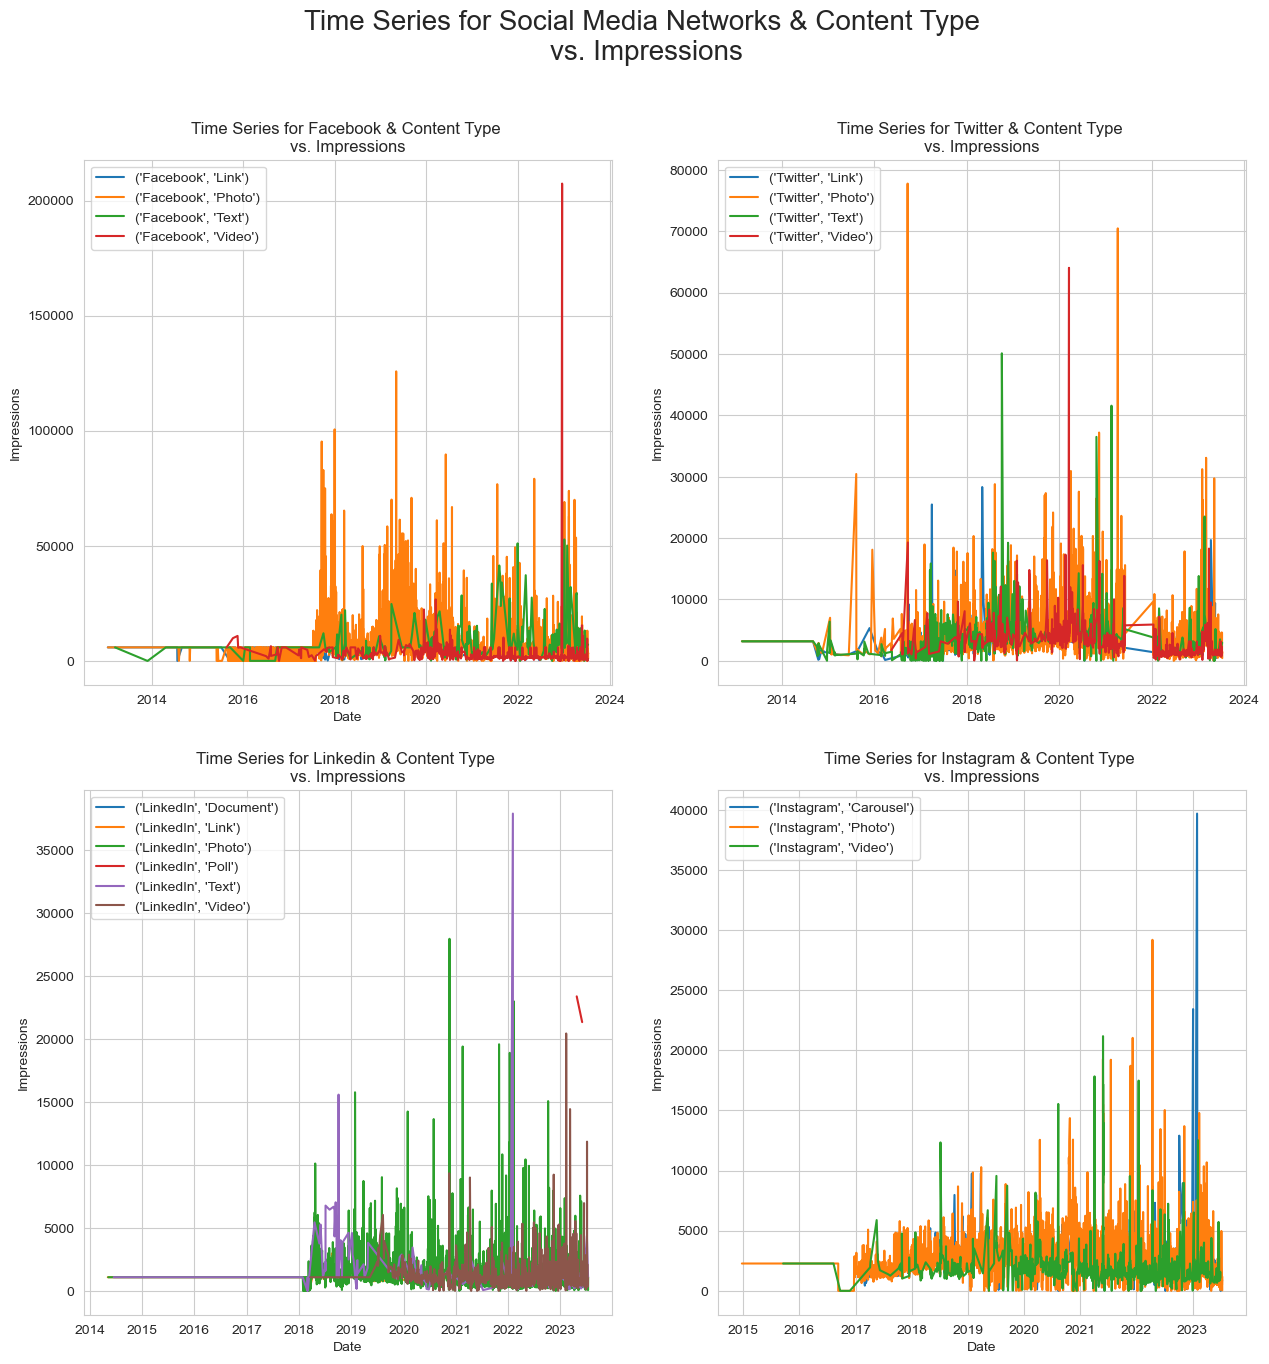

In [320]:
# Create a line plot with separate lines for each category
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for ax, network in zip(axs.ravel(), df.network.unique()):
    for category1, category2 in df.query(f'network=="{network}"').groupby(['network', 'content_type']):
        ax.plot(category2.index, category2.impressions, label=category1)
        ax.set_xlabel('Date')
        ax.set_ylabel('Impressions')
        ax.legend()
        ax.set_title(f'Time Series for {network.title()} & Content Type \nvs. Impressions')

plt.suptitle('Time Series for Social Media Networks & Content Type \nvs. Impressions', fontsize=20)
plt.grid(True)
plt.show()


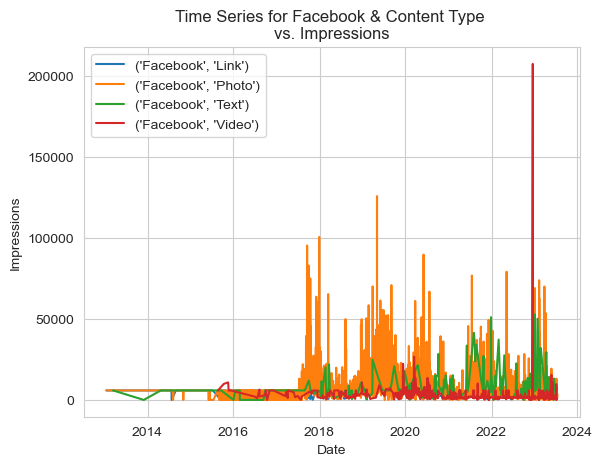

In [317]:
for category1, category2 in df.query(f'network=="Facebook"').groupby(['network', 'content_type']):
    plt.plot(category2.index, category2.impressions, label=category1)
    plt.xlabel('Date')
    plt.ylabel('Impressions')
    plt.legend()
    plt.title(f'Time Series for Facebook & Content Type \nvs. Impressions')


According to the 3-variable ANOVA model and the plot above, impressions are likely to be higher on Facebook when they're video posts from 2023 or photo posts anytime from late 2017.

Regression Analysis: Impressions

In [190]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'impressions ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1698.
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:02   Log-Likelihood:            -3.5122e+05
No. Observations:               36092   AIC:                         7.025e+05
Df Residuals:                   36087   BIC:                         7.025e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.731e+04 

In [323]:
print('RMSE: ', np.std(results.resid))
print(f'R_squared / Goodness of Fit: {results.rsquared:.3f}')

RMSE:  4057.82223461883
R_squared / Goodness of Fit: 0.165


The regression model with using year and networks to predict impressions has a more significant r-squared than we've previously seen (16%). According to the model, there is a significant negative linear relationship between networks and impression. 

The standard errors slope coefficients are not large, indicating that the line equation is close to the spread of the data. This means that when the network is Facebook, LinkedIn or Twitter, it negatively affects the slope of the line. 

However, the model's accuracy is still low at 16%.

In [192]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'impressions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     713.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:02   Log-Likelihood:            -3.5108e+05
No. Observations:               36092   AIC:                         7.022e+05
Df Residuals:                   36081   BIC:                         7.023e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

When content type is added to the model's predictors, it does not improve accuracy and it reduces the F-statistic by half. Content Typed document, link and photo do not have a statistically significant impact on `impressions` as as their t-statistic have significantly high p-values.

Let's remodel and exclude them:

In [329]:
values_to_filter = ["Document", "Link", "Photo", "Video"]
data = df.assign(year=df.index.year).query('content_type not in @values_to_filter')
formula = 'impressions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            impressions   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           7.22e-99
Time:                        18:40:25   Log-Likelihood:                -22701.
No. Observations:                2334   AIC:                         4.541e+04
Df Residuals:                    2328   BIC:                         4.545e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.496e+05 

The new model has a slightly higher accuracy than the initial model. However, standard errors are higher, but the t-statistic and t-value indicate that there is a statistically significant negative relationship between Instagram, LinkedIn, Twitter, Poll and Text and impressions. This model is a better predictor of the impressions variable.

Kruskal-Wallis Test: Impressions

In [330]:
# Separate data into groups based on the categorical variable
data = df.assign(year=df.index.year)[['year', 'impressions', 'network']]
groups = [group for _, group in data.groupby('network')]

# Perform Kruskal-Wallis test
kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 11003.12011071 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


 The KW Test stat suggests that there are greater differences in the central tendencies (medians) among the groups, with the third group having the highest difference in median. The differences are all statistically significant. This indicates that classifying the dataset by network has a significant impact on the values for `impressions`.

 This confirms the ANOVA models and the Regression Models. 

Analysis of Variance: Engagements

In [332]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagements ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df           F        PR(>F)
network   1.625817e+08      3.0  107.650151  2.188042e-69
year      2.067156e+05      1.0    0.410618  5.216603e-01
Residual  1.816714e+10  36087.0         NaN           NaN


In [333]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'engagements ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df           F        PR(>F)
network       1.615714e+08      3.0  106.979018  5.917070e-69
content_type  2.653870e+06      6.0    0.878585  5.095025e-01
year          2.545584e+05      1.0    0.505642  4.770363e-01
Residual      1.816449e+10  36081.0         NaN           NaN


From both ANOVA models, the high sum of squares and F-statistic indicate that `network` significantly explains the variability in the `engagements` feature. Content type and year offer little explanation for the variability in the engagements feature and are near insignificant.

The chart below visualizes this model conclusion:

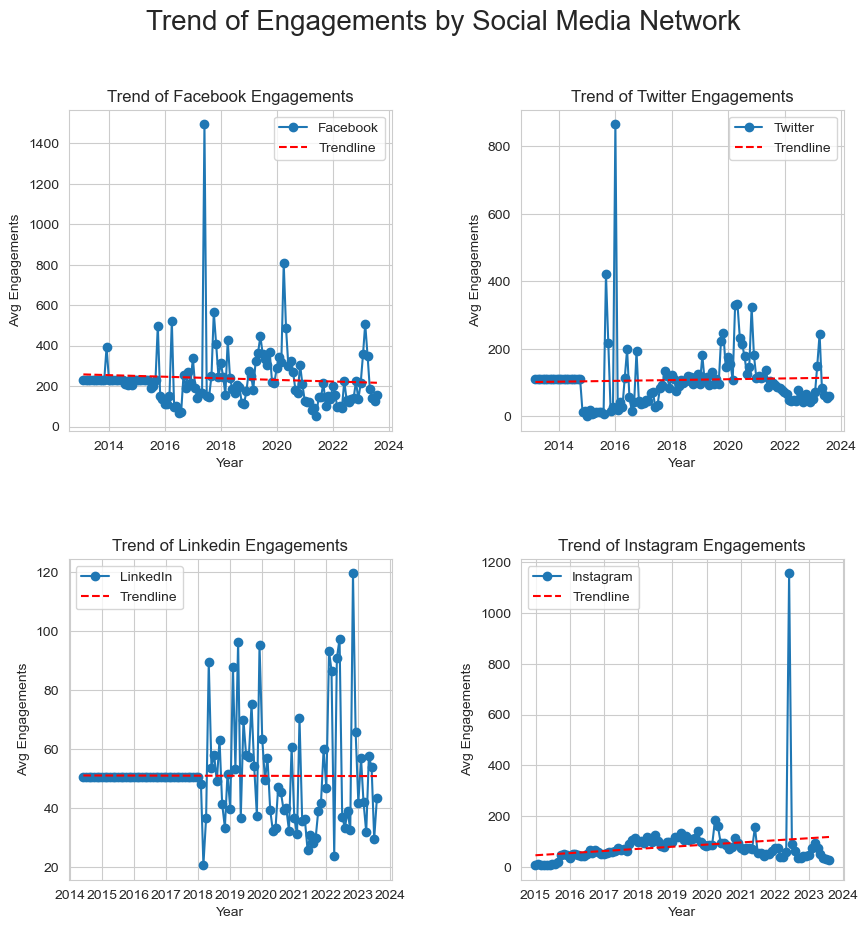

In [334]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, name in zip(axs.ravel(), df.network.unique()):
    monthly_mean = df.loc[df.network==name, 'engagements'].resample('M').mean().interpolate()
    ax.plot(monthly_mean.index, monthly_mean, marker='o', linestyle='-', label=name)
    
    x_values = pd.to_numeric(monthly_mean.index) / 10**9
    coefficients = np.polyfit(x_values, monthly_mean, 1)
    slope, intercept = coefficients
    trendline_values = slope * x_values + intercept
    trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)  
    ax.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Avg Engagements')
    ax.set_title(f'Trend of {name.title()} Engagements')
    ax.legend()

plt.suptitle('Trend of Engagements by Social Media Network', fontsize=20)
plt.grid(True)
plt.show()

Regression Analysis: Engagements

In [335]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagements ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     80.74
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.46e-68
Time:                        19:02:26   Log-Likelihood:            -2.8814e+05
No. Observations:               36092   AIC:                         5.763e+05
Df Residuals:                   36087   BIC:                         5.763e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1899.7585 

The regression model with network and year as predictor variables for engagements is a poor estimation of the dataset. 

In [197]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  709.4761880464861
R_squared / Goodness of Fit:  0.008869939298269958


In [198]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'engagements ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     32.82
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           3.36e-64
Time:                        14:45:03   Log-Likelihood:            -2.8814e+05
No. Observations:               36092   AIC:                         5.763e+05
Df Residuals:                   36081   BIC:                         5.764e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [199]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  709.4243657451839
R_squared / Goodness of Fit:  0.009014724326038226


Kruskal-Wallis Test: Engagements

In [200]:
data = df.assign(year=df.index.year)[['year', 'engagements', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563  8805.77418968 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Analysis of Variance: Reach

In [201]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'reach ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df             F  PR(>F)
network   5.065742e+14      3.0  68155.797828     0.0
year      4.700766e+12      1.0   1897.359519     0.0
Residual  8.940664e+13  36087.0           NaN     NaN


In [202]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'reach ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df             F         PR(>F)
network       4.866375e+14      3.0  66423.836196   0.000000e+00
content_type  1.293846e+12      6.0     88.302058  2.113738e-110
year          3.596323e+12      1.0   1472.645920  7.923292e-316
Residual      8.811279e+13  36081.0           NaN            NaN


Regression Analysis: Reach

In [203]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'reach ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 5.137e+04
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:04   Log-Likelihood:            -4.4155e+05
No. Observations:               36092   AIC:                         8.831e+05
Df Residuals:                   36087   BIC:                         8.832e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.016e+07 

In [204]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  49771.34869210018
R_squared / Goodness of Fit:  0.8506209787527992


In [205]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'reach ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.090e+04
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:04   Log-Likelihood:            -4.4129e+05
No. Observations:               36092   AIC:                         8.826e+05
Df Residuals:                   36081   BIC:                         8.827e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [206]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  49409.90392777885
R_squared / Goodness of Fit:  0.8527827130755127


Kruskal-Wallis Test: Reach

In [207]:
data = df.assign(year=df.index.year)[['year', 'reach', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 28886.40315837 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation: Engagement Rate per Impression

In [208]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.engagement_rate_per_impression)
print('Engagement Rate per Impression v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.engagement_rate_per_impression)
print('Engagement Rate per Impression v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Engagement Rate per Impression v. Year
Correlation Coefficient: -0.044
P-Value: 3.722039268864361e-17


Engagement Rate per Impression v. Year
Spearman's rho (ρ): 0.029
P-value: 2.4754311703168723e-08


Analysis of Variance: Engagement Rate per Impression

In [209]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_impression ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                 sum_sq       df          F        PR(>F)
network      522.124911      3.0  38.588810  6.896417e-25
year         277.371090      1.0  61.499194  4.550542e-15
Residual  162758.077839  36087.0        NaN           NaN


In [210]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'impressions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df            F        PR(>F)
network       1.121045e+11      3.0  2268.732497  0.000000e+00
content_type  4.729010e+09      6.0    47.852052  8.191308e-59
year          3.053937e+08      1.0    18.541361  1.666954e-05
Residual      5.942880e+11  36081.0          NaN           NaN


Regression Analysis: Engagement Rate per Impression

In [211]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_impression ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     engagement_rate_per_impression   R-squared:                       0.002
Model:                                        OLS   Adj. R-squared:                  0.002
Method:                             Least Squares   F-statistic:                     70.99
Date:                            Fri, 06 Oct 2023   Prob (F-statistic):           3.72e-17
Time:                                    14:45:04   Log-Likelihood:                -78451.
No. Observations:                           36092   AIC:                         1.569e+05
Df Residuals:                               36090   BIC:                         1.569e+05
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [212]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  2.1269696411872223
R_squared / Goodness of Fit:  0.0019631561461932456


In [213]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_impression ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     engagement_rate_per_impression   R-squared:                       0.005
Model:                                        OLS   Adj. R-squared:                  0.005
Method:                             Least Squares   F-statistic:                     46.74
Date:                            Fri, 06 Oct 2023   Prob (F-statistic):           2.99e-39
Time:                                    14:45:04   Log-Likelihood:                -78393.
No. Observations:                           36092   AIC:                         1.568e+05
Df Residuals:                               36087   BIC:                         1.568e+05
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-

In [214]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  2.123566187979311
R_squared / Goodness of Fit:  0.005154601829076899


In [215]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_impression ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     engagement_rate_per_impression   R-squared:                       0.006
Model:                                        OLS   Adj. R-squared:                  0.005
Method:                             Least Squares   F-statistic:                     20.24
Date:                            Fri, 06 Oct 2023   Prob (F-statistic):           6.57e-38
Time:                                    14:45:04   Log-Likelihood:                -78385.
No. Observations:                           36092   AIC:                         1.568e+05
Df Residuals:                               36081   BIC:                         1.569e+05
Df Model:                                      10                                         
Covariance Type:                        nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.97

In [216]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  2.123113486258799
R_squared / Goodness of Fit:  0.005578718789695625


Autocorrelation Analysis: Engagement Rate per Impression

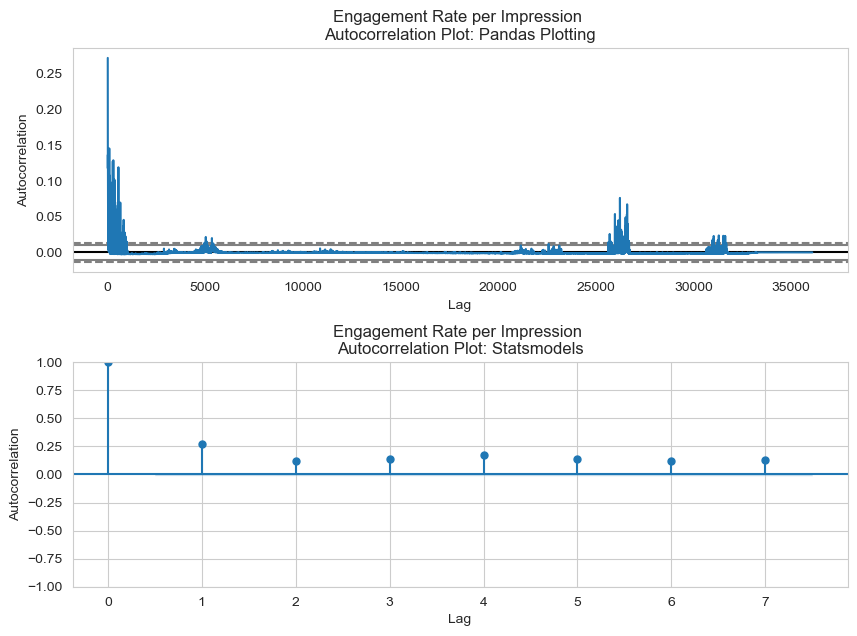

<Figure size 1000x400 with 0 Axes>

In [217]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.engagement_rate_per_impression, ax=axes[0])
axes[0].set_title('Engagement Rate per Impression \nAutocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.engagement_rate_per_impression, lags=7, ax=axes[1])
axes[1].set_title('Engagement Rate per Impression \nAutocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Engagement Rate per Impression

In [218]:
data = df.assign(year=df.index.year)[['year', 'engagement_rate_per_impression', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563   721.05856786 36091.        ]
P-Value: [9.27472407e-080 5.69702088e-156 0.00000000e+000]


Correlation: Engagement Rate per Reach

In [219]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.engagement_rate_per_reach)
print('Engagement Rate per Reach v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.engagement_rate_per_reach)
print('Engagement Rate per Reach v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Engagement Rate per Reach v. Year
Correlation Coefficient: -0.118
P-Value: 1.0222824475915938e-111


Engagement Rate per Reach v. Year
Spearman's rho (ρ): 0.040
P-value: 1.7063881493437385e-14


Analysis of Variance: Engagement Rate per Reach

In [220]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_reach ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df           F        PR(>F)
network   7.468341e+05      3.0  885.707112  0.000000e+00
year      1.119130e+05      1.0  398.169141  4.124596e-88
Residual  1.014293e+07  36087.0         NaN           NaN


In [221]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_reach ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df           F        PR(>F)
network       5.929202e+05      3.0  706.065181  0.000000e+00
content_type  4.322592e+04      6.0   25.737287  1.049103e-30
year          1.157656e+05      1.0  413.570124  1.996506e-91
Residual      1.009971e+07  36081.0         NaN           NaN


Regression Analysis: Engagement Rate per Reach

In [222]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_reach ~ year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     engagement_rate_per_reach   R-squared:                       0.014
Model:                                   OLS   Adj. R-squared:                  0.014
Method:                        Least Squares   F-statistic:                     508.0
Date:                       Fri, 06 Oct 2023   Prob (F-statistic):          1.02e-111
Time:                               14:45:07   Log-Likelihood:            -1.5425e+05
No. Observations:                      36092   AIC:                         3.085e+05
Df Residuals:                          36090   BIC:                         3.085e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [223]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  17.37015970588891
R_squared / Goodness of Fit:  0.01388053667906608


In [224]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_reach ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     engagement_rate_per_reach   R-squared:                       0.082
Model:                                   OLS   Adj. R-squared:                  0.081
Method:                        Least Squares   F-statistic:                     800.6
Date:                       Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                               14:45:07   Log-Likelihood:            -1.5296e+05
No. Observations:                      36092   AIC:                         3.059e+05
Df Residuals:                          36087   BIC:                         3.060e+05
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [225]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  16.76394754439223
R_squared / Goodness of Fit:  0.08150986920336412


In [226]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'engagement_rate_per_reach ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     engagement_rate_per_reach   R-squared:                       0.085
Model:                                   OLS   Adj. R-squared:                  0.085
Method:                        Least Squares   F-statistic:                     337.0
Date:                       Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                               14:45:07   Log-Likelihood:            -1.5289e+05
No. Observations:                      36092   AIC:                         3.058e+05
Df Residuals:                          36081   BIC:                         3.059e+05
Df Model:                                 10                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [227]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  16.72818812902816
R_squared / Goodness of Fit:  0.08542417868103269


Autocorrelation Analysis: Engagement Rate per Reach

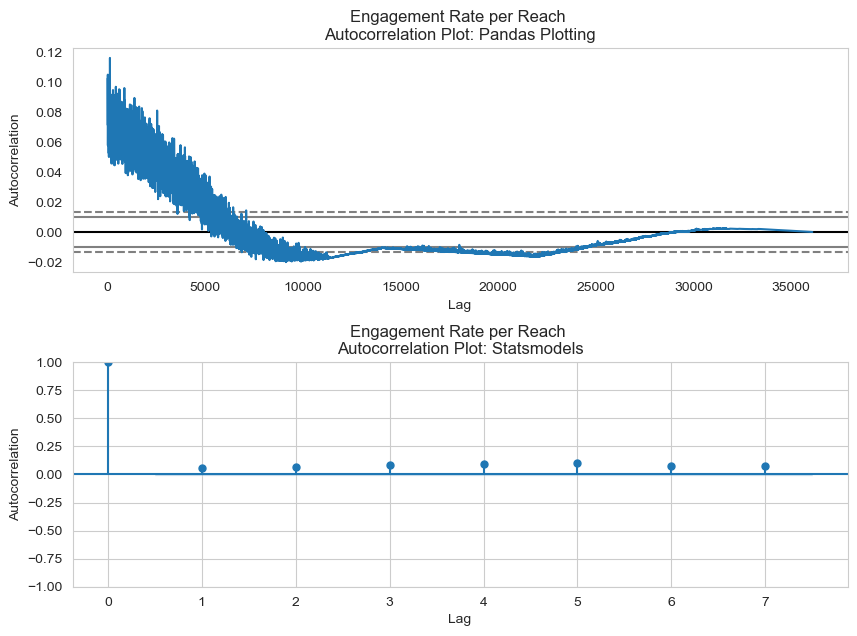

<Figure size 1000x400 with 0 Axes>

In [228]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.engagement_rate_per_reach, ax=axes[0])
axes[0].set_title('Engagement Rate per Reach \nAutocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.engagement_rate_per_reach, lags=7, ax=axes[1])
axes[1].set_title('Engagement Rate per Reach \nAutocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Engagement Rate per Reach

In [229]:
data = df.assign(year=df.index.year)[['year', 'engagement_rate_per_reach', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 21275.68743925 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation: Reactions

In [230]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.reactions)
print('Reactions v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.reactions)
print('Reactions v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Reactions v. Year
Correlation Coefficient: -0.006
P-Value: 0.26488875633779047


Reactions v. Year
Spearman's rho (ρ): -0.160
P-value: 1.2367114364852214e-206


Analysis of Variance: Reactions

In [231]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'reactions ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df          F        PR(>F)
network   4.762893e+07      3.0  36.638083  1.242832e-23
year      6.964811e+04      1.0   0.160728  6.884892e-01
Residual  1.563751e+10  36087.0        NaN           NaN


In [232]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'reactions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df          F        PR(>F)
network       4.443976e+07      3.0  34.180158  4.744105e-22
content_type  4.559349e+05      6.0   0.175338  9.835612e-01
year          1.057096e+05      1.0   0.243915  6.213958e-01
Residual      1.563705e+10  36081.0        NaN           NaN


Regression Analysis: Reactions

In [233]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'reactions ~ year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              reactions   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.243
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.265
Time:                        14:45:10   Log-Likelihood:            -2.8549e+05
No. Observations:               36092   AIC:                         5.710e+05
Df Residuals:                   36090   BIC:                         5.710e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3483.0657   3071.737      1.134      0.2

In [234]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  659.2326623903466
R_squared / Goodness of Fit:  3.4442264991940696e-05


In [235]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'reactions ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              reactions   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     27.79
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           4.47e-23
Time:                        14:45:10   Log-Likelihood:            -2.8543e+05
No. Observations:               36092   AIC:                         5.709e+05
Df Residuals:                   36087   BIC:                         5.709e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1329.0915 

In [236]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  658.2310002948119
R_squared / Goodness of Fit:  0.003070901768336909


In [237]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'reactions ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              reactions   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.22
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.07e-19
Time:                        14:45:10   Log-Likelihood:            -2.8543e+05
No. Observations:               36092   AIC:                         5.709e+05
Df Residuals:                   36081   BIC:                         5.710e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [238]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  658.221404371808
R_squared / Goodness of Fit:  0.003099968722435009


Autocorrelation Analysis: Reactions

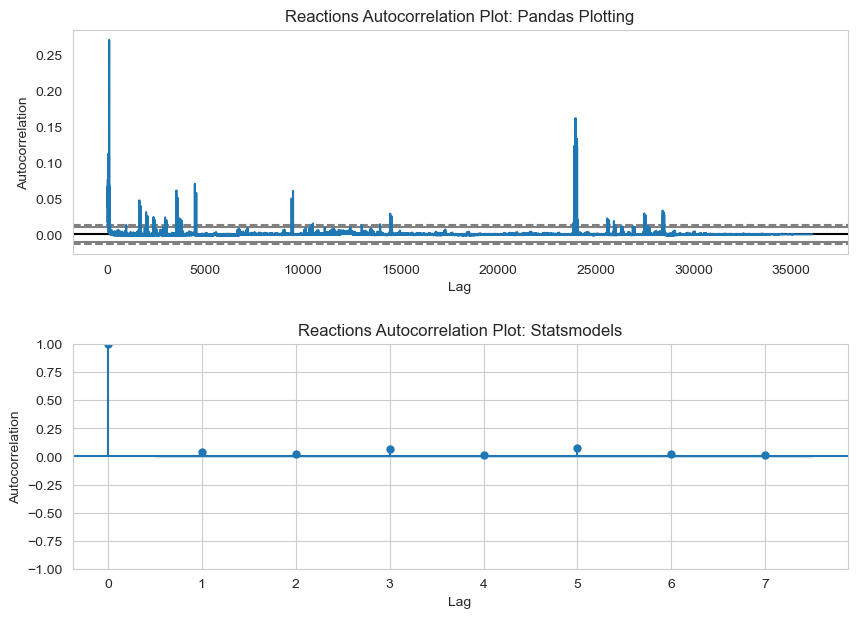

<Figure size 1000x400 with 0 Axes>

In [239]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.reactions, ax=axes[0])
axes[0].set_title('Reactions Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.reactions, lags=7, ax=axes[1])
axes[1].set_title('Reactions Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test Statistic: Reactions

In [240]:
data = df.assign(year=df.index.year)[['year', 'reactions', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 15914.13497428 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation: Likes

In [241]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.likes)
print('Likes v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.likes)
print('Likes v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Likes v. Year
Correlation Coefficient: -0.006
P-Value: 0.2515108512381758


Likes v. Year
Spearman's rho (ρ): -0.164
P-value: 4.788970904004522e-215


Analysis of Variance: Likes

In [242]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'likes ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df          F        PR(>F)
network   4.583747e+07      3.0  35.432009  7.423984e-23
year      8.098488e+04      1.0   0.187802  6.647549e-01
Residual  1.556161e+10  36087.0        NaN           NaN


In [243]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'likes ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df          F        PR(>F)
network       4.263453e+07      3.0  32.951660  2.927180e-21
content_type  4.607222e+05      6.0   0.178043  9.828901e-01
year          1.205562e+05      1.0   0.279529  5.970134e-01
Residual      1.556114e+10  36081.0        NaN           NaN


Regression Analysis: Likes

In [244]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'likes ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.315
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.252
Time:                        14:45:12   Log-Likelihood:            -2.8540e+05
No. Observations:               36092   AIC:                         5.708e+05
Df Residuals:                   36090   BIC:                         5.708e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3571.1894   3064.120      1.165      0.2

In [245]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  657.5978698996292
R_squared / Goodness of Fit:  3.6433532649371436e-05


In [246]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'likes ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     26.90
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           2.54e-22
Time:                        14:45:12   Log-Likelihood:            -2.8535e+05
No. Observations:               36092   AIC:                         5.707e+05
Df Residuals:                   36087   BIC:                         5.707e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1423.2098 

In [247]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  656.6315108411673
R_squared / Goodness of Fit:  0.0029732247674929546


In [248]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'likes ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  likes   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.87
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.06e-18
Time:                        14:45:13   Log-Likelihood:            -2.8535e+05
No. Observations:               36092   AIC:                         5.707e+05
Df Residuals:                   36081   BIC:                         5.708e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [249]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  656.6217905405987
R_squared / Goodness of Fit:  0.0030027430834390634


Autocorrelation Analysis: Likes

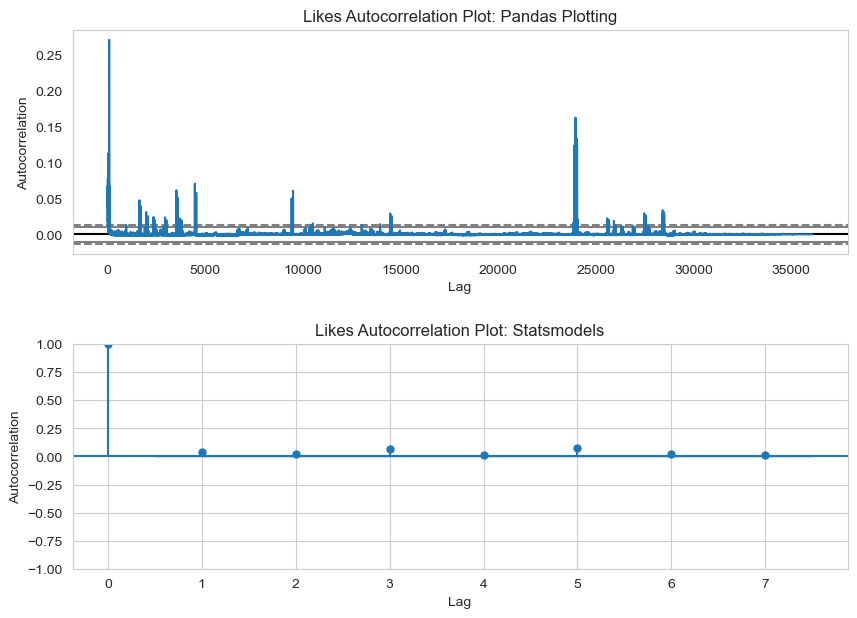

<Figure size 1000x400 with 0 Axes>

In [250]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.likes, ax=axes[0])
axes[0].set_title('Likes Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.likes, lags=7, ax=axes[1])
axes[1].set_title('Likes Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Likes

In [251]:
data = df.assign(year=df.index.year)[['year', 'likes', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 15733.20704728 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation: Comments

In [252]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.comments)
print('Comments v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.comments)
print('Comments v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Comments v. Year
Correlation Coefficient: 0.026
P-Value: 5.258332077518986e-07


Comments v. Year
Spearman's rho (ρ): 0.152
P-value: 6.146880411807766e-185


Analysis of Variance: Comments

In [253]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'comments ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df           F        PR(>F)
network   1.877052e+06      3.0  571.894063  0.000000e+00
year      5.250184e+04      1.0   47.988272  4.359525e-12
Residual  3.948118e+07  36087.0         NaN           NaN


In [254]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'comments ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df           F        PR(>F)
network       1.883638e+06      3.0  574.733393  0.000000e+00
content_type  6.375672e+04      6.0    9.726689  9.886652e-11
year          6.758624e+04      1.0   61.865506  3.779275e-15
Residual      3.941743e+07  36081.0         NaN           NaN


Regression Analysis: Comments

In [255]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'comments ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               comments   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     25.18
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           5.26e-07
Time:                        14:45:15   Log-Likelihood:            -1.7833e+05
No. Observations:               36092   AIC:                         3.567e+05
Df Residuals:                   36090   BIC:                         3.567e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -781.9574    157.732     -4.957      0.0

In [256]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  33.851313239008064
R_squared / Goodness of Fit:  0.0006970972425657251


In [257]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'comments ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               comments   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     435.5
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:15   Log-Likelihood:            -1.7749e+05
No. Observations:               36092   AIC:                         3.550e+05
Df Residuals:                   36087   BIC:                         3.550e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1053.6338 

In [258]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  33.07421945642834
R_squared / Goodness of Fit:  0.046050656657847355


In [259]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'comments ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               comments   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     180.3
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:15   Log-Likelihood:            -1.7746e+05
No. Observations:               36092   AIC:                         3.549e+05
Df Residuals:                   36081   BIC:                         3.550e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [260]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  33.04750349074854
R_squared / Goodness of Fit:  0.04759115467747954


Autocorrelation Analysis: Comments

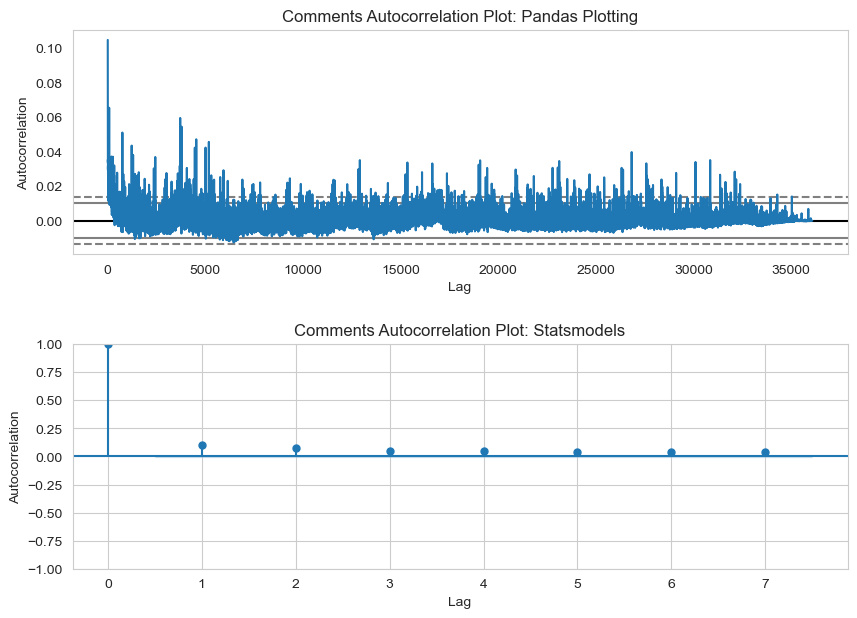

<Figure size 1000x400 with 0 Axes>

In [261]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.comments, ax=axes[0])
axes[0].set_title('Comments Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.comments, lags=7, ax=axes[1])
axes[1].set_title('Comments Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Comments

In [262]:
data = df.assign(year=df.index.year)[['year', 'comments', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563  9521.99186323 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation Analysis: Shares

In [263]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.shares)
print('Shares v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.shares)
print('Shares v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Shares v. Year
Correlation Coefficient: -0.163
P-Value: 1.8368193108568705e-212


Shares v. Year
Spearman's rho (ρ): -0.278
P-value: 0.0


Analysis of Variance: Shares

In [264]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'shares ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df            F         PR(>F)
network   5.427778e+05      3.0   967.513473   0.000000e+00
year      1.923249e+05      1.0  1028.470042  1.567846e-222
Residual  6.748303e+06  36087.0          NaN            NaN


In [265]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'shares ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df            F         PR(>F)
network       5.622235e+05      3.0  1007.215158   0.000000e+00
content_type  3.487983e+04      6.0    31.243352   1.113012e-37
year          2.089398e+05      1.0  1122.937811  1.810366e-242
Residual      6.713423e+06  36081.0          NaN            NaN


Regression Analysis: Shares

In [266]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'shares ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     980.9
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.84e-212
Time:                        14:45:18   Log-Likelihood:            -1.4701e+05
No. Observations:               36092   AIC:                         2.940e+05
Df Residuals:                   36090   BIC:                         2.940e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2078.6862     66.227     31.387      0.0

In [267]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  14.213154513384309
R_squared / Goodness of Fit:  0.026458977963117025


In [268]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'shares ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     990.6
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:18   Log-Likelihood:            -1.4561e+05
No. Observations:               36092   AIC:                         2.912e+05
Df Residuals:                   36087   BIC:                         2.913e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2064.2934 

In [269]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  13.673881411590914
R_squared / Goodness of Fit:  0.09893334254213115


In [270]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'shares ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     417.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:18   Log-Likelihood:            -1.4552e+05
No. Observations:               36092   AIC:                         2.911e+05
Df Residuals:                   36081   BIC:                         2.911e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [271]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  13.638497663094775
R_squared / Goodness of Fit:  0.10359066890583324


Autocorrelation Analysis: Shares

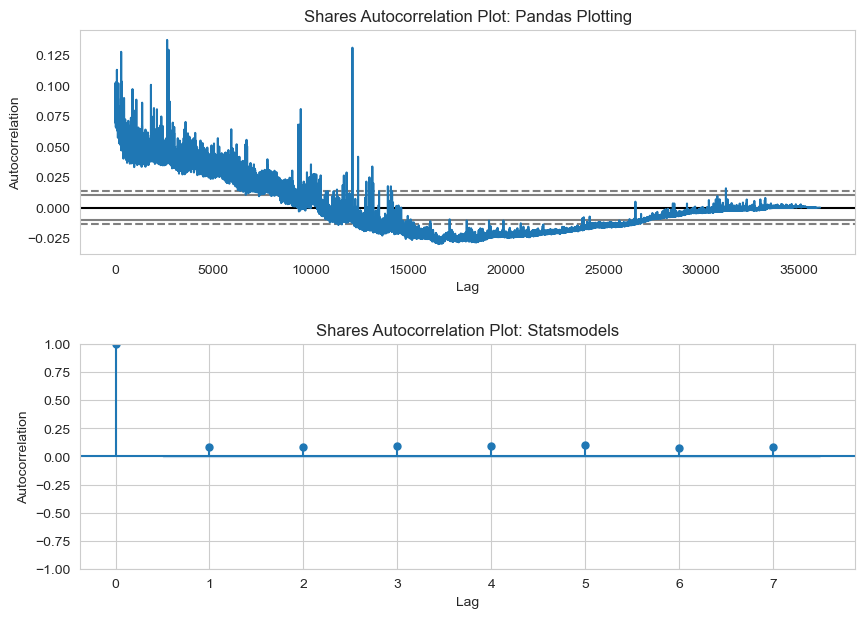

<Figure size 1000x400 with 0 Axes>

In [272]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.shares, ax=axes[0])
axes[0].set_title('Shares Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.shares, lags=7, ax=axes[1])
axes[1].set_title('Shares Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Shares

In [273]:
data = df.assign(year=df.index.year)[['year', 'shares', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 17034.03225766 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation Analysis: Link Clicks

In [274]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.post_link_clicks)
print('Link Clicks v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.post_link_clicks)
print('Link Clicks v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Link Clicks v. Year
Correlation Coefficient: 0.021
P-Value: 9.013713534818595e-05


Link Clicks v. Year
Spearman's rho (ρ): -0.037
P-value: 3.592660023402871e-12


Analysis of Variance: Links Clicks

In [275]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'post_link_clicks ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df           F         PR(>F)
network   4.715605e+06      3.0  265.485280  1.910039e-170
year      4.002169e+03      1.0    0.675958   4.109875e-01
Residual  2.136616e+08  36087.0         NaN            NaN


In [276]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'post_link_clicks ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df           F         PR(>F)
network       4.549690e+06      3.0  257.043865  4.535990e-165
content_type  7.830861e+05      6.0   22.121013   3.842114e-26
year          1.204467e+04      1.0    2.041463   1.530710e-01
Residual      2.128785e+08  36081.0         NaN            NaN


Regression Analysis: Link Clicks

In [277]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'post_link_clicks ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       post_link_clicks   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     15.34
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           9.01e-05
Time:                        14:45:20   Log-Likelihood:            -2.0836e+05
No. Observations:               36092   AIC:                         4.167e+05
Df Residuals:                   36090   BIC:                         4.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1407.9205    362.446     -3.884      0.0

In [278]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  77.78541561972908
R_squared / Goodness of Fit:  0.0004247650340163389


In [279]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'post_link_clicks ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       post_link_clicks   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     203.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.60e-172
Time:                        14:45:20   Log-Likelihood:            -2.0796e+05
No. Observations:               36092   AIC:                         4.159e+05
Df Residuals:                   36087   BIC:                         4.160e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -285.8568 

In [280]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  76.94098880832355
R_squared / Goodness of Fit:  0.0220094434264535


In [281]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'post_link_clicks ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       post_link_clicks   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     94.77
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          1.40e-194
Time:                        14:45:21   Log-Likelihood:            -2.0790e+05
No. Observations:               36092   AIC:                         4.158e+05
Df Residuals:                   36081   BIC:                         4.159e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [282]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  76.79986207422424
R_squared / Goodness of Fit:  0.025593853641350472


Autocorrelation Analysis: Link Clicks

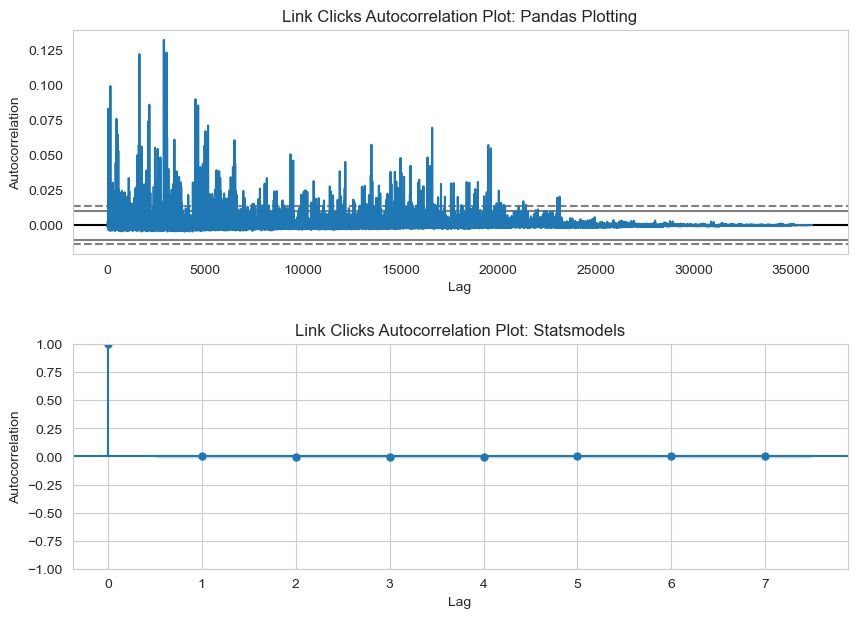

<Figure size 1000x400 with 0 Axes>

In [283]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.post_link_clicks, ax=axes[0])
axes[0].set_title('Link Clicks Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.post_link_clicks, lags=7, ax=axes[1])
axes[1].set_title('Link Clicks Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Link Clicks

In [284]:
data = df.assign(year=df.index.year)[['year', 'post_link_clicks', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 24419.88750122 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation Analysis: All Clicks

In [285]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.post_clicks_all)
print('All Clicks v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.post_clicks_all)
print('All Clicks v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

All Clicks v. Year
Correlation Coefficient: 0.028
P-Value: 7.624101715825431e-08


All Clicks v. Year
Spearman's rho (ρ): 0.046
P-value: 1.4298609029134058e-18


Analysis of Variance: All Clicks

In [286]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'post_clicks_all ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df           F        PR(>F)
network   6.730858e+07      3.0  686.140825  0.000000e+00
year      8.916227e+05      1.0   27.267491  1.781459e-07
Residual  1.180013e+09  36087.0         NaN           NaN


In [287]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'post_clicks_all ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df           F        PR(>F)
network       6.422802e+07      3.0  655.473308  0.000000e+00
content_type  1.520266e+06      6.0    7.757469  2.335167e-08
year          9.713781e+05      1.0   29.739939  4.973013e-08
Residual      1.178492e+09  36081.0         NaN           NaN


Regression Analysis: All Clicks

In [288]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'post_clicks_all ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        post_clicks_all   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.91
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           7.62e-08
Time:                        14:45:23   Log-Likelihood:            -2.3980e+05
No. Observations:               36092   AIC:                         4.796e+05
Df Residuals:                   36090   BIC:                         4.796e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4603.5086    866.222     -5.314      0.0

In [289]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  185.90184347180391
R_squared / Goodness of Fit:  0.0008004466151190215


In [290]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'post_clicks_all ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        post_clicks_all   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     522.2
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:23   Log-Likelihood:            -2.3880e+05
No. Observations:               36092   AIC:                         4.776e+05
Df Residuals:                   36087   BIC:                         4.777e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4315.7961 

In [291]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  180.8164221845492
R_squared / Goodness of Fit:  0.05471975551391439


In [292]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'post_clicks_all ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        post_clicks_all   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     213.8
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:23   Log-Likelihood:            -2.3878e+05
No. Observations:               36092   AIC:                         4.776e+05
Df Residuals:                   36081   BIC:                         4.777e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [293]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  180.6999074945874
R_squared / Goodness of Fit:  0.055937604507113825


Autocorrelation Analysis: All Clicks

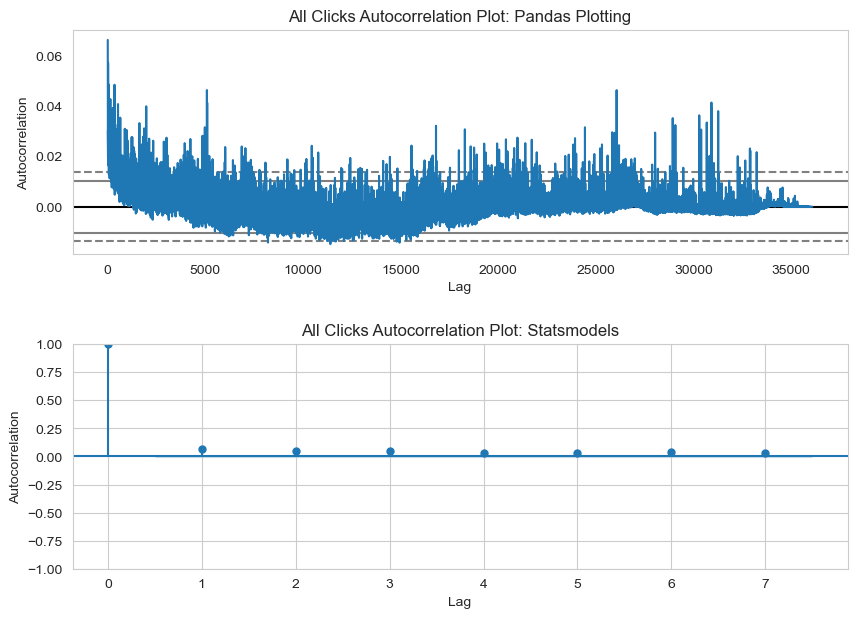

<Figure size 1000x400 with 0 Axes>

In [294]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.post_clicks_all, ax=axes[0])
axes[0].set_title('All Clicks Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.post_clicks_all, lags=7, ax=axes[1])
axes[1].set_title('All Clicks Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: All Clicks

In [295]:
data = df.assign(year=df.index.year)[['year', 'post_clicks_all', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 22112.43154222 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Correlation Analysis: Video Views

In [296]:
correlation_coefficient, p_value = pearsonr(df.index.year, df.video_views)
print('Video Views v. Year')
print(f'Correlation Coefficient: {correlation_coefficient:.3f}')
print(f'P-Value: {p_value}')
print('\n')

rho, p_value = spearmanr(df.index.year, df.video_views)
print('Video Views v. Year')
print(f"Spearman's rho (ρ): {rho:.3f}")
print(f"P-value: {p_value}")

Video Views v. Year
Correlation Coefficient: -0.000
P-Value: 0.9319501221181566


Video Views v. Year
Spearman's rho (ρ): -0.073
P-value: 1.047137591815844e-43


Analysis of Variance: Video Views

In [297]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'video_views ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                sum_sq       df            F    PR(>F)
network   1.074899e+09      3.0  1731.241659  0.000000
year      2.090167e+04      1.0     0.100993  0.750643
Residual  7.468608e+09  36087.0          NaN       NaN


In [298]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'video_views ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)

print(anova_table)

                    sum_sq       df            F        PR(>F)
network       1.095180e+09      3.0  1785.282448  0.000000e+00
content_type  9.065603e+07      6.0    73.890430  5.009696e-92
year          3.022004e+04      1.0     0.147788  7.006610e-01
Residual      7.377952e+09  36081.0          NaN           NaN


Regression Analysis: Video Views

In [299]:
# Independent Variables - Year
data = df.assign(year=df.index.year)
formula = 'video_views ~ year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            video_views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007292
Date:                Fri, 06 Oct 2023   Prob (F-statistic):              0.932
Time:                        14:45:26   Log-Likelihood:            -2.7452e+05
No. Observations:               36092   AIC:                         5.491e+05
Df Residuals:                   36090   BIC:                         5.491e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    562.3655   2267.034      0.248      0.8

In [300]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  486.53336704538407
R_squared / Goodness of Fit:  2.0204529482814593e-07


In [301]:
# Independent Variables - Network + Year
data = df.assign(year=df.index.year)
formula = 'video_views ~ network + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            video_views   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1298.
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:26   Log-Likelihood:            -2.7210e+05
No. Observations:               36092   AIC:                         5.442e+05
Df Residuals:                   36087   BIC:                         5.442e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -442.6938 

In [302]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  454.89835041582126
R_squared / Goodness of Fit:  0.12581494802435722


In [303]:
# Independent Variables - Network + Content Type + Year
data = df.assign(year=df.index.year)
formula = 'video_views ~ network + content_type + year'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            video_views   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     570.0
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:45:26   Log-Likelihood:            -2.7188e+05
No. Observations:               36092   AIC:                         5.438e+05
Df Residuals:                   36081   BIC:                         5.439e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [304]:
print('RMSE: ', np.std(results.resid))
print('R_squared / Goodness of Fit: ', results.rsquared)

RMSE:  452.12908016231603
R_squared / Goodness of Fit:  0.13642604818877235


Autoorrelation Analysis: Video Views

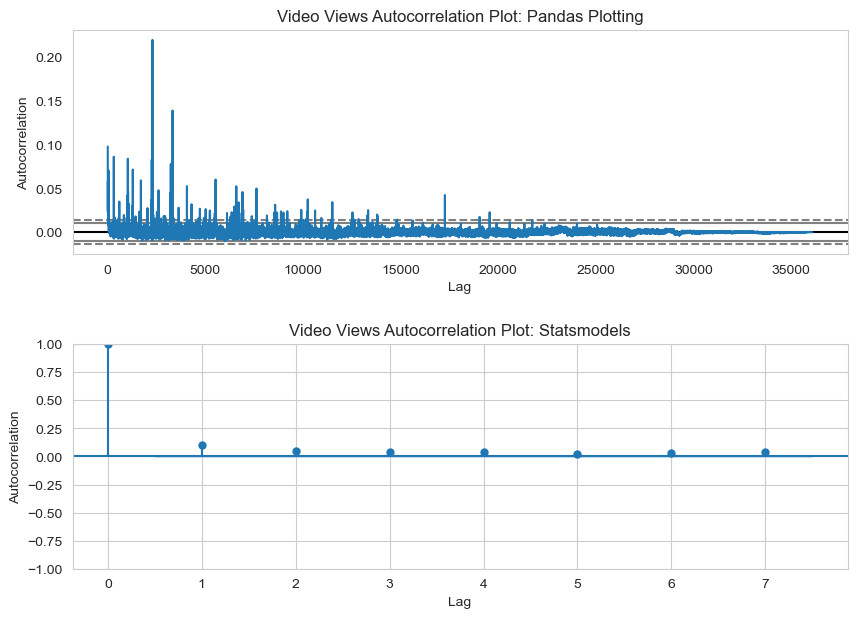

<Figure size 1000x400 with 0 Axes>

In [305]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig.subplots_adjust(hspace=0.4)

autocorrelation_plot(df.video_views, ax=axes[0])
axes[0].set_title('Video Views Autocorrelation Plot: Pandas Plotting')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plt.figure(figsize=(10, 4))
plot_acf(df.video_views, lags=7, ax=axes[1])
axes[1].set_title('Video Views Autocorrelation Plot: Statsmodels')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.show()

Kruskal-Wallis Test: Video Views

In [306]:
data = df.assign(year=df.index.year)[['year', 'video_views', 'network']]
groups = [group for _, group in data.groupby('network')]

kw_statistic, p_value = stats.kruskal(*groups)

print(f"Kruskal-Wallis Test Statistic: {kw_statistic}")
print(f"P-Value: {p_value}")

Kruskal-Wallis Test Statistic: [  369.42478563 26797.29137492 36091.        ]
P-Value: [9.27472407e-80 0.00000000e+00 0.00000000e+00]


Conclusion



**Exploring the Text Features**

#Hashtags: